# Case 5: Bayesian inference of model parameters using Stan

## Important!
Make sure you have a CmdStan version installed in your computer (the actual cmdstan, not CmdStan.jl) <br>
<br>
You can check the file InstallStanInJulia.pdf located in the directory InstallCmdstanInfo for the way I used to install it, however, you can do it in different ones. <br>
<br>
Also, remember that you can use this section of the package to generate all the necessary scripts, data transformations and other (without having cmdstan installed) and use these in a different environment (such as RStan in R). 

In [1]:
using BOMBs

### Just to print the nice BOMBS logo


In [2]:
printLogo()


                      ___________   __________   ___  ___   ___________   __________
                     /  _____   /  / ______  /  /   \/   \  \   _____  \  \  _______\
                    /  /____/  /  / /     / /  /          \  \  \____\  \  \ \________
                   /  _____   /  / /     / /  /            \  \   _____  \  \________ \
                  /  /    /  /  / /     / /  /   /\____/\   \  \  \    \  \          \ \
                 /  /____/  /  / /_____/ /  /   /        \   \  \  \____\  \   _______\ \
                /__________/  /_________/  /__ /          \___\  \__________\  \_________\

                


First we need to generate the model (the package will not do it automatically)

In [3]:
# Generate the empty dictionary with the model_def structure
model_def = defModStruct()

# Fill the different elements of the dictionary with your model specifications. See above how ^
model_def["NameF"] = ["PLacExample"];
model_def["nStat"] = [4];
model_def["nPar"] = [9];
model_def["nInp"] = [1];
model_def["stName"] = ["Cit_mrna","Cit_foldedP","Cit_fluo","Cit_AU"];

model_def["inpName"] = ["IPTG"];

model_def["parName"] = ["alpha1","Vm1","h1","Km1","d1",
                            "alpha2","d2","Kf","sc_molec"];
model_def["eqns"] = ["dCit_mrna=alpha1+Vm1*(IPTG^h1/(Km1^h1+IPTG^h1))-d1*Cit_mrna",
                    "dCit_foldedP=alpha2*Cit_mrna-(d2+Kf)*Cit_foldedP",
                    "dCit_fluo=Kf*Cit_foldedP-d2*Cit_fluo",
                    "dCit_AU = sc_molec*dCit_fluo"];

model_def["Y0eqs"] = ["Cit_mrna = (alpha1 + Vm1*(IPTG^h1/(Km1^h1+IPTG^h1)))/d1;",
                      "Cit_foldedP = (alpha2*Cit_mrna)/(Kf+d2);",
                      "Cit_fluo = (Kf*Cit_foldedP)/d2;",
                      "Cit_AU= sc_molec*Cit_fluo;"]; 

model_def["Y0Sim"] = [];
model_def["tols"] = [1e-9, 1e-9];

# Generate the scripts with the ODEs and the step-wise implementation
model_def = GenerateModel(model_def);


----------------------------------------- MODEL GENERATION -----------------------------------------
The model has been generated in the directory: 
                 E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\ModelsFunctions\PLacExample_Model.jl
--------------------------------------------------------------------------------------



### This function gives you information about the structure necessary to generate the model and how to call it. 
If you do not know how to call a specific section, just call the function with no input (infoAll()) to get the information.

In [4]:
infoAll("stan")



            CALL defBayInfStruct()

        MAIN STRUCTURE

bayinf_def["Priors"] = []; # Five options for this:
        # 1) A 2*N array containing the bounds for the parameters. Order of parameters will be assumed as
            # the one introduced in model_def["parName"]. As a prior a truncated Normal covering 2
            # standard deviations in the bounds given will be generated as prior.
        # 2) Path to a CSV file containing samples for the parameters. Fitting of the samples to
            # different type of distributions will be done to generate the priors. Order of parameters
            # will be assumed as the one introduced in model_def["parName"]. You can also
            # introduce a 2D array of floats with the samples (Array{Float64,2}).
        # 3) Dictionary with fields pars, transpars and pridis defining the
            # parameters, subsequent desired transformations and prior distributions.
            # In the field pars, parameters
            # have to

# Stan Inference Example 1
This example will not run an inference, but it will generate all the necessary elements that then you can use to run it in a different environment (R for example) or in Julia but after applying modifications. 

First we need to define the section structure, which is slightly different than the others, since some entries will require a separate dictionary structure

In [5]:
bayinf_def = defBayInfStruct()

Dict{Any,Any} with 7 entries:
  "Priors"       => Any[]
  "StanSettings" => Any[]
  "flag"         => Any[]
  "plot"         => Any[]
  "Data"         => Any[]
  "runInf"       => Any[]
  "MultiNormFit" => Any[]

For now, we will ignore the field Priors, we will get into it in a moment. 

In [6]:
bayinf_def["Data"] = defBayInfDataFromFilesStruct();
bayinf_def["StanSettings"] = defBasicStanSettingsStruct(); 
bayinf_def["flag"] = ["test"]; 
bayinf_def["plot"] = [true]; 
bayinf_def["runInf"] = [false];
bayinf_def["MultiNormFit"] = [true];

As you can see, the entry Data has it's own structure. This is similar to other sections, but for more information, please check the function infoAll("stan")

If the data given has multiple traces for the observables, a multivariate normal likelihood will be defined for the inference

In [7]:
bayinf_def["Data"]["Observables"] = ["PseudoDataFiles\\TestPLac_EXP1_Example1b_Observables.csv", "PseudoDataFiles\\TestPLac_EXP2_Example1b_Observables.csv"];
bayinf_def["Data"]["Inputs"] = ["PseudoDataFiles\\TestPLac_EXP1_Example1_Events_Inputs.csv", "PseudoDataFiles\\TestPLac_EXP2_Example1_Events_Inputs.csv"];
bayinf_def["Data"]["Obs"] = ["3*Cit_AU"];
bayinf_def["Data"]["y0"] = [[1,1,1,1],[1,1,1,1]];

The entry StanSettings contains some of the Stan settings that you can change, but don't worry if you don't know them, default ones can be used

In [8]:
bayinf_def["StanSettings"]["cmdstan_home"] = ["C:/Users/David/.cmdstanpy/cmdstan-2.20.0"];
bayinf_def["StanSettings"]["nchains"] = [3];
bayinf_def["StanSettings"]["nsamples"] = [20];
bayinf_def["StanSettings"]["nwarmup"] = [5];
bayinf_def["StanSettings"]["printsummary"] = [true]; 
bayinf_def["StanSettings"]["maxdepth"] = [13];
bayinf_def["StanSettings"]["adaptdelta"] = [0.95];
bayinf_def["StanSettings"]["jitter"] = [0.5];
bayinf_def["StanSettings"]["init"] = [];

Now, if you remember from section 4 (MLE), in the results structure there was a Stan dictionary for the parameters. Here is where you can use it in the field init. <br>
Otherwise, you can use the function genStanInitDict from some samples you might have. <br>
For now, we will not use this field, but here is how you can use the function.

In [9]:
using CSV
standict = CSV.read("TestThetaPLac.csv")
# You need to give the samples, the parameter names and the number dictionaries to give in return
sd1 = genStanInitDict(standict, model_def["parName"], 3)

3-element Array{Dict{String,Any},1}:
 Dict("h1" => 1.53333782244337,"Vm1" => 0.44335461575911556,"Km1" => 5.01927275636639,"d1" => 0.0712988881466292,"sc_molec" => 68.8669567134881,"alpha2" => 2.7675872351644677,"alpha1" => 0.02262751826656512,"Kf" => 0.01810823796074442,"d2" => 0.02853382253982108)
 Dict("h1" => 1.4566709313212014,"Vm1" => 0.42118688497115975,"Km1" => 4.76830911854807,"d1" => 0.06773394373929774,"sc_molec" => 65.42360887781369,"alpha2" => 2.6292078734062443,"alpha1" => 0.021496142353236863,"Kf" => 0.017202826062707198,"d2" => 0.027107131412830027)
 Dict("h1" => 1.8400053869320439,"Vm1" => 0.5320255389109386,"Km1" => 6.023127307639668,"d1" => 0.08555866577595504,"sc_molec" => 82.64034805618572,"alpha2" => 3.3211046821973613,"alpha1" => 0.027153021919878142,"Kf" => 0.021729885552893305,"d2" => 0.03424058704778529)

#### Now, let's have a look at the different options you can use in order to define the prior

Note that, whenever possible, a transformation of the distributions will be done for these to be in the same range (between -2 and 2)

A 2*N (where N is the number of parameters) array with the parameter bounds. This will generate a wide truncated normal prior for each parameter (independent)

In [10]:
bayinf_def["Priors"] = [0.4950 0.4950 4.9 10 0.23 6.8067 0.2449 0.0217 10;
3.88e-5 3.88e-2 0.5 2 7.7e-3 0.2433 5.98e-5 0.012 0.001]; 

In [11]:
checkStructBayInf(model_def, bayinf_def);

In [12]:
bayinf_def["Priors"]["pars"]

9-element Array{String,1}:
 "real<lower=-2,upper=2> alpha1; \n"
 "real<lower=-2,upper=2> Vm1; \n"
 "real<lower=-2,upper=2> h1; \n"
 "real<lower=-2,upper=2> Km1; \n"
 "real<lower=-2,upper=2> d1; \n"
 "real<lower=-2,upper=2> alpha2; \n"
 "real<lower=-2,upper=2> d2; \n"
 "real<lower=-2,upper=2> Kf; \n"
 "real<lower=-2,upper=2> sc_molec; \n"

In [13]:
bayinf_def["Priors"]["transpars"]

10-element Array{String,1}:
 "real theta[nParms]; \n"
 "theta[1] = ((alpha1)*(0.1237403))+0.2475194; \n"
 "theta[2] = ((Vm1)*(0.11405))+0.2669; \n"
 "theta[3] = ((h1)*(1.1))+2.7; \n"
 "theta[4] = ((Km1)*(2.0))+6.0; \n"
 "theta[5] = ((d1)*(0.055575))+0.11885000000000001; \n"
 "theta[6] = ((alpha2)*(1.6408500000000001))+3.525; \n"
 "theta[7] = ((d2)*(0.06121005))+0.1224799; \n"
 "theta[8] = ((Kf)*(0.002425))+0.01685; \n"
 "theta[9] = ((sc_molec)*(2.49975))+5.0005; \n"

In [14]:
bayinf_def["Priors"]["pridis"]

9-element Array{String,1}:
 "alpha1 ~ normal(0,1); \n"
 "Vm1 ~ normal(0,1); \n"
 "h1 ~ normal(0,1); \n"
 "Km1 ~ normal(0,1); \n"
 "d1 ~ normal(0,1); \n"
 "alpha2 ~ normal(0,1); \n"
 "d2 ~ normal(0,1); \n"
 "Kf ~ normal(0,1); \n"
 "sc_molec ~ normal(0,1); \n"

A CSV file path or a matrix with the parameter samples. In here, the prior will be fitted. <br>
You have two options for this. A fit using a set of distributions (independence, and note that it will check a set of distributions and choose the best one for each parameter. In this example all will be uniform distributions due to only use 3 samples): 

In [15]:
bayinf_def["Priors"] = "TestThetaPLac.csv"
bayinf_def["MultiNormFit"] = false;

In [16]:
checkStructBayInf(model_def, bayinf_def);

In [17]:
bayinf_def["Priors"]["pars"]

9-element Array{String,1}:
 "real alpha1; \n"
 "real Vm1; \n"
 "real h1; \n"
 "real Km1; \n"
 "real d1; \n"
 "real alpha2; \n"
 "real d2; \n"
 "real Kf; \n"
 "real sc_molec; \n"

In [18]:
bayinf_def["Priors"]["transpars"]

10-element Array{String,1}:
 "real theta[nParms]; \n"
 "theta[1] = 0.021496142353236863+ ((alpha1 - (-2))*(0.027153021919878142 - 0.021496142353236863))/(2 - (-2)); \n"
 "theta[2] = 0.42118688497115975+ ((Vm1 - (-2))*(0.5320255389109386 - 0.42118688497115975))/(2 - (-2)); \n"
 "theta[3] = 1.4566709313212014+ ((h1 - (-2))*(1.8400053869320439 - 1.4566709313212014))/(2 - (-2)); \n"
 "theta[4] = 4.76830911854807+ ((Km1 - (-2))*(6.023127307639668 - 4.76830911854807))/(2 - (-2)); \n"
 "theta[5] = 0.06773394373929774+ ((d1 - (-2))*(0.08555866577595504 - 0.06773394373929774))/(2 - (-2)); \n"
 "theta[6] = 2.6292078734062443+ ((alpha2 - (-2))*(3.3211046821973613 - 2.6292078734062443))/(2 - (-2)); \n"
 "theta[7] = 0.027107131412830027+ ((d2 - (-2))*(0.03424058704778529 - 0.027107131412830027))/(2 - (-2)); \n"
 "theta[8] = 0.017202826062707198+ ((Kf - (-2))*(0.021729885552893305 - 0.017202826062707198))/(2 - (-2)); \n"
 "theta[9] = 65.42360887781369+ ((sc_molec - (-2))*(82.64034805618572 - 65.4236

In [19]:
bayinf_def["Priors"]["pridis"]

9-element Array{String,1}:
 "alpha1 ~ uniform(-2, 2); \n"
 "Vm1 ~ uniform(-2, 2); \n"
 "h1 ~ uniform(-2, 2); \n"
 "Km1 ~ uniform(-2, 2); \n"
 "d1 ~ uniform(-2, 2); \n"
 "alpha2 ~ uniform(-2, 2); \n"
 "d2 ~ uniform(-2, 2); \n"
 "Kf ~ uniform(-2, 2); \n"
 "sc_molec ~ uniform(-2, 2); \n"

Or a multivariate normal distribution: <br>
Now, if for any parameter this is better fitted to a uniform distribution than for a Normal (or log-Normal which will be mapped to a normal and later re-transformed), then a uniform will be used. As we have seen before, for this example this will happen for all the parameters, so let's generate some random numbers drawn from normal distributions just for the sake of comparison. 

In [20]:
using Random
using Distributions

In [21]:
bayinf_def["Priors"] = rand(Normal(40,4), 9, 1000);
bayinf_def["MultiNormFit"] = true;

In [22]:
checkStructBayInf(model_def, bayinf_def);

In [23]:
bayinf_def["Priors"]["pars"]

1-element Array{String,1}:
 "vector[nParms-0] theta2; \n"

In [24]:
bayinf_def["Priors"]["transpars"]

10-element Array{String,1}:
 "real theta[nParms]; \n"
 "theta[1] = (((theta2[1])*(4.083849691252486))+(39.99152320813074)); \n"
 "theta[2] = (((theta2[2])*(4.054926802890526))+(40.05034278682857)); \n"
 "theta[3] = (((theta2[3])*(4.166983048884783))+(40.18571939207632)); \n"
 "theta[4] = (((theta2[4])*(4.006920245239565))+(39.95661195883905)); \n"
 "theta[5] = (((theta2[5])*(3.993838318308525))+(39.97375233058459)); \n"
 "theta[6] = (((theta2[6])*(3.894553537836464))+(40.12807490290187)); \n"
 "theta[7] = (((theta2[7])*(3.9871218743883015))+(40.00248390302319)); \n"
 "theta[8] = (((theta2[8])*(4.079583008601497))+(40.04140990815285)); \n"
 "theta[9] = (((theta2[9])*(3.9601371420370173))+(40.056739714975)); \n"

In [25]:
bayinf_def["Priors"]["pridis"]

1-element Array{String,1}:
 "theta2 ~ multi_normal(mera,cora); \n"

You can also give a dictionary with the stan code in form of string

In [26]:
bayinf_def["Priors"]["pars"] = string("   ");
bayinf_def["Priors"]["transpars"] = string("  ");
bayinf_def["Priors"]["pridis"] = string("  ");

In [27]:
# Cases like this are why we print this warning!
checkStructBayInf(model_def, bayinf_def);

-------------------------- WARNING!!! --------------------------
Please, be carefull with the definition of parameters, transformations and prior distributions.
No check will be done in this section.


In [28]:
bayinf_def["Priors"]["pars"]

"   "

In [29]:
bayinf_def["Priors"]["transpars"]

"  "

In [30]:
bayinf_def["Priors"]["pridis"]

"  "

A path to an already constructed Stan script

In [31]:
bayinf_def["Priors"] = "ODE_PLac1.stan";

In [32]:
checkStructBayInf(model_def, bayinf_def);

In [33]:
# Nothing will be extracted from here, the package will just use this script instead of generating a new one. 
bayinf_def["Priors"]

"ODE_PLac1.stan"

Or just give nothing. In this case, the main file will be generated without any information of the priors, and you can fill it in there

In [34]:
bayinf_def["Priors"] = [];

In [35]:
checkStructBayInf(model_def, bayinf_def);

In [36]:
# The sections for the priors will just be empty
bayinf_def["Priors"]

0-element Array{Any,1}

#### Ok, now let's start the example using the bounded priors

In [37]:
bayinf_def["Priors"] = [0.4950 0.4950 4.9 10 0.23 6.8067 0.2449 0.0217 10;
3.88e-5 3.88e-2 0.5 2 7.7e-3 0.2433 5.98e-5 0.012 0.001]; 

Remember this flag if you don't want the package to perform the inference!

In [38]:
bayinf_def["runInf"] = [false];

In [39]:
stan_res, model_def, bayinf_def = StanInfer(model_def, bayinf_def);

----------------------------------------- STAN INFERENCE INFO -----------------------------------------
No inference will be performed since this is what has been selected. Structure elements
to run a Stan inference will be given instead.
--------------------------------------------------------------------------------------
-------------------------- WARNING!!! --------------------------
Please, be carefull with the definition of parameters, transformations and prior distributions.
No check will be done in this section.

----------------------------------------- STAN MODEL GENERATION -----------------------------------------
The model has been generated in the directory: 
                 E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\ModelsFunctions\PLacExample_StanModel.stan
--------------------------------------------------------------------------------------


File E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\tmp\PLacExample_Stan_test.stan will

### Let's have a look at what has been printed first ^
**- STAN INFERENCE INFO:** Just confirming that you have selected to not perform the inference. <br>
**- WARNING!!!:** Just a warning saying that you are responsible for how you define your parameters (correctly or not) and no check will be performed here since this would be almost impossible to generalise.  <br>
**- STAN MODEL GENERATION:** Path where the stan script is saved  <br>
**- STAN INFERENCE INFO:** Again, tell's you that you have selected to not perform the inference, but now that all the script generation and data transformation has been successful you can use the first command to run the inference and the second one to save the results.    <br>

First, let's have a look at the stan script generated

In [40]:
stream = open(raw"E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\ModelsFunctions\PLacExample_StanModel.stan","r");
Model = read(stream,String);
close(stream);
print(Model)



functions{

    real[] PLacExample_ODEs(real t, real[] y, real[] p, real[] x_r, int[] x_i){

      // Inputs
      real IPTG = x_r[1]; 


      // Parameters
      real alpha1 = p[1]; 
      real Vm1 = p[2]; 
      real h1 = p[3]; 
      real Km1 = p[4]; 
      real d1 = p[5]; 
      real alpha2 = p[6]; 
      real d2 = p[7]; 
      real Kf = p[8]; 
      real sc_molec = p[9]; 


      // ODEs
      real dInd_dt[4];

      real Cit_mrna = y[1]; 
      real Cit_foldedP = y[2]; 
      real Cit_fluo = y[3]; 
      real Cit_AU = y[4]; 


      dInd_dt[1] = alpha1+Vm1*(IPTG^h1/(Km1^h1+IPTG^h1))-d1*Cit_mrna; 
      dInd_dt[2] = alpha2*Cit_mrna-(d2+Kf)*Cit_foldedP; 
      dInd_dt[3] = Kf*Cit_foldedP-d2*Cit_fluo; 
      dInd_dt[4] =  sc_molec*dInd_dt[3]; 


      // Results
      return dInd_dt;

    }


    vector SteadyState(vector init, vector p, real[] x_r, int[] x_i){


      vector[4] alp;

      // Parameters and Inputs
      real alpha1 = p[1]; 
      real Vm1 = p[2]; 
      real h1 

And now the contents of the result structure

In [41]:
stan_res

Dict{Any,Any} with 5 entries:
  "init"      => Any[]
  "StanModel" =>   name =                    "PLacExample_Stan_test"…
  "inferdata" => Dict{String,Any}("Means"=>[2945.28 2382.2; 2245.26 2601.88; … …
  "Model"     => "\n\nfunctions{\n\n    real[] PLacExample_ODEs(real t, real[] …
  "modelpath" => "E:\\UNI\\D_Drive\\PhD\\JULIAlang\\Generalisation_PLacExample\…

**- init:** Again, the initial condition for the inference if given. In this case it is empty. 

In [42]:
stan_res["init"]

0-element Array{Any,1}

**- StanModel:** The stan structure with all the settings for the inference.

In [43]:
stan_res["StanModel"]

  name =                    "PLacExample_Stan_test"
  nchains =                 3
  num_samples =             20
  num_warmup =                5
  thin =                    1
  monitors =                String[]
  model_file =              "PLacExample_Stan_test.stan"
  data_file =               ""
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  pdir =                   "E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples"
  tmpdir =                 "E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\tmp"
  output_format =           :array
  method =                  Sample()
    num_samples =             20
    num_warmup =              5
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               13
      metric =                  CmdStan.diag_e
      s

**- inferdata:** The dictionary containing the data for the inference. If you would like to run the inference in a different environment (such as R), the data structure has to be exactly the same (including types and dimensions), so be careful. If you run a mock inference with this data, in the stan temporary directory you will see some R files with the data structure so you can also guide yourself. 

In [44]:
stan_res["inferdata"]

Dict{String,Any} with 19 entries:
  "Means"  => [2945.28 2382.2; 2245.26 2601.88; … ; 6486.45 0.0; 6129.91 0.0]
  "evnT"   => [0 0; 500 1439; 1000 0; 1439 0]
  "stsl"   => [288 144]
  "Nsp"    => [4 2]
  "sts"    => [0 0; 5 10; … ; 1430 0; 1435 0]
  "obser"  => 1
  "obSta"  => [0]
  "Y0us"   => [1.0 1.0; 1.0 1.0; 1.0 1.0; 1.0 1.0]
  "ts"     => [2.0e-9 2.0e-9; 1.0 1.0; … ; 1438.0 1438.0; 1439.0 1439.0]
  "tsmax"  => [1439, 1439]
  "tsl"    => [1440 1440]
  "nindu"  => 1
  "stslm"  => 288
  "preInd" => [0.0 0.0]
  "tml"    => 1440
  "elm"    => 3
  "Erros"  => [246.903 246.903; 250.88 281.58; … ; 622.988 0.0; 622.976 0.0]
  "m"      => 2
  "inputs" => [5.0 7.5; 100.0 0.0; 1.0 0.0]

**- Model:** The Stan model that will be used

In [45]:
print(stan_res["Model"])



functions{

    real[] PLacExample_ODEs(real t, real[] y, real[] p, real[] x_r, int[] x_i){

      // Inputs
      real IPTG = x_r[1]; 


      // Parameters
      real alpha1 = p[1]; 
      real Vm1 = p[2]; 
      real h1 = p[3]; 
      real Km1 = p[4]; 
      real d1 = p[5]; 
      real alpha2 = p[6]; 
      real d2 = p[7]; 
      real Kf = p[8]; 
      real sc_molec = p[9]; 


      // ODEs
      real dInd_dt[4];

      real Cit_mrna = y[1]; 
      real Cit_foldedP = y[2]; 
      real Cit_fluo = y[3]; 
      real Cit_AU = y[4]; 


      dInd_dt[1] = alpha1+Vm1*(IPTG^h1/(Km1^h1+IPTG^h1))-d1*Cit_mrna; 
      dInd_dt[2] = alpha2*Cit_mrna-(d2+Kf)*Cit_foldedP; 
      dInd_dt[3] = Kf*Cit_foldedP-d2*Cit_fluo; 
      dInd_dt[4] =  sc_molec*dInd_dt[3]; 


      // Results
      return dInd_dt;

    }


    vector SteadyState(vector init, vector p, real[] x_r, int[] x_i){


      vector[4] alp;

      // Parameters and Inputs
      real alpha1 = p[1]; 
      real Vm1 = p[2]; 
      real h1 

**- modelpath:** The path where the stan model is saved just in case. 

In [46]:
stan_res["modelpath"]

"E:\\UNI\\D_Drive\\PhD\\JULIAlang\\Generalisation_PLacExample\\Examples\\ModelsFunctions\\PLacExample_StanModel.stan"

# Stan Inference Example 2
Now let's take the same example as before but running the stan inference (be careful on running this section if you do not have cmdstan installed) <br>
We are going to use a really low number of samples to speed things up, so do not expect good results. 

In [47]:
bayinf_def = defBayInfStruct()
bayinf_def["runInf"] = [true];
bayinf_def["Data"] = defBayInfDataFromFilesStruct();
bayinf_def["StanSettings"] = defBasicStanSettingsStruct(); 
bayinf_def["flag"] = ["test"]; 
bayinf_def["plot"] = [true]; 
bayinf_def["MultiNormFit"] = [];
bayinf_def["Data"]["Observables"] = ["PseudoDataFiles\\TestPLac_EXP1_Example1b_Observables.csv", "PseudoDataFiles\\TestPLac_EXP2_Example1b_Observables.csv"];
bayinf_def["Data"]["Inputs"] = ["PseudoDataFiles\\TestPLac_EXP1_Example1_Events_Inputs.csv", "PseudoDataFiles\\TestPLac_EXP2_Example1_Events_Inputs.csv"];
bayinf_def["Data"]["Obs"] = ["3*Cit_AU"];
bayinf_def["Data"]["y0"] = [[1,1,1,1],[1,1,1,1]];
bayinf_def["StanSettings"]["cmdstan_home"] = ["C:/Users/David/.cmdstanpy/cmdstan-2.20.0"];
bayinf_def["StanSettings"]["nchains"] = [3];
bayinf_def["StanSettings"]["nsamples"] = [20];
bayinf_def["StanSettings"]["nwarmup"] = [5];
bayinf_def["StanSettings"]["printsummary"] = [true]; 
bayinf_def["StanSettings"]["maxdepth"] = [13];
bayinf_def["StanSettings"]["adaptdelta"] = [0.95];
bayinf_def["StanSettings"]["jitter"] = [0.5];
bayinf_def["StanSettings"]["init"] = [];
bayinf_def["Priors"] = [0.4950 0.4950 4.9 10 0.23 6.8067 0.2449 0.0217 10;
3.88e-5 3.88e-2 0.5 2 7.7e-3 0.2433 5.98e-5 0.012 0.001];

In [48]:
stan_res2, model_def, bayinf_def = StanInfer(model_def, bayinf_def);

----------------------------------------- STAN INFERENCE INFO -----------------------------------------
Inference will be performed since there is enough information from the user:
Stan temporary files will be stored in your current working directory in the folder tmp.
--------------------------------------------------------------------------------------
-------------------------- WARNING!!! --------------------------
Please, be carefull with the definition of parameters, transformations and prior distributions.
No check will be done in this section.

----------------------------------------- STAN MODEL GENERATION -----------------------------------------
The model has been generated in the directory: 
                 E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\ModelsFunctions\PLacExample_StanModel.stan
--------------------------------------------------------------------------------------


File E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\tmp\

#### First, let's have a look at the prints
The first 3 prints are the same as before, but now saying that inference will be performed: <br>
**- Big matrix:** These are the print results from stan. For more information go to Stan documentation. <br>
**- STAN RESULTS:** Path to the stan results as they come from the Stan call. <br>
**- RESULTS:** Path to the BOMBS results file (we will go through it at the next box)<br>
**- RESULTS:** Path to the simulation results using the theta inferred from Stan. <br>
**- PLOTS:** Path to the plots generated (simulations and Posterior plots).<br>

#### And now let's have a look at the BOMBS stan results
Only the fields that do not appear before or have different contents will be looked up. 

In [49]:
stan_res2

Dict{Any,Any} with 7 entries:
  "Init"      => Any[]
  "StanModel" =>   name =                    "PLacExample_Stan_test"…
  "cnames"    => ["lp__", "accept_stat__", "stepsize__", "treedepth__", "n_leap…
  "posterior" => [0.408944 0.109448 … 0.015796 5.59406; 0.408951 0.111634 … 0.0…
  "Model"     => "\n\nfunctions{\n\n    real[] PLacExample_ODEs(real t, real[] …
  "chains"    => [-21637.9 0.966158 … 0.015796 5.59406; -21636.2 0.487533 … 0.0…
  "InferData" => Dict{String,Any}("Means"=>[2945.28 2382.2; 2245.26 2601.88; … …

**- cnames:** Names for all the fields (same as the stan matrix) to guide indexing for chains. This is the output from the stan call. 

In [50]:
stan_res2["cnames"]

25-element Array{String,1}:
 "lp__"
 "accept_stat__"
 "stepsize__"
 "treedepth__"
 "n_leapfrog__"
 "divergent__"
 "energy__"
 "alpha1"
 "Vm1"
 "h1"
 "Km1"
 "d1"
 "alpha2"
 "d2"
 "Kf"
 "sc_molec"
 "theta.1"
 "theta.2"
 "theta.3"
 "theta.4"
 "theta.5"
 "theta.6"
 "theta.7"
 "theta.8"
 "theta.9"

**- posterior:** Matrix with the extracted samples for the parameters (true values with no transformations needed)

In [51]:
stan_res2["posterior"]

60×9 Array{Float64,2}:
 0.408944  0.109448  2.28773  6.13879  …  0.163787   0.015796   5.59406
 0.408951  0.111634  2.27211  6.12484     0.162434   0.0158326  5.57856
 0.409443  0.110866  2.33447  6.03344     0.155106   0.0158054  6.0212
 0.410247  0.111712  2.32544  6.12976     0.147756   0.015998   6.02403
 0.409345  0.113925  2.26271  6.18383     0.133412   0.0159847  6.27724
 0.410923  0.114771  2.17614  6.02922  …  0.125222   0.0160748  6.32416
 0.413518  0.115844  2.21728  6.08107     0.12343    0.0160949  6.34555
 0.411626  0.114526  2.24782  6.10384     0.121427   0.0161704  6.37836
 0.410525  0.113583  2.21628  6.1225      0.121014   0.0161401  6.39244
 0.410525  0.113583  2.21628  6.1225      0.121014   0.0161401  6.39244
 0.410525  0.113583  2.21628  6.1225   …  0.121014   0.0161401  6.39244
 0.411154  0.113876  2.14865  6.08059     0.116679   0.0161374  6.48906
 0.411154  0.113876  2.14865  6.08059     0.116679   0.0161374  6.48906
 ⋮                                     ⋱  

**- chains:** Array given by the stan call. First dimension is the sample, second the element (see cnames) and third the chain

In [52]:
stan_res2["chains"]

20×25×3 Array{Float64,3}:
[:, :, 1] =
 -21637.9  0.966158    0.010105    4.0  …  0.163787   0.015796   5.59406
 -21636.2  0.487533    0.0261829   3.0     0.162434   0.0158326  5.57856
 -21615.3  0.935063    0.00934604  4.0     0.155106   0.0158054  6.0212
 -21591.8  0.37409     0.02205     3.0     0.147756   0.015998   6.02403
 -21541.7  0.362396    0.0106865   3.0     0.133412   0.0159847  6.27724
 -21506.6  0.426474    0.0112784   4.0  …  0.125222   0.0160748  6.32416
 -21496.2  0.365037    0.0150582   3.0     0.12343    0.0160949  6.34555
 -21477.9  0.122773    0.0164661   2.0     0.121427   0.0161704  6.37836
 -21473.7  0.442673    0.0154007   2.0     0.121014   0.0161401  6.39244
 -21473.7  0.264233    0.0204277   2.0     0.121014   0.0161401  6.39244
 -21473.7  0.104698    0.0233037   2.0  …  0.121014   0.0161401  6.39244
 -21443.8  0.425546    0.012691    3.0     0.116679   0.0161374  6.48906
 -21443.8  0.0375852   0.0241675   2.0     0.116679   0.0161374  6.48906
 -21418.5  0.7

#### And now let's have a look at the plots

In [53]:
using Images # Package not called in BOMBS, this is just to display the generated PNGs
using Dates

First, the posterior plot

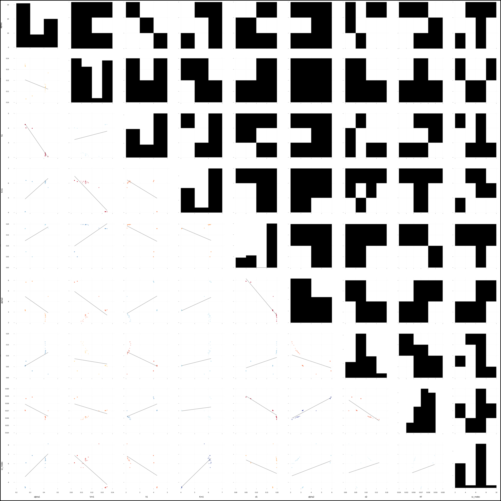

In [54]:
# Again, do not expect good results. Not even decent ones ;) 
# Also, you will not see much due to the high number of parameters. For a better look go to the actual file. 
PO1 = load(string("Results\\",model_def["NameF"],"_",today(),"\\PosteriorPlots_",bayinf_def["flag"],".png"))

And now the experiments

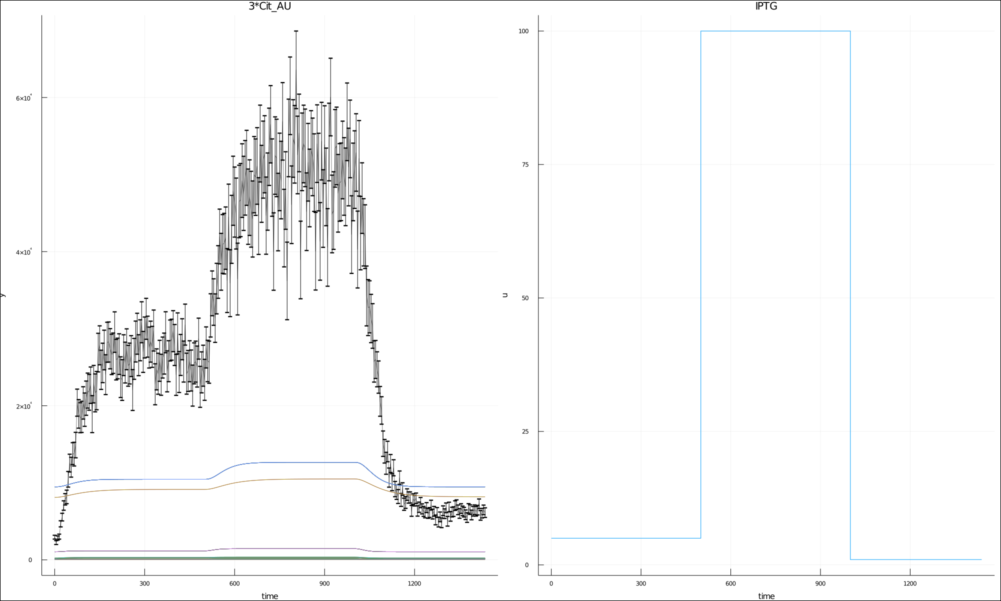

In [55]:
ex1 = load(string("Results\\",model_def["NameF"],"_",today(),"\\PlotStanInfResults_Exp",1,"_",bayinf_def["flag"],".png"))

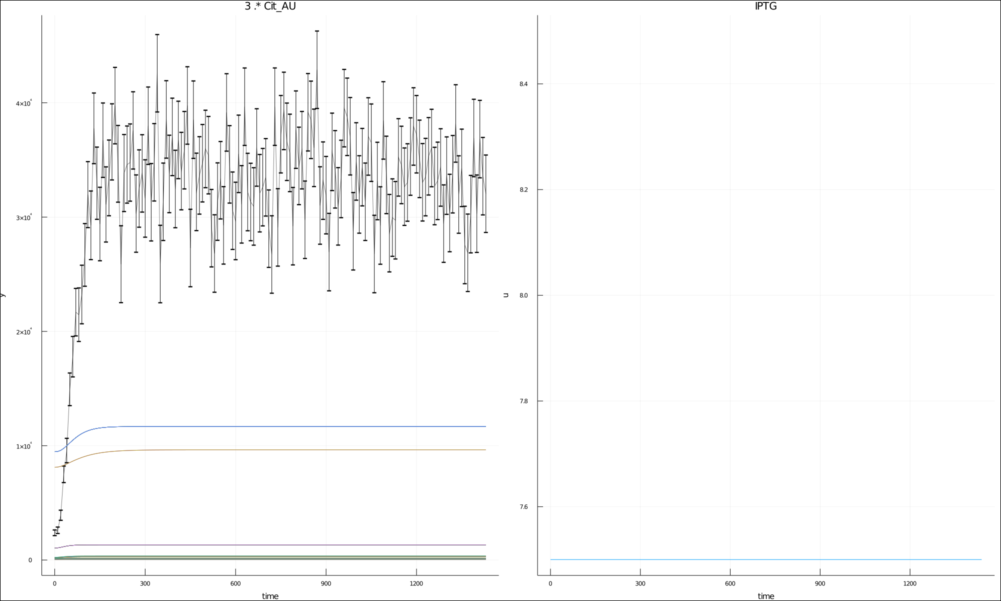

In [56]:
ex2 = load(string("Results\\",model_def["NameF"],"_",today(),"\\PlotStanInfResults_Exp",2,"_",bayinf_def["flag"],".png"))

# Stan Inference Example 3 --- EXTRA!
### Priors Sampling and Entropy Approximation

#### You can easily get samples from the priors you specify in the Stan model section (if these are correct) that you define in the bayinf_def["Priors"]
Let's have a look at how to do so. <br>
First, make sure you have the correct contents in the dictionary (an array of strings containing the information about the priors). The rest of the fields can be empty (except for the model)

In [57]:
bayinf_def["Priors"]["pars"]

9-element Array{String,1}:
 "real<lower=-2,upper=2> alpha1; \n"
 "real<lower=-2,upper=2> Vm1; \n"
 "real<lower=-2,upper=2> h1; \n"
 "real<lower=-2,upper=2> Km1; \n"
 "real<lower=-2,upper=2> d1; \n"
 "real<lower=-2,upper=2> alpha2; \n"
 "real<lower=-2,upper=2> d2; \n"
 "real<lower=-2,upper=2> Kf; \n"
 "real<lower=-2,upper=2> sc_molec; \n"

In [58]:
bayinf_def["Priors"]["transpars"]

10-element Array{String,1}:
 "real theta[nParms]; \n"
 "theta[1] = ((alpha1)*(0.1237403))+0.2475194; \n"
 "theta[2] = ((Vm1)*(0.11405))+0.2669; \n"
 "theta[3] = ((h1)*(1.1))+2.7; \n"
 "theta[4] = ((Km1)*(2.0))+6.0; \n"
 "theta[5] = ((d1)*(0.055575))+0.11885000000000001; \n"
 "theta[6] = ((alpha2)*(1.6408500000000001))+3.525; \n"
 "theta[7] = ((d2)*(0.06121005))+0.1224799; \n"
 "theta[8] = ((Kf)*(0.002425))+0.01685; \n"
 "theta[9] = ((sc_molec)*(2.49975))+5.0005; \n"

In [59]:
bayinf_def["Priors"]["pridis"]

9-element Array{String,1}:
 "alpha1 ~ normal(0,1); \n"
 "Vm1 ~ normal(0,1); \n"
 "h1 ~ normal(0,1); \n"
 "Km1 ~ normal(0,1); \n"
 "d1 ~ normal(0,1); \n"
 "alpha2 ~ normal(0,1); \n"
 "d2 ~ normal(0,1); \n"
 "Kf ~ normal(0,1); \n"
 "sc_molec ~ normal(0,1); \n"

Now you just need to call the function genSamplesPrior. <br>
The first argument is the model_def structure, the second the bayinf_def structure (only the Priors field is important) and the third is the number of samples you want for the parameters (let's choose 10000 for now)

In [60]:
ps = genSamplesPrior(model_def, bayinf_def, 10000)

-------------------------------------- WARNING --------------------------------------
This function will only work if the contents from bayinf_def["Priors"]["pridis"] are
distributions wiht numbers defined in the parameters. If the parameters given to the 
distributions are variables instead of numbers an error will be prompted since sampling will
not work. So no hierarchical priors. Sorry for the inconvenience. 
 
The only exception is the multivariate normal case where you can introduce the mean vector
and the covariance matrix as 4th and 5th arguments in the function in this order.
However, truncations will not be possible and only 1 MultiVariate normal can be assessed. 

Also, sampling from all types of stan distributions is not implemnted yet. For now the 
available options are: 
lognormal, normal, uniform, bernoulli, binomial, neg_binomial, poisson, student_t, cauchy, double_exponential, gumbel, chi_square, exponential, gamma, weibull, frechet, rayleigh, pareto, beta, von_mises, 

10000×9 Array{Float64,2}:
 0.252726   0.090562   0.696068  3.75185  …  0.108327    0.0171374  4.00119
 0.115686   0.152255   1.47961   4.72723     0.170683    0.0140586  0.825681
 0.177801   0.13195    4.07542   7.42497     0.0558432   0.0167402  2.90669
 0.267944   0.377779   1.84696   6.32774     0.146986    0.0206229  2.54342
 0.322051   0.0796352  1.72418   7.34887     0.121314    0.017114   1.32997
 0.423183   0.215257   1.55563   6.09579  …  0.202583    0.0205491  8.89961
 0.22109    0.250062   3.62632   7.96311     0.160076    0.0124726  4.6743
 0.0827402  0.266091   2.98812   5.56333     0.10064     0.0161945  3.67988
 0.385907   0.471489   2.15992   3.26872     0.101459    0.0163446  7.05707
 0.214602   0.424958   3.01913   9.0746      0.03646     0.0140862  6.95781
 0.446039   0.116579   3.93205   8.12563  …  0.156272    0.0166898  4.77752
 0.30192    0.391631   1.83217   6.37168     0.119808    0.0193003  8.25611
 0.209713   0.457699   2.43585   7.18411     0.045526    0.017

Really easy, and the function also prints some important information!

#### Fit prior samples and obtain the stan model
Before we showed that there is an option to fit your samples to a series of distribution types or a multi-variate Gaussian. <br>
If you would like to use the functions that perform the fit, these are called fitPriorSamps and fitPriorSampsMultiNorm. <br>
Here you can see an example of how to use them (really easy!)

In [61]:
priorfit1 = fitPriorSamps(ps, model_def)

Dict{Any,Any} with 3 entries:
  "transpars" => ["real theta[nParms]; \n", "theta[1] = (((alpha1)*(0.109085005…
  "pars"      => ["real alpha1; \n", "real Vm1; \n", "real h1; \n", "real Km1; …
  "pridis"    => ["alpha1 ~ normal(0, 1); \n", "Vm1 ~ normal(0, 1); \n", "h1 ~ …

In [62]:
priorfit1["pars"]

9-element Array{String,1}:
 "real alpha1; \n"
 "real Vm1; \n"
 "real h1; \n"
 "real Km1; \n"
 "real d1; \n"
 "real alpha2; \n"
 "real d2; \n"
 "real Kf; \n"
 "real sc_molec; \n"

In [63]:
priorfit1["pridis"]

9-element Array{String,1}:
 "alpha1 ~ normal(0, 1); \n"
 "Vm1 ~ normal(0, 1); \n"
 "h1 ~ normal(0, 1); \n"
 "Km1 ~ normal(0, 1); \n"
 "d1 ~ normal(0, 1); \n"
 "alpha2 ~ normal(0, 1); \n"
 "d2 ~ normal(0, 1); \n"
 "Kf ~ normal(0, 1); \n"
 "sc_molec ~ normal(0, 1); \n"

In [64]:
priorfit1["transpars"]

10-element Array{String,1}:
 "real theta[nParms]; \n"
 "theta[1] = (((alpha1)*(0.10908500575458559))+(0.24753101561923513)); \n"
 "theta[2] = (((Vm1)*(0.10032710765779568))+(0.2669171128855012)); \n"
 "theta[3] = (((h1)*(0.9716910132068026))+(2.698256060241388)); \n"
 "theta[4] = (((Km1)*(1.754283973415574))+(6.0150373490832925)); \n"
 "theta[5] = (((d1)*(0.04890844715669244))+(0.11885273872706337)); \n"
 "theta[6] = (((alpha2)*(1.439768962120467))+(3.5315184829277495)); \n"
 "theta[7] = (((d2)*(0.053795121132557425))+(0.1232355811679575)); \n"
 "theta[8] = (((Kf)*(0.002118655549736607))+(0.016837047339824624)); \n"
 "theta[9] = (((sc_molec)*(2.205696037115132))+(5.039990815505954)); \n"

In [65]:
using KernelDensity
using Plots

We are using the first parameter as example, copying and pasting the parameter values. This might be slightly different for you since it depends on the random sampling performed before. Just copy and paste your parameters to check for yourself

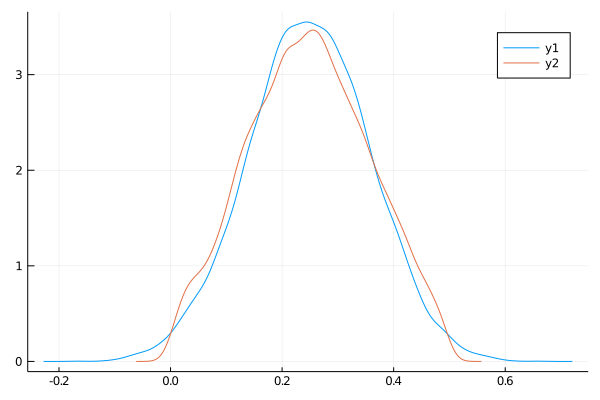

In [66]:
alpha1 = rand(Normal(0, 1), 10000);
theta1 = (((alpha1).*(0.10897838667360954)).+(0.24765788679040143));
ks1 = kde(theta1);
ks2 = kde(ps[:,1]);
plot(ks1.x, ks1.density)
plot!(ks2.x, ks2.density)

If you want to fit a multivariate normal distribution, then the function you need to use is: 

In [67]:
priorfit2 = fitPriorSampsMultiNorm(ps, model_def)

Dict{Any,Any} with 6 entries:
  "transpars" => ["real theta[nParms]; \n", "theta[1] = (((theta2[1])*(0.109090…
  "mera"      => [-5.25802e-17, -2.27374e-17, -3.55982e-16, 4.68958e-17, 4.6895…
  "cora"      => [1.0 0.00316837 … -0.0214581 -0.0018211; 0.00316837 1.0 … 0.00…
  "pars"      => ["vector[nParms-0] theta2; \n"]
  "pridis"    => ["theta2 ~ multi_normal(mera,cora); \n"]
  "numN"      => 9

In [68]:
priorfit2["pars"]

1-element Array{String,1}:
 "vector[nParms-0] theta2; \n"

In [69]:
priorfit2["pridis"]

1-element Array{String,1}:
 "theta2 ~ multi_normal(mera,cora); \n"

In [70]:
priorfit2["transpars"]

10-element Array{String,1}:
 "real theta[nParms]; \n"
 "theta[1] = (((theta2[1])*(0.10909046041397624))+(0.24753101561923452)); \n"
 "theta[2] = (((theta2[2])*(0.1003321243894367))+(0.2669171128855008)); \n"
 "theta[3] = (((theta2[3])*(0.9717396014016066))+(2.698256060241387)); \n"
 "theta[4] = (((theta2[4])*(1.75437169419336))+(6.015037349083295)); \n"
 "theta[5] = (((theta2[5])*(0.048910892762472305))+(0.11885273872706344)); \n"
 "theta[6] = (((theta2[6])*(1.4398409559681575))+(3.5315184829277615)); \n"
 "theta[7] = (((theta2[7])*(0.053797811090362545))+(0.12323558116795794)); \n"
 "theta[8] = (((theta2[8])*(0.0021187614904597174))+(0.01683704733982465)); \n"
 "theta[9] = (((theta2[9])*(2.2058063301890334))+(5.039990815505957)); \n"

Same as before, the parameters taken have been copied and pasted. Here we are just gonna plot the first 2 parameters.

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\Plots\3INZP\src\backends\gr.jl:491


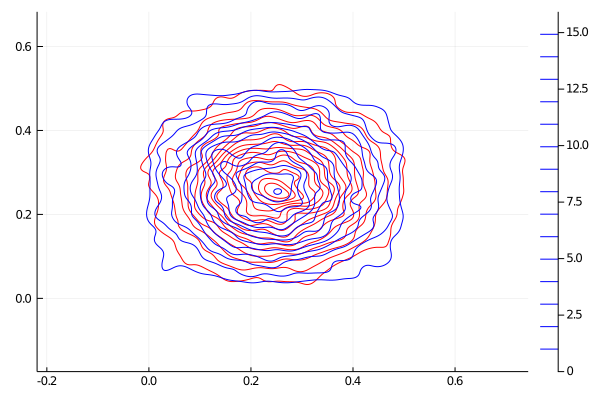

┌ Warning: Multiple series with different line color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\Plots\3INZP\src\backends\gr.jl:491


In [71]:
theta2 = rand(MvNormal(priorfit2["mera"], priorfit2["cora"]), 10000);
thetaA = (((theta2[1,:]).*(0.1089838360016464)).+(0.24765788679040163));
thetaB = (((theta2[2,:]).*(0.09996210927697048)).+(0.2670415872109178));
ks1 = kde(hcat(thetaA, thetaB));
ks2 = kde(ps[:,1:2]);
plot(ks1, color = "red")
plot!(ks2, color = "blue")

### Compute an approximation of the entropy for the samples
Approximation used explained in: David GC et al,  Information content analysis reveals desirable aspects of in vivo experiments of a synthetic circuit, CIBCB<br> 
<br> 
Using the approximation of entropy from Gaussian Mixture Models from "On Entropy Approximation for Gaussian Mixture Random Vectors"

We have made easy the use of this entropy approximation, by only using one simple function, computeH, where the inputs you have to give are the samples, the model_def structure and a string containing an identifier for the saved files. 

In [72]:
entro_res = computeH(ps, model_def, "prior")

┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.472896e+04
      1       1.787214e+04      -1.685682e+04 |        2
      2       1.772754e+04      -1.446022e+02 |        2
      3       1.765608e+04      -7.145866e+01 |        2
      4       1.759776e+04      -5.832500e+01 |        2
      5       1.752533e+04      -7.242385e+01 |        2
      6       1.740273e+04      -1.226044e+02 |        2
      7       1.714934e+04      -2.533852e+02 |        2
      8       1.677283e+04      -3.765161e+02 |        2
      9       1.611507e+04      -6.577605e+02 |        2
     10       1.552033e+04      -5.947397e+02 |        2
     11       1.529861e+04      -2.217214e+02 |        2
     12       1.521339e+04      -8.521400e+01 |        2
     13       1.518502e+04      -2.837241e+01 |        2
     14       1.517840e+04      -6.616920e+00 |        2
     15       1.517471e+04      -3.695143e+00 |        

┌ Info: K-means with 2000 data points using 18 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.231372e+04
      1       1.611785e+04      -6.195872e+03 |        2
      2       1.555566e+04      -5.621844e+02 |        2
      3       1.530310e+04      -2.525596e+02 |        2
      4       1.522304e+04      -8.006890e+01 |        2
      5       1.520860e+04      -1.444058e+01 |        2
      6       1.520531e+04      -3.286377e+00 |        2
      7       1.520426e+04      -1.046982e+00 |        2
      8       1.520403e+04      -2.341054e-01 |        2
      9       1.520400e+04      -2.788212e-02 |        2
     10       1.520396e+04      -4.240837e-02 |        2
     11       1.520387e+04      -8.910455e-02 |        2
     12       1.520380e+04      -6.584556e-02 |        2
     13       1.520378e+04      -2.395809e-02 |        0
     14       1.520378e+04       0.000000e+00 |        0
K-means converged with 14 iterations (objv = 15203.7784

┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.204607e+04
      1       1.716714e+04      -4.878922e+03 |        2
      2       1.617531e+04      -9.918371e+02 |        2
      3       1.588006e+04      -2.952465e+02 |        2
      4       1.579627e+04      -8.378895e+01 |        2
      5       1.577305e+04      -2.321952e+01 |        2
      6       1.576438e+04      -8.675569e+00 |        2
      7       1.576317e+04      -1.208411e+00 |        2
      8       1.576303e+04      -1.377976e-01 |        2
      9       1.576288e+04      -1.509912e-01 |        2
     10       1.576286e+04      -1.711493e-02 |        0
     11       1.576286e+04       0.000000e+00 |        0
K-means converged with 11 iterations (objv = 15762.862932974429)


┌ Info: K-means with 2000 data points using 14 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.617279e+04
      1       2.103247e+04      -5.140323e+03 |        3
      2       2.009056e+04      -9.419077e+02 |        3
      3       1.956191e+04      -5.286441e+02 |        3
      4       1.921729e+04      -3.446204e+02 |        3
      5       1.908046e+04      -1.368340e+02 |        3
      6       1.903266e+04      -4.779939e+01 |        3
      7       1.902006e+04      -1.259723e+01 |        3
      8       1.901432e+04      -5.740139e+00 |        3
      9       1.900917e+04      -5.154322e+00 |        3
     10       1.900672e+04      -2.451457e+00 |        3
     11       1.900454e+04      -2.174018e+00 |        3
     12       1.900334e+04      -1.204346e+00 |        3
     13       1.900173e+04      -1.609856e+00 |        3
     14       1.899968e+04      -2.049174e+00 |        3
     15       1.899749e+04      -2.186781e+00 |        

┌ Info: K-means with 2000 data points using 11 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 3000 data points using 30 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.806957e+04
      1       2.095337e+04      -7.116201e+03 |        3
      2       1.959602e+04      -1.357353e+03 |        3
      3       1.923201e+04      -3.640068e+02 |        3
      4       1.911558e+04      -1.164294e+02 |        3
      5       1.908048e+04      -3.509761e+01 |        3
      6       1.906532e+04      -1.516502e+01 |        3
      7       1.905312e+04      -1.220062e+01 |        3
      8       1.904375e+04      -9.370062e+00 |        3
      9       1.903930e+04      -4.447817e+00 |        3
     10       1.903662e+04      -2.679014e+00 |        3
     11       1.903350e+04      -3.123073e+00 |        3
     12       1.903080e+04      -2.703060e+00 |        3
     13       1.902804e+04      -2.750928e+00 |        3
     14       1.902617e+04      -1.869848e+00 |        3
     15       1.902153e+04      -4.644498e+00 |        

┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.212344e+04
      1       2.143301e+04      -1.069043e+04 |        3
      2       2.020413e+04      -1.228878e+03 |        3
      3       1.980021e+04      -4.039232e+02 |        3
      4       1.963216e+04      -1.680510e+02 |        3
      5       1.956873e+04      -6.342294e+01 |        3
      6       1.953749e+04      -3.123956e+01 |        3
      7       1.951997e+04      -1.752000e+01 |        3
      8       1.951388e+04      -6.092047e+00 |        3
      9       1.951149e+04      -2.388591e+00 |        3
     10       1.951051e+04      -9.840964e-01 |        3
     11       1.950985e+04      -6.563955e-01 |        3
     12       1.950942e+04      -4.320050e-01 |        3
     13       1.950888e+04      -5.365698e-01 |        3
     14       1.950867e+04      -2.158908e-01 |        3
     15       1.950861e+04      -5.565072e-02 |        

┌ Info: K-means with 3000 data points using 28 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 3000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.745765e+04
      1       2.468716e+04      -1.277049e+04 |        4
      2       2.378156e+04      -9.056087e+02 |        4
      3       2.353845e+04      -2.431014e+02 |        4
      4       2.346749e+04      -7.096575e+01 |        4
      5       2.343344e+04      -3.405100e+01 |        4
      6       2.340760e+04      -2.583759e+01 |        4
      7       2.338295e+04      -2.465545e+01 |        4
      8       2.333175e+04      -5.119023e+01 |        4
      9       2.325856e+04      -7.319143e+01 |        4
     10       2.315969e+04      -9.887758e+01 |        4
     11       2.307253e+04      -8.715257e+01 |        4
     12       2.299762e+04      -7.491031e+01 |        4
     13       2.292165e+04      -7.597258e+01 |        4
     14       2.286366e+04      -5.799414e+01 |        4
     15       2.281475e+04      -4.891005e+01 |        

┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     43       2.263646e+04      -2.635750e+00 |        4
     44       2.263179e+04      -4.670093e+00 |        4
     45       2.262396e+04      -7.829610e+00 |        4
     46       2.261403e+04      -9.930009e+00 |        4
     47       2.259832e+04      -1.570498e+01 |        4
     48       2.258030e+04      -1.802098e+01 |        4
     49       2.256708e+04      -1.322677e+01 |        4
     50       2.255374e+04      -1.333497e+01 |        4
K-means terminated without convergence after 50 iterations (objv = 22553.741081677974)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.677606e+04
      1       2.476358e+04      -1.201248e+04 |        4
      2       2.371129e+04      -1.052286e+03 |        4
      3       2.333040e+04      -3.808954e+02 |        4
      4       2.313717e+04      -1.932227e+02 |        4
      5       2.300368e+04      -1.334910e+02 |        4
      6       2.285321e+

┌ Info: K-means with 4000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 4000 data points using 22 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.230408e+04
      1       2.505031e+04      -7.253772e+03 |        4
      2       2.334835e+04      -1.701961e+03 |        4
      3       2.286181e+04      -4.865364e+02 |        4
      4       2.268426e+04      -1.775501e+02 |        4
      5       2.262543e+04      -5.882881e+01 |        4
      6       2.260378e+04      -2.165293e+01 |        4
      7       2.259803e+04      -5.746010e+00 |        4
      8       2.259488e+04      -3.153555e+00 |        4
      9       2.259361e+04      -1.274065e+00 |        4
     10       2.259267e+04      -9.327751e-01 |        4
     11       2.259207e+04      -6.030675e-01 |        4
     12       2.259129e+04      -7.855524e-01 |        4
     13       2.259050e+04      -7.830265e-01 |        4
     14       2.259010e+04      -4.058069e-01 |        4
     15       2.258984e+04      -2.569222e-01 |        

┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.713635e+04
      1       3.125945e+04      -1.587690e+04 |        5
      2       2.855269e+04      -2.706759e+03 |        5
      3       2.770949e+04      -8.432000e+02 |        5
      4       2.665389e+04      -1.055596e+03 |        5
      5       2.588056e+04      -7.733325e+02 |        5
      6       2.557031e+04      -3.102474e+02 |        5
      7       2.547264e+04      -9.767187e+01 |        5
      8       2.543461e+04      -3.803749e+01 |        5
      9       2.542112e+04      -1.348235e+01 |        5
     10       2.541568e+04      -5.442745e+00 |        5
     11       2.541377e+04      -1.906604e+00 |        5
     12       2.541321e+04      -5.627078e-01 |        5
     13       2.541259e+04      -6.240969e-01 |        5
     14       2.541192e+04      -6.652815e-01 |        5
     15       2.541085e+04      -1.076086e+00 |        

┌ Info: K-means with 4000 data points using 29 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.719422e+04
      1       2.848104e+04      -8.713178e+03 |        5
      2       2.680482e+04      -1.676227e+03 |        5
      3       2.613304e+04      -6.717770e+02 |        5
      4       2.585987e+04      -2.731641e+02 |        5
      5       2.574289e+04      -1.169888e+02 |        5
      6       2.568984e+04      -5.304072e+01 |        5
      7       2.566169e+04      -2.815164e+01 |        5
      8       2.564152e+04      -2.017180e+01 |        5
      9       2.563159e+04      -9.935417e+00 |        5
     10       2.562616e+04      -5.430155e+00 |        5
     11       2.562189e+04      -4.269544e+00 |        5
     12       2.561818e+04      -3.707189e+00 |        5
     13       2.561441e+04      -3.773825e+00 |        5
     14       2.561104e+04      -3.366329e+00 |        5
     15       2.560788e+04      -3.162894e+00 |        

┌ Info: K-means with 5000 data points using 43 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.269832e+04
      1       2.849802e+04      -1.420030e+04 |        5
      2       2.601474e+04      -2.483283e+03 |        5
      3       2.562220e+04      -3.925329e+02 |        5
      4       2.546313e+04      -1.590798e+02 |        5
      5       2.539239e+04      -7.073729e+01 |        5
      6       2.535982e+04      -3.257225e+01 |        5
      7       2.534957e+04      -1.024212e+01 |        5
      8       2.534249e+04      -7.083753e+00 |        5
      9       2.533631e+04      -6.175616e+00 |        5
     10       2.532992e+04      -6.397578e+00 |        5
     11       2.532556e+04      -4.356269e+00 |        5
     12       2.532210e+04      -3.458720e+00 |        5
     13       2.532084e+04      -1.261110e+00 |        5
     14       2.532060e+04      -2.446392e-01 |        4
     15       2.532031e+04      -2.896884e-01 |        

┌ Info: K-means with 5000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.664803e+04
      1       2.959816e+04      -7.049879e+03 |        6
      2       2.875807e+04      -8.400873e+02 |        6
      3       2.850279e+04      -2.552760e+02 |        6
      4       2.836937e+04      -1.334262e+02 |        6
      5       2.830997e+04      -5.939151e+01 |        6
      6       2.826898e+04      -4.099288e+01 |        6
      7       2.823953e+04      -2.945365e+01 |        6
      8       2.821686e+04      -2.266803e+01 |        6
      9       2.819403e+04      -2.283286e+01 |        6
     10       2.817832e+04      -1.570529e+01 |        6
     11       2.816664e+04      -1.167850e+01 |        6
     12       2.815516e+04      -1.148637e+01 |        6
     13       2.814625e+04      -8.906323e+00 |        6
     14       2.814047e+04      -5.780043e+00 |        6
     15       2.813438e+04      -6.092509e+00 |        

┌ Info: K-means with 5000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.549613e+04
      1       2.943027e+04      -6.065860e+03 |        6
      2       2.824793e+04      -1.182339e+03 |        6
      3       2.797876e+04      -2.691757e+02 |        6
      4       2.791131e+04      -6.745083e+01 |        6
      5       2.788965e+04      -2.165396e+01 |        6
      6       2.787510e+04      -1.455534e+01 |        6
      7       2.786629e+04      -8.808789e+00 |        6
      8       2.785815e+04      -8.140326e+00 |        6
      9       2.785097e+04      -7.177822e+00 |        6
     10       2.784253e+04      -8.436404e+00 |        6
     11       2.782485e+04      -1.768906e+01 |        6
     12       2.779852e+04      -2.632366e+01 |        6
     13       2.776215e+04      -3.637288e+01 |        6
     14       2.772514e+04      -3.701269e+01 |        6
     15       2.769193e+04      -3.320222e+01 |        

┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.883017e+04
      1       3.179032e+04      -1.703985e+04 |        6
      2       2.952639e+04      -2.263922e+03 |        6
      3       2.865354e+04      -8.728593e+02 |        6
      4       2.817611e+04      -4.774281e+02 |        6
      5       2.794165e+04      -2.344570e+02 |        6
      6       2.785234e+04      -8.931532e+01 |        6
      7       2.781107e+04      -4.126825e+01 |        6
      8       2.778470e+04      -2.636555e+01 |        6
      9       2.776402e+04      -2.067646e+01 |        6
     10       2.775020e+04      -1.382282e+01 |        6
     11       2.774502e+04      -5.182420e+00 |        6
     12       2.774176e+04      -3.254726e+00 |        6
     13       2.774022e+04      -1.544428e+00 |        6
     14       2.773899e+04      -1.228491e+00 |        6
     15       2.773732e+04      -1.671600e+00 |        

┌ Info: K-means with 6000 data points using 41 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6000 data points using 22 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       5.139222e+04
      1       3.472664e+04      -1.666558e+04 |        7
      2       3.241348e+04      -2.313159e+03 |        7
      3       3.128456e+04      -1.128917e+03 |        7
      4       3.050997e+04      -7.745912e+02 |        7
      5       3.000091e+04      -5.090644e+02 |        7
      6       2.970197e+04      -2.989355e+02 |        7
      7       2.951293e+04      -1.890434e+02 |        7
      8       2.939171e+04      -1.212159e+02 |        7
      9       2.930426e+04      -8.744727e+01 |        7
     10       2.924365e+04      -6.061240e+01 |        7
     11       2.919911e+04      -4.454395e+01 |        7
     12       2.915295e+04      -4.616047e+01 |        7
     13       2.911432e+04      -3.862218e+01 |        7
     14       2.907896e+04      -3.536724e+01 |        7
     15       2.904985e+04      -2.910983e+01 |        

┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  7
     36       2.883491e+04      -3.261786e+00 |        7
     37       2.883260e+04      -2.313972e+00 |        7
     38       2.883098e+04      -1.622300e+00 |        7
     39       2.882932e+04      -1.657044e+00 |        7
     40       2.882865e+04      -6.730459e-01 |        7
     41       2.882831e+04      -3.321298e-01 |        7
     42       2.882808e+04      -2.335538e-01 |        6
     43       2.882792e+04      -1.633079e-01 |        7
     44       2.882753e+04      -3.877923e-01 |        7
     45       2.882716e+04      -3.696687e-01 |        3
     46       2.882674e+04      -4.214560e-01 |        6
     47       2.882634e+04      -3.928974e-01 |        6
     48       2.882620e+04      -1.477196e-01 |        3
     49       2.882617e+04      -2.715355e-02 |        0
     50       2.882617e+04       0.000000e+00 |        0
K-means converged with 50 iterations (objv = 28826.169404867876)


┌ Info: K-means with 6666 data points using 50 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.927663e+04
      1       3.106640e+04      -8.210227e+03 |        7
      2       2.988387e+04      -1.182536e+03 |        7
      3       2.948818e+04      -3.956846e+02 |        7
      4       2.928082e+04      -2.073597e+02 |        7
      5       2.914710e+04      -1.337211e+02 |        7
      6       2.906379e+04      -8.331466e+01 |        7
      7       2.901322e+04      -5.057041e+01 |        7
      8       2.897926e+04      -3.395371e+01 |        7
      9       2.895121e+04      -2.805438e+01 |        7
     10       2.893294e+04      -1.826692e+01 |        7
     11       2.892180e+04      -1.113805e+01 |        7
     12       2.891171e+04      -1.009664e+01 |        7
     13       2.890659e+04      -5.116637e+00 |        7
     14       2.890319e+04      -3.400396e+00 |        7
     15       2.890101e+04      -2.182319e+00 |        

┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


4      -1.347544e+01 |        7
     33       2.881694e+04      -1.304910e+01 |        7
     34       2.880523e+04      -1.171292e+01 |        7
     35       2.878980e+04      -1.542906e+01 |        7
     36       2.877737e+04      -1.243319e+01 |        7
     37       2.876492e+04      -1.244581e+01 |        7
     38       2.875315e+04      -1.176563e+01 |        7
     39       2.874160e+04      -1.155029e+01 |        7
     40       2.872979e+04      -1.181793e+01 |        7
     41       2.872406e+04      -5.726309e+00 |        7
     42       2.871907e+04      -4.995038e+00 |        7
     43       2.871181e+04      -7.253762e+00 |        7
     44       2.870396e+04      -7.848935e+00 |        7
     45       2.869458e+04      -9.379758e+00 |        7
     46       2.868713e+04      -7.450020e+00 |        7
     47       2.868389e+04      -3.240289e+00 |        7
     48       2.868242e+04      -1.473742e+00 |        7
     49       2.868087e+04      -1.548396e+00 |        7

┌ Info: K-means with 6667 data points using 50 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 37 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.408198e+04
      1       3.083111e+04      -1.325086e+04 |        8
      2       2.955823e+04      -1.272884e+03 |        8
      3       2.882152e+04      -7.367062e+02 |        8
      4       2.821985e+04      -6.016715e+02 |        8
      5       2.784446e+04      -3.753903e+02 |        8
      6       2.758806e+04      -2.563982e+02 |        8
      7       2.742806e+04      -1.600058e+02 |        8
      8       2.734066e+04      -8.739613e+01 |        8
      9       2.729895e+04      -4.171570e+01 |        8
     10       2.726947e+04      -2.947220e+01 |        8
     11       2.724257e+04      -2.690225e+01 |        8
     12       2.722218e+04      -2.038677e+01 |        8
     13       2.720751e+04      -1.467562e+01 |        8
     14       2.719458e+04      -1.293360e+01 |        8
     15       2.718656e+04      -8.012868e+00 |        

┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


4      -1.974267e-01 |        2
     46       2.713849e+04      -1.787023e-01 |        3
     47       2.713843e+04      -5.421392e-02 |        5
     48       2.713835e+04      -8.285501e-02 |        3
     49       2.713831e+04      -3.922554e-02 |        0
     50       2.713831e+04       0.000000e+00 |        0
K-means converged with 50 iterations (objv = 27138.30920736448)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.342330e+04
      1       3.031865e+04      -1.310465e+04 |        8
      2       2.847451e+04      -1.844139e+03 |        8
      3       2.793228e+04      -5.422268e+02 |        8
      4       2.768273e+04      -2.495474e+02 |        8
      5       2.753679e+04      -1.459422e+02 |        8
      6       2.746577e+04      -7.102121e+01 |        8
      7       2.742918e+04      -3.659434e+01 |        8
      8       2.739520e+04      -3.397126e+01 |        8
      9       2.

┌ Info: K-means with 6666 data points using 50 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.114185e+04
      1       3.141551e+04      -9.726341e+03 |        8
      2       2.892665e+04      -2.488855e+03 |        8
      3       2.804017e+04      -8.864815e+02 |        8
      4       2.747931e+04      -5.608570e+02 |        8
      5       2.715761e+04      -3.217046e+02 |        8
      6       2.698320e+04      -1.744113e+02 |        8
      7       2.688903e+04      -9.416928e+01 |        8
      8       2.684087e+04      -4.815366e+01 |        8
      9       2.682229e+04      -1.858255e+01 |        8
     10       2.680919e+04      -1.310082e+01 |        8
     11       2.680011e+04      -9.081123e+00 |        8
     12       2.679268e+04      -7.431746e+00 |        8
     13       2.678642e+04      -6.253170e+00 |        8
     14       2.678312e+04      -3.307642e+00 |        8
     15       2.678155e+04      -1.562135e+00 |        

┌ Info: K-means with 6667 data points using 50 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 24 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.807845e+04
      1       2.800640e+04      -1.007205e+04 |        9
      2       2.663074e+04      -1.375662e+03 |        9
      3       2.610743e+04      -5.233131e+02 |        9
      4       2.589486e+04      -2.125714e+02 |        9
      5       2.581309e+04      -8.176798e+01 |        9
      6       2.577410e+04      -3.898781e+01 |        9
      7       2.573678e+04      -3.732486e+01 |        9
      8       2.570441e+04      -3.236791e+01 |        9
      9       2.567537e+04      -2.903724e+01 |        9
     10       2.564662e+04      -2.875521e+01 |        9
     11       2.562153e+04      -2.508613e+01 |        9
     12       2.560035e+04      -2.117652e+01 |        9
     13       2.558449e+04      -1.586026e+01 |        9
     14       2.556833e+04      -1.616585e+01 |        9
     15       2.555188e+04      -1.644831e+01 |        

┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  2.529889e+04      -8.674457e+00 |        9
     32       2.529216e+04      -6.729490e+00 |        9
     33       2.528671e+04      -5.450469e+00 |        9
     34       2.528160e+04      -5.109673e+00 |        8
     35       2.527814e+04      -3.463651e+00 |        9
     36       2.527528e+04      -2.858690e+00 |        8
     37       2.527259e+04      -2.691070e+00 |        9
     38       2.527034e+04      -2.243698e+00 |        9
     39       2.526826e+04      -2.084565e+00 |        8
     40       2.526660e+04      -1.659364e+00 |        8
     41       2.526600e+04      -5.987312e-01 |        8
     42       2.526549e+04      -5.101768e-01 |        6
     43       2.526531e+04      -1.830229e-01 |        4
     44       2.526523e+04      -8.000941e-02 |        4
     45       2.526498e+04      -2.524524e-01 |        7
     46       2.526449e+04      -4.895387e-01 |        6
     47       2.526414e+04      -3.494356e-01 |        7
     48       2.526390e+04      -2.365451e-

┌ Info: K-means with 6666 data points using 50 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.056500e+04
      1       2.973006e+04      -1.083494e+04 |        9
      2       2.752792e+04      -2.202135e+03 |        9
      3       2.650895e+04      -1.018977e+03 |        9
      4       2.613247e+04      -3.764793e+02 |        9
      5       2.595584e+04      -1.766240e+02 |        9
      6       2.585300e+04      -1.028422e+02 |        9
      7       2.578477e+04      -6.822962e+01 |        9
      8       2.573396e+04      -5.081498e+01 |        9
      9       2.568818e+04      -4.577723e+01 |        9
     10       2.563771e+04      -5.046861e+01 |        9
     11       2.560135e+04      -3.635689e+01 |        9
     12       2.556241e+04      -3.894285e+01 |        9
     13       2.552292e+04      -3.949118e+01 |        9
     14       2.548673e+04      -3.618954e+01 |        9
     15       2.545940e+04      -2.732484e+01 |        

┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    21       2.530977e+04      -1.807065e+01 |        9
     22       2.528641e+04      -2.336421e+01 |        9
     23       2.526984e+04      -1.657211e+01 |        9
     24       2.525843e+04      -1.140939e+01 |        9
     25       2.524612e+04      -1.230383e+01 |        9
     26       2.523674e+04      -9.384933e+00 |        8
     27       2.523107e+04      -5.667099e+00 |        9
     28       2.522581e+04      -5.259300e+00 |        9
     29       2.522127e+04      -4.537412e+00 |        9
     30       2.521660e+04      -4.675474e+00 |        9
     31       2.521268e+04      -3.920824e+00 |        9
     32       2.520977e+04      -2.904251e+00 |        9
     33       2.520668e+04      -3.090828e+00 |        9
     34       2.520095e+04      -5.730425e+00 |        9
     35       2.519653e+04      -4.417046e+00 |        9
     36       2.519401e+04      -2.521507e+00 |        9
     37       2.519253e+04      -1.486270e+00 |        9
     38       2.518965e+04      

┌ Info: K-means with 6667 data points using 50 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.444331e+04
      1       2.829804e+04      -6.145263e+03 |        9
      2       2.691404e+04      -1.384003e+03 |        9
      3       2.628100e+04      -6.330359e+02 |        9
      4       2.602033e+04      -2.606753e+02 |        9
      5       2.585384e+04      -1.664859e+02 |        9
      6       2.575544e+04      -9.840045e+01 |        9
      7       2.568219e+04      -7.325564e+01 |        9
      8       2.564212e+04      -4.007061e+01 |        9
      9       2.561208e+04      -3.003667e+01 |        9
     10       2.558708e+04      -2.499883e+01 |        9
     11       2.555922e+04      -2.786233e+01 |        9
     12       2.552827e+04      -3.094639e+01 |        9
     13       2.548833e+04      -3.994354e+01 |        9
     14       2.545434e+04      -3.399153e+01 |        9
     15       2.542133e+04      -3.300492e+01 |        

┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     36       2.530066e+04      -2.618540e+00 |        9
     37       2.529895e+04      -1.706158e+00 |        8
     38       2.529720e+04      -1.756825e+00 |        7
     39       2.529487e+04      -2.326787e+00 |        9
     40       2.529326e+04      -1.604230e+00 |        9
     41       2.529143e+04      -1.837325e+00 |        9
     42       2.528939e+04      -2.033865e+00 |        8
     43       2.528705e+04      -2.345462e+00 |        9
     44       2.528522e+04      -1.827867e+00 |        9
     45       2.528353e+04      -1.693172e+00 |        9
     46       2.528175e+04      -1.774419e+00 |        8
     47       2.527948e+04      -2.271344e+00 |        9
     48       2.527583e+04      -3.648534e+00 |        9
     49       2.527150e+04      -4.334472e+00 |        9
     50       2.526648e+04      -5.016782e+00 |        9
K-means terminated without convergence after 50 iterations (objv = 25266.48150254325)


┌ Info: K-means with 6667 data points using 50 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.401789e+04
      1       2.741870e+04      -6.599192e+03 |       10
      2       2.622074e+04      -1.197961e+03 |       10
      3       2.559072e+04      -6.300122e+02 |       10
      4       2.527401e+04      -3.167189e+02 |       10
      5       2.509913e+04      -1.748751e+02 |       10
      6       2.497788e+04      -1.212486e+02 |       10
      7       2.487432e+04      -1.035663e+02 |       10
      8       2.477747e+04      -9.684694e+01 |       10
      9       2.466815e+04      -1.093185e+02 |       10
     10       2.456956e+04      -9.859132e+01 |       10
     11       2.449882e+04      -7.073445e+01 |       10
     12       2.444975e+04      -4.907307e+01 |       10
     13       2.441483e+04      -3.491939e+01 |       10
     14       2.438852e+04      -2.631017e+01 |       10
     15       2.436846e+04      -2.006355e+01 |       1

┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     35       2.425979e+04      -2.602328e+00 |       10
     36       2.425739e+04      -2.407536e+00 |       10
     37       2.425515e+04      -2.235965e+00 |       10
     38       2.425300e+04      -2.154012e+00 |       10
     39       2.425115e+04      -1.844432e+00 |       10
     40       2.424869e+04      -2.459877e+00 |       10
     41       2.424724e+04      -1.447906e+00 |       10
     42       2.424607e+04      -1.179092e+00 |       10
     43       2.424393e+04      -2.138601e+00 |       10
     44       2.424087e+04      -3.059064e+00 |        9
     45       2.423846e+04      -2.403551e+00 |       10
     46       2.423437e+04      -4.090788e+00 |       10
     47       2.423070e+04      -3.670220e+00 |       10
     48       2.422809e+04      -2.612619e+00 |       10
     49       2.422489e+04      -3.203543e+00 |       10
     50       2.422176e+04      -3.124037e+00 |        9
K-means terminated without convergence after 50 iterations (objv = 24221.76317215581)


┌ Info: K-means with 6666 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.334224e+04
      1       2.714524e+04      -6.197000e+03 |       10
      2       2.581383e+04      -1.331402e+03 |       10
      3       2.525799e+04      -5.558472e+02 |       10
      4       2.493784e+04      -3.201474e+02 |       10
      5       2.475083e+04      -1.870068e+02 |       10
      6       2.463280e+04      -1.180366e+02 |       10
      7       2.456667e+04      -6.612593e+01 |       10
      8       2.452148e+04      -4.519366e+01 |       10
      9       2.448775e+04      -3.372093e+01 |       10
     10       2.445628e+04      -3.147904e+01 |       10
     11       2.443482e+04      -2.145445e+01 |       10
     12       2.441989e+04      -1.493052e+01 |       10
     13       2.440925e+04      -1.064414e+01 |       10
     14       2.440126e+04      -7.985241e+00 |       10
     15       2.439338e+04      -7.885241e+00 |       1

┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


e+00 |       10
     48       2.431960e+04      -3.397524e+00 |       10
     49       2.431570e+04      -3.905485e+00 |       10
     50       2.431175e+04      -3.947972e+00 |       10
K-means terminated without convergence after 50 iterations (objv = 24311.74748032195)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.308224e+04
      1       2.630835e+04      -6.773892e+03 |       10
      2       2.530482e+04      -1.003533e+03 |       10
      3       2.494360e+04      -3.612220e+02 |       10
      4       2.477478e+04      -1.688133e+02 |       10
      5       2.465377e+04      -1.210081e+02 |       10
      6       2.455943e+04      -9.434823e+01 |       10
      7       2.448310e+04      -7.632292e+01 |       10
      8       2.442565e+04      -5.745118e+01 |       10
      9       2.438805e+04      -3.760230e+01 |       10
     10       2.436123e+04      -2.681830e+01 |       10
     11   

┌ Info: K-means with 6667 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.916318e+04
      1       2.662950e+04      -1.253368e+04 |       11
      2       2.509896e+04      -1.530543e+03 |       11
      3       2.433801e+04      -7.609504e+02 |       11
      4       2.403151e+04      -3.065006e+02 |       11
      5       2.384426e+04      -1.872517e+02 |       11
      6       2.371271e+04      -1.315447e+02 |       11
      7       2.363224e+04      -8.046951e+01 |       11
      8       2.357510e+04      -5.714133e+01 |       11
      9       2.352795e+04      -4.714933e+01 |       11
     10       2.349841e+04      -2.954024e+01 |       11
     11       2.347670e+04      -2.171562e+01 |       11
     12       2.345193e+04      -2.476043e+01 |       11
     13       2.343157e+04      -2.036016e+01 |       11
     14       2.341412e+04      -1.745800e+01 |       11
     15       2.339758e+04      -1.653638e+01 |       1

┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     48       2.304485e+04      -2.977901e-01 |        4
     49       2.304475e+04      -1.069786e-01 |        4
     50       2.304469e+04      -5.742864e-02 |        4
K-means terminated without convergence after 50 iterations (objv = 23044.687856749355)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.173151e+04
      1       2.598276e+04      -5.748747e+03 |       11
      2       2.498777e+04      -9.949911e+02 |       11
      3       2.451437e+04      -4.734045e+02 |       11
      4       2.419707e+04      -3.173034e+02 |       11
      5       2.398692e+04      -2.101485e+02 |       11
      6       2.382169e+04      -1.652308e+02 |       11
      7       2.370709e+04      -1.145918e+02 |       11
      8       2.361746e+04      -8.963812e+01 |       11
      9       2.356239e+04      -5.507003e+01 |       11
     10       2.352304e+04      -3.934618e+01 |       11
     11       2.348486e+

┌ Info: K-means with 6666 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.257116e+04
      1       2.668892e+04      -5.882246e+03 |       11
      2       2.526500e+04      -1.423918e+03 |       11
      3       2.460257e+04      -6.624291e+02 |       11
      4       2.423904e+04      -3.635270e+02 |       11
      5       2.400696e+04      -2.320849e+02 |       11
      6       2.380338e+04      -2.035812e+02 |       11
      7       2.359934e+04      -2.040336e+02 |       11
      8       2.343058e+04      -1.687666e+02 |       11
      9       2.329261e+04      -1.379685e+02 |       11
     10       2.320422e+04      -8.838765e+01 |       11
     11       2.315908e+04      -4.514093e+01 |       11
     12       2.312603e+04      -3.305007e+01 |       11
     13       2.310271e+04      -2.332457e+01 |       11
     14       2.308153e+04      -2.117102e+01 |       11
     15       2.306633e+04      -1.520715e+01 |       1

┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


01 |        8
     42       2.296048e+04      -7.693521e-01 |        9
     43       2.296010e+04      -3.783956e-01 |        7
     44       2.295993e+04      -1.731798e-01 |        5
     45       2.295960e+04      -3.313387e-01 |        6
     46       2.295924e+04      -3.598927e-01 |        5
     47       2.295837e+04      -8.698400e-01 |        8
     48       2.295787e+04      -4.942902e-01 |        6
     49       2.295753e+04      -3.400275e-01 |        3
     50       2.295743e+04      -1.086377e-01 |        2
K-means terminated without convergence after 50 iterations (objv = 22957.425138464867)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.273585e+04
      1       2.522533e+04      -7.510522e+03 |       12
      2       2.417261e+04      -1.052711e+03 |       12
      3       2.360785e+04      -5.647600e+02 |       12
      4       2.311180e+04      -4.960543e+02 |       12
      5    

┌ Info: K-means with 6667 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.216558e+04
      1       2.510925e+04      -7.056331e+03 |       12
      2       2.388720e+04      -1.222051e+03 |       12
      3       2.338794e+04      -4.992581e+02 |       12
      4       2.312548e+04      -2.624640e+02 |       12
      5       2.296819e+04      -1.572928e+02 |       12
      6       2.283925e+04      -1.289400e+02 |       12
      7       2.273562e+04      -1.036286e+02 |       12
      8       2.263146e+04      -1.041586e+02 |       12
      9       2.253833e+04      -9.312588e+01 |       12
     10       2.245465e+04      -8.367741e+01 |       12
     11       2.238457e+04      -7.008290e+01 |       12
     12       2.232067e+04      -6.390294e+01 |       12
     13       2.226102e+04      -5.964463e+01 |       12
     14       2.219319e+04      -6.783889e+01 |       12
     15       2.215451e+04      -3.867480e+01 |       1

┌ Info: K-means with 6666 data points using 33 iterations
│ 55.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.485990e+04
      1       2.528181e+04      -9.578092e+03 |       12
      2       2.399510e+04      -1.286711e+03 |       12
      3       2.343154e+04      -5.635604e+02 |       12
      4       2.309785e+04      -3.336844e+02 |       12
      5       2.288976e+04      -2.080928e+02 |       12
      6       2.276760e+04      -1.221603e+02 |       12
      7       2.267298e+04      -9.462000e+01 |       12
      8       2.260481e+04      -6.817007e+01 |       12
      9       2.256720e+04      -3.760914e+01 |       12
     10       2.254108e+04      -2.612172e+01 |       12
     11       2.251725e+04      -2.382608e+01 |       12
     12       2.249964e+04      -1.760849e+01 |       12
     13       2.248650e+04      -1.314394e+01 |       12
     14       2.247544e+04      -1.106088e+01 |       12
     15       2.246575e+04      -9.685711e+00 |       1

┌ Info: K-means with 6667 data points using 46 iterations
│ 55.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


147291e+00 |       11
     46       2.234010e+04      -8.523917e-01 |       11
     47       2.233878e+04      -1.320997e+00 |       10
     48       2.233754e+04      -1.235536e+00 |       10
     49       2.233670e+04      -8.414238e-01 |       11
     50       2.233588e+04      -8.250214e-01 |        7
K-means terminated without convergence after 50 iterations (objv = 22335.87761433538)


┌ Info: K-means with 6667 data points using 50 iterations
│ 55.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.039427e+04
      1       2.409213e+04      -6.302140e+03 |       13
      2       2.321040e+04      -8.817306e+02 |       13
      3       2.278750e+04      -4.229079e+02 |       13
      4       2.246637e+04      -3.211241e+02 |       13
      5       2.219703e+04      -2.693366e+02 |       13
      6       2.201085e+04      -1.861873e+02 |       13
      7       2.188473e+04      -1.261216e+02 |       13
      8       2.180700e+04      -7.772204e+01 |       13
      9       2.175910e+04      -4.790787e+01 |       13
     10       2.171768e+04      -4.141772e+01 |       13
     11       2.168041e+04      -3.727161e+01 |       13
     12       2.165479e+04      -2.561386e+01 |       13
     13       2.163370e+04      -2.109657e+01 |       13
     14       2.161445e+04      -1.924926e+01 |       13
     15       2.159769e+04      -1.676017e+01 |       1

┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     49       2.133695e+04      -1.136874e+00 |        9
     50       2.133599e+04      -9.546100e-01 |       11
K-means terminated without convergence after 50 iterations (objv = 21335.992649861906)


┌ Info: K-means with 6666 data points using 50 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.262151e+04
      1       2.353365e+04      -9.087857e+03 |       13
      2       2.249251e+04      -1.041135e+03 |       13
      3       2.205688e+04      -4.356369e+02 |       13
      4       2.184096e+04      -2.159148e+02 |       13
      5       2.172643e+04      -1.145369e+02 |       13
      6       2.166084e+04      -6.558545e+01 |       13
      7       2.162619e+04      -3.465019e+01 |       13
      8       2.160127e+04      -2.492295e+01 |       13
      9       2.157855e+04      -2.272001e+01 |       13
     10       2.156210e+04      -1.644793e+01 |       13
     11       2.155004e+04      -1.206205e+01 |       13
     12       2.153736e+04      -1.267638e+01 |       13
     13       2.151976e+04      -1.760251e+01 |       13
     14       2.150440e+04      -1.535615e+01 |       13
     15       2.149368e+04      -1.071970e+01 |       1

┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     47       2.141208e+04      -7.962960e-01 |        9
     48       2.141124e+04      -8.316512e-01 |       11
     49       2.140989e+04      -1.353514e+00 |       11
     50       2.140863e+04      -1.260788e+00 |        8
K-means terminated without convergence after 50 iterations (objv = 21408.62996997215)


┌ Info: K-means with 6667 data points using 50 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.353574e+04
      1       2.396221e+04      -9.573528e+03 |       13
      2       2.280989e+04      -1.152316e+03 |       13
      3       2.245641e+04      -3.534863e+02 |       13
      4       2.227258e+04      -1.838310e+02 |       13
      5       2.218158e+04      -9.099871e+01 |       13
      6       2.211417e+04      -6.740354e+01 |       13
      7       2.206536e+04      -4.881215e+01 |       13
      8       2.202843e+04      -3.693452e+01 |       13
      9       2.198604e+04      -4.239065e+01 |       13
     10       2.194371e+04      -4.232891e+01 |       13
     11       2.189001e+04      -5.370152e+01 |       13
     12       2.183154e+04      -5.846251e+01 |       13
     13       2.177726e+04      -5.428741e+01 |       13
     14       2.172994e+04      -4.731978e+01 |       13
     15       2.168894e+04      -4.099644e+01 |       1

┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


2.349794e+00 |       13
K-means terminated without convergence after 50 iterations (objv = 21466.574960424838)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.750065e+04
      1       2.343491e+04      -4.065744e+03 |       14
      2       2.263088e+04      -8.040289e+02 |       14
      3       2.226300e+04      -3.678737e+02 |       14
      4       2.203451e+04      -2.284980e+02 |       14
      5       2.184201e+04      -1.924994e+02 |       14
      6       2.166183e+04      -1.801760e+02 |       14
      7       2.151664e+04      -1.451860e+02 |       14
      8       2.139597e+04      -1.206697e+02 |       14
      9       2.130817e+04      -8.780792e+01 |       14
     10       2.124114e+04      -6.702686e+01 |       14
     11       2.118743e+04      -5.370985e+01 |       14
     12       2.114146e+04      -4.596747e+01 |       14
     13       2.109780e+04      -4.366492e+01 |       14
 

┌ Info: K-means with 6667 data points using 50 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


0 |       12
     48       2.084834e+04      -6.632024e-01 |       11
     49       2.084776e+04      -5.795260e-01 |        7
     50       2.084739e+04      -3.684203e-01 |        5
K-means terminated without convergence after 50 iterations (objv = 20847.388991843098)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.662213e+04
      1       2.322423e+04      -3.397908e+03 |       14
      2       2.242936e+04      -7.948678e+02 |       14
      3       2.208848e+04      -3.408795e+02 |       14
      4       2.190839e+04      -1.800897e+02 |       14
      5       2.176739e+04      -1.410021e+02 |       14
      6       2.166711e+04      -1.002791e+02 |       14
      7       2.158840e+04      -7.870847e+01 |       14
      8       2.152968e+04      -5.872093e+01 |       14
      9       2.148402e+04      -4.566037e+01 |       14
     10       2.144940e+04      -3.461631e+01 |       14
     11     

┌ Info: K-means with 6666 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    2.086167e+04      -1.046604e+00 |       14
K-means terminated without convergence after 50 iterations (objv = 20861.665125411622)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.160481e+04
      1       2.276514e+04      -8.839678e+03 |       14
      2       2.180494e+04      -9.601928e+02 |       14
      3       2.141039e+04      -3.945543e+02 |       14
      4       2.120873e+04      -2.016564e+02 |       14
      5       2.110266e+04      -1.060707e+02 |       14
      6       2.104755e+04      -5.511410e+01 |       14
      7       2.100928e+04      -3.826522e+01 |       14
      8       2.098031e+04      -2.897296e+01 |       14
      9       2.095543e+04      -2.487439e+01 |       14
     10       2.094057e+04      -1.486715e+01 |       14
     11       2.093055e+04      -1.002048e+01 |       14
     12       2.092249e+04      -8.057182e+00 |       14
     13       2.091431e+04      -8.

┌ Info: K-means with 6667 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   -1.713669e-01 |        7
     49       2.077679e+04      -2.267119e-01 |        6
     50       2.077631e+04      -4.815286e-01 |        7
K-means terminated without convergence after 50 iterations (objv = 20776.31346862782)


┌ Info: K-means with 6667 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.781842e+04
      1       2.272428e+04      -5.094141e+03 |       15
      2       2.172070e+04      -1.003579e+03 |       15
      3       2.132577e+04      -3.949328e+02 |       15
      4       2.108549e+04      -2.402757e+02 |       15
      5       2.089998e+04      -1.855101e+02 |       15
      6       2.075156e+04      -1.484196e+02 |       15
      7       2.061629e+04      -1.352695e+02 |       15
      8       2.052813e+04      -8.816547e+01 |       15
      9       2.046491e+04      -6.321718e+01 |       15
     10       2.042639e+04      -3.852011e+01 |       15
     11       2.040416e+04      -2.223259e+01 |       15
     12       2.038505e+04      -1.910471e+01 |       15
     13       2.036982e+04      -1.523471e+01 |       15
     14       2.035463e+04      -1.519124e+01 |       15
     15       2.033605e+04      -1.857965e+01 |       1

┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     40       2.009545e+04      -1.197207e-01 |        4
     41       2.009541e+04      -3.713115e-02 |        2
     42       2.009539e+04      -2.230613e-02 |        2
     43       2.009537e+04      -1.787547e-02 |        2
     44       2.009535e+04      -2.161953e-02 |        0
     45       2.009535e+04       0.000000e+00 |        0
K-means converged with 45 iterations (objv = 20095.349864542568)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.234768e+04
      1       2.236654e+04      -9.981141e+03 |       15
      2       2.129614e+04      -1.070400e+03 |       15
      3       2.098217e+04      -3.139711e+02 |       15
      4       2.081595e+04      -1.662185e+02 |       15
      5       2.070149e+04      -1.144621e+02 |       15
      6       2.061272e+04      -8.876697e+01 |       15
      7       2.054624e+04      -6.648286e+01 |       15
      8       2.049852e+04      -4.772084e+01 |

┌ Info: K-means with 6666 data points using 45 iterations
│ 44.4 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


0 |       12
     42       2.001742e+04      -4.021372e-01 |       10
     43       2.001686e+04      -5.606347e-01 |        8
     44       2.001670e+04      -1.624212e-01 |        8
     45       2.001649e+04      -2.045755e-01 |        4
     46       2.001633e+04      -1.606127e-01 |        4
     47       2.001619e+04      -1.437400e-01 |        4
     48       2.001616e+04      -2.555297e-02 |        0
     49       2.001616e+04       0.000000e+00 |        0
K-means converged with 49 iterations (objv = 20016.16321424833)


┌ Info: K-means with 6667 data points using 49 iterations
│ 44.4 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.034087e+04
      1       2.210158e+04      -8.239285e+03 |       15
      2       2.131317e+04      -7.884183e+02 |       15
      3       2.105588e+04      -2.572898e+02 |       15
      4       2.093645e+04      -1.194259e+02 |       15
      5       2.085063e+04      -8.581692e+01 |       15
      6       2.077742e+04      -7.320941e+01 |       15
      7       2.071211e+04      -6.531022e+01 |       15
      8       2.065090e+04      -6.121351e+01 |       15
      9       2.058536e+04      -6.553972e+01 |       15
     10       2.052606e+04      -5.929689e+01 |       15
     11       2.047780e+04      -4.825835e+01 |       15
     12       2.043116e+04      -4.664641e+01 |       15
     13       2.037386e+04      -5.729476e+01 |       15
     14       2.032388e+04      -4.998517e+01 |       15
     15       2.027726e+04      -4.662044e+01 |       1

┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.956007e+04
      1       2.305797e+04      -6.502107e+03 |       16
      2       2.147612e+04      -1.581844e+03 |       16
      3       2.082078e+04      -6.553467e+02 |       16
      4       2.045537e+04      -3.654109e+02 |       16
      5       2.023222e+04      -2.231447e+02 |       16
      6       2.005246e+04      -1.797641e+02 |       16
      7       1.988170e+04      -1.707542e+02 |       16
      8       1.976097e+04      -1.207355e+02 |       16
      9       1.967401e+04      -8.695768e+01 |       16
     10       1.961550e+04      -5.850618e+01 |       16
     11       1.956782e+04      -4.768188e+01 |       16
     12       1.953196e+04      -3.586239e+01 |       16
     13       1.950610e+04      -2.585818e+01 |       16
     14       1.948929e+04      -1.681239e+01 |       16
     15       1.947001e+04      -1.927541e+01 |       1

┌ Info: K-means with 6667 data points using 50 iterations
│ 44.4 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 16 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     44       1.935962e+04      -1.931452e-01 |        8
     45       1.935949e+04      -1.290311e-01 |        6
     46       1.935942e+04      -7.676816e-02 |        4
     47       1.935938e+04      -3.525880e-02 |        2
     48       1.935937e+04      -8.885530e-03 |        0
     49       1.935937e+04       0.000000e+00 |        0
K-means converged with 49 iterations (objv = 19359.372626973436)


┌ Info: K-means with 6666 data points using 49 iterations
│ 41.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.790095e+04
      1       2.213156e+04      -5.769397e+03 |       16
      2       2.102745e+04      -1.104105e+03 |       16
      3       2.058688e+04      -4.405688e+02 |       16
      4       2.039039e+04      -1.964963e+02 |       16
      5       2.028179e+04      -1.086002e+02 |       16
      6       2.020405e+04      -7.773582e+01 |       16
      7       2.014826e+04      -5.579268e+01 |       16
      8       2.009375e+04      -5.450783e+01 |       16
      9       2.004071e+04      -5.303632e+01 |       16
     10       1.999393e+04      -4.678118e+01 |       16
     11       1.995934e+04      -3.458866e+01 |       16
     12       1.992349e+04      -3.585097e+01 |       16
     13       1.988661e+04      -3.688584e+01 |       16
     14       1.985386e+04      -3.274630e+01 |       16
     15       1.982147e+04      -3.239244e+01 |       1

┌ Info: Initializing GMM, 16 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     41       1.948713e+04      -1.338131e+00 |       16
     42       1.948570e+04      -1.433133e+00 |       13
     43       1.948379e+04      -1.908214e+00 |       15
     44       1.948149e+04      -2.295264e+00 |       15
     45       1.947941e+04      -2.086030e+00 |       14
     46       1.947745e+04      -1.954040e+00 |       16
     47       1.947606e+04      -1.392966e+00 |       16
     48       1.947490e+04      -1.158176e+00 |       13
     49       1.947414e+04      -7.625472e-01 |       11
     50       1.947376e+04      -3.761966e-01 |       13
K-means terminated without convergence after 50 iterations (objv = 19473.764660849505)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.980241e+04
      1       2.292215e+04      -6.880265e+03 |       16
      2       2.144459e+04      -1.477555e+03 |       16
      3       2.084419e+04      -6.003981e+02 |       16
      4       2.051840e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 41.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 16 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


      1.972213e+04      -2.121288e-01 |        7
     49       1.972181e+04      -3.178889e-01 |        8
     50       1.972155e+04      -2.568138e-01 |        2
K-means terminated without convergence after 50 iterations (objv = 19721.55395615195)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.478715e+04
      1       2.126769e+04      -3.519452e+03 |       17
      2       2.035462e+04      -9.130753e+02 |       17
      3       1.994023e+04      -4.143909e+02 |       17
      4       1.969857e+04      -2.416621e+02 |       17
      5       1.954118e+04      -1.573813e+02 |       17
      6       1.944373e+04      -9.745343e+01 |       17
      7       1.938542e+04      -5.830782e+01 |       17
      8       1.935055e+04      -3.486904e+01 |       17
      9       1.932130e+04      -2.924871e+01 |       17
     10       1.930104e+04      -2.026848e+01 |       17
     11       1.928126e+04      -1

┌ Info: K-means with 6667 data points using 50 iterations
│ 41.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 17 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


      1.919120e+04      -8.934610e-01 |        9
     47       1.919006e+04      -1.143958e+00 |        8
     48       1.918837e+04      -1.693238e+00 |        7
     49       1.918567e+04      -2.693437e+00 |       10
     50       1.918003e+04      -5.646562e+00 |       12
K-means terminated without convergence after 50 iterations (objv = 19180.02570082499)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.783301e+04
      1       2.123581e+04      -6.597204e+03 |       17
      2       2.002507e+04      -1.210739e+03 |       17
      3       1.969275e+04      -3.323134e+02 |       17
      4       1.952848e+04      -1.642793e+02 |       17
      5       1.944039e+04      -8.808223e+01 |       17
      6       1.938561e+04      -5.478452e+01 |       17
      7       1.935318e+04      -3.242576e+01 |       17
      8       1.933183e+04      -2.135464e+01 |       17
      9       1.931005e+04      -2

┌ Info: K-means with 6666 data points using 50 iterations
│ 39.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 17 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


      16
     37       1.879291e+04      -2.546818e+00 |       15
     38       1.879128e+04      -1.629933e+00 |       13
     39       1.878972e+04      -1.559950e+00 |       14
     40       1.878766e+04      -2.059734e+00 |       17
     41       1.878558e+04      -2.088921e+00 |       15
     42       1.878399e+04      -1.586920e+00 |       11
     43       1.878317e+04      -8.150700e-01 |       12
     44       1.878251e+04      -6.689195e-01 |       14
     45       1.878189e+04      -6.139568e-01 |       11
     46       1.878139e+04      -5.002738e-01 |       14
     47       1.878068e+04      -7.137477e-01 |        8
     48       1.878022e+04      -4.572399e-01 |        4
     49       1.878004e+04      -1.805862e-01 |        6
     50       1.877991e+04      -1.310969e-01 |        7
K-means terminated without convergence after 50 iterations (objv = 18779.90822535022)
  Iters               objv        objv-change | affected 
-------------------------------------------------

┌ Info: K-means with 6667 data points using 50 iterations
│ 39.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 17 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


.910136e+04      -9.198684e+00 |       16
     25       1.909214e+04      -9.223895e+00 |       17
     26       1.908065e+04      -1.148680e+01 |       17
     27       1.907192e+04      -8.732378e+00 |       17
     28       1.906464e+04      -7.280098e+00 |       17
     29       1.906021e+04      -4.425338e+00 |       16
     30       1.905573e+04      -4.484309e+00 |       16
     31       1.905218e+04      -3.547569e+00 |       16
     32       1.904969e+04      -2.488981e+00 |       14
     33       1.904693e+04      -2.759887e+00 |       12
     34       1.904579e+04      -1.139046e+00 |       11
     35       1.904413e+04      -1.661308e+00 |       13
     36       1.904175e+04      -2.375442e+00 |       14
     37       1.903791e+04      -3.846566e+00 |       16
     38       1.903221e+04      -5.694551e+00 |       16
     39       1.902613e+04      -6.084427e+00 |       11
     40       1.902246e+04      -3.670598e+00 |       13
     41       1.902015e+04      -2.304913e+00 

┌ Info: K-means with 6667 data points using 50 iterations
│ 39.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 18 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     46       1.853833e+04      -1.189232e+00 |       12
     47       1.853774e+04      -5.932368e-01 |       14
     48       1.853679e+04      -9.494336e-01 |       12
     49       1.853536e+04      -1.427362e+00 |       13
     50       1.853448e+04      -8.862072e-01 |       14
K-means terminated without convergence after 50 iterations (objv = 18534.478067903015)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.828584e+04
      1       2.118718e+04      -7.098655e+03 |       18
      2       2.035180e+04      -8.353751e+02 |       18
      3       1.985998e+04      -4.918260e+02 |       18
      4       1.960630e+04      -2.536810e+02 |       18
      5       1.941402e+04      -1.922791e+02 |       18
      6       1.925365e+04      -1.603707e+02 |       18
      7       1.911353e+04      -1.401167e+02 |       18
      8       1.898795e+04      -1.255814e+02 |       18
      9       1.888842e+0

┌ Info: K-means with 6666 data points using 50 iterations
│ 37.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 18 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 50 iterations
│ 37.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.792999e+04
      1       2.180322e+04      -6.126766e+03 |       18
      2       2.040577e+04      -1.397456e+03 |       18
      3       1.980621e+04      -5.995528e+02 |       18
      4       1.951075e+04      -2.954667e+02 |       18
      5       1.933535e+04      -1.753953e+02 |       18
      6       1.919611e+04      -1.392397e+02 |       18
      7       1.908558e+04      -1.105295e+02 |       18
      8       1.898824e+04      -9.734405e+01 |       18
      9       1.892077e+04      -6.746550e+01 |       18
     10       1.887235e+04      -4.842512e+01 |       18
     11       1.883746e+04      -3.488975e+01 |       18
     12       1.880997e+04      -2.748284e+01 |       18
     13       1.879015e+04      -1.982816e+01 |       17
     14       1.877669e+04      -1.345670e+01 |       18
     15       1.876463e+04      -1.206042e+01 |       1

┌ Info: Initializing GMM, 18 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     32       1.863401e+04      -2.126644e+00 |       14
     33       1.863267e+04      -1.341562e+00 |       13
     34       1.863148e+04      -1.186683e+00 |       12
     35       1.863029e+04      -1.196301e+00 |       14
     36       1.862879e+04      -1.493118e+00 |       15
     37       1.862741e+04      -1.386412e+00 |       13
     38       1.862596e+04      -1.449273e+00 |       16
     39       1.862515e+04      -8.119400e-01 |       11
     40       1.862478e+04      -3.660632e-01 |        6
     41       1.862463e+04      -1.523208e-01 |        6
     42       1.862439e+04      -2.374828e-01 |        5
     43       1.862428e+04      -1.083489e-01 |        0
     44       1.862428e+04       0.000000e+00 |        0
K-means converged with 44 iterations (objv = 18624.282738217902)


┌ Info: K-means with 6667 data points using 44 iterations
│ 37.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.255624e+04
      1       1.981781e+04      -2.738422e+03 |       19
      2       1.928934e+04      -5.284741e+02 |       19
      3       1.904195e+04      -2.473950e+02 |       19
      4       1.886147e+04      -1.804741e+02 |       19
      5       1.871997e+04      -1.414990e+02 |       19
      6       1.859206e+04      -1.279111e+02 |       19
      7       1.849662e+04      -9.544528e+01 |       19
      8       1.842416e+04      -7.246116e+01 |       19
      9       1.835334e+04      -7.081537e+01 |       19
     10       1.828041e+04      -7.292584e+01 |       19
     11       1.821762e+04      -6.279052e+01 |       19
     12       1.817789e+04      -3.973688e+01 |       19
     13       1.814874e+04      -2.914478e+01 |       19
     14       1.812367e+04      -2.507292e+01 |       19
     15       1.810146e+04      -2.220499e+01 |       1

┌ Info: Initializing GMM, 19 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.579913e+04
      1       2.036714e+04      -5.431989e+03 |       19
      2       1.936114e+04      -1.006001e+03 |       19
      3       1.899542e+04      -3.657263e+02 |       19
      4       1.881451e+04      -1.809030e+02 |       19
      5       1.874085e+04      -7.366407e+01 |       19
      6       1.869575e+04      -4.509966e+01 |       19
      7       1.866572e+04      -3.002926e+01 |       19
      8       1.863516e+04      -3.056342e+01 |       19
      9       1.860839e+04      -2.676277e+01 |       19
     10       1.858344e+04      -2.495818e+01 |       18
     11       1.856176e+04      -2.167515e+01 |       19
     12       1.854148e+04      -2.027778e+01 |       19
     13       1.851804e+04      -2.343935e+01 |       19
     14       1.849754e+04      -2.050782e+01 |       19
     15       1.848399e+04      -1.354396e+01 |       1

┌ Info: K-means with 6666 data points using 40 iterations
│ 35.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 19 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 -9.746197e+00 |       18
     45       1.807621e+04      -5.892851e+00 |       17
     46       1.807151e+04      -4.704344e+00 |       18
     47       1.806747e+04      -4.038975e+00 |       19
     48       1.806233e+04      -5.141483e+00 |       19
     49       1.805813e+04      -4.202995e+00 |       18
     50       1.805397e+04      -4.154847e+00 |       19
K-means terminated without convergence after 50 iterations (objv = 18053.97098932793)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.322954e+04
      1       2.011231e+04      -3.117232e+03 |       19
      2       1.956014e+04      -5.521664e+02 |       19
      3       1.927982e+04      -2.803218e+02 |       19
      4       1.909932e+04      -1.805028e+02 |       19
      5       1.896315e+04      -1.361705e+02 |       19
      6       1.886624e+04      -9.690850e+01 |       19
      7       1.876849e+04      -9.774489e+01 |       19


┌ Info: K-means with 6667 data points using 50 iterations
│ 35.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 19 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


1.790213e+04      -1.774377e-01 |       11
     46       1.790186e+04      -2.666676e-01 |       10
     47       1.790152e+04      -3.349505e-01 |        8
     48       1.790115e+04      -3.761724e-01 |        8
     49       1.790068e+04      -4.675058e-01 |       10
     50       1.790004e+04      -6.419315e-01 |       10
K-means terminated without convergence after 50 iterations (objv = 17900.039241358492)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.380623e+04
      1       1.945593e+04      -4.350304e+03 |       20
      2       1.858570e+04      -8.702317e+02 |       20
      3       1.828215e+04      -3.035526e+02 |       20
      4       1.815228e+04      -1.298696e+02 |       20
      5       1.807289e+04      -7.938388e+01 |       20
      6       1.801801e+04      -5.488065e+01 |       20
      7       1.797872e+04      -3.929109e+01 |       20
      8       1.794083e+04      -3.7891

┌ Info: K-means with 6667 data points using 50 iterations
│ 35.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 20 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     49       1.761926e+04      -1.540130e+00 |       16
     50       1.761760e+04      -1.656630e+00 |       16
K-means terminated without convergence after 50 iterations (objv = 17617.602494951912)


┌ Info: K-means with 6666 data points using 50 iterations
│ 33.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.497644e+04
      1       1.995062e+04      -5.025817e+03 |       20
      2       1.894237e+04      -1.008255e+03 |       20
      3       1.854344e+04      -3.989245e+02 |       20
      4       1.835962e+04      -1.838187e+02 |       20
      5       1.823400e+04      -1.256189e+02 |       20
      6       1.814457e+04      -8.943589e+01 |       20
      7       1.808412e+04      -6.044397e+01 |       20
      8       1.802963e+04      -5.449607e+01 |       20
      9       1.797747e+04      -5.215969e+01 |       20
     10       1.793777e+04      -3.969830e+01 |       20
     11       1.790841e+04      -2.935647e+01 |       20
     12       1.788746e+04      -2.095446e+01 |       20
     13       1.787124e+04      -1.621727e+01 |       20
     14       1.785666e+04      -1.457683e+01 |       19
     15       1.783932e+04      -1.734893e+01 |       2

┌ Info: Initializing GMM, 20 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     42       1.762918e+04      -2.207257e+00 |       12
     43       1.762856e+04      -6.231834e-01 |       17
     44       1.762755e+04      -1.007701e+00 |       16
     45       1.762608e+04      -1.472905e+00 |       16
     46       1.762459e+04      -1.486031e+00 |       13
     47       1.762235e+04      -2.245571e+00 |       12
     48       1.762104e+04      -1.311219e+00 |       12
     49       1.761983e+04      -1.201646e+00 |        8
     50       1.761883e+04      -1.006096e+00 |        7
K-means terminated without convergence after 50 iterations (objv = 17618.828740389392)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.691072e+04
      1       1.951247e+04      -7.398248e+03 |       20
      2       1.867442e+04      -8.380551e+02 |       20
      3       1.831469e+04      -3.597333e+02 |       20
      4       1.814870e+04      -1.659827e+02 |       20
      5       1.807581e+

┌ Info: K-means with 6667 data points using 50 iterations
│ 33.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 20 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     47       1.764617e+04      -3.351684e+00 |       20
     48       1.764241e+04      -3.768176e+00 |       18
     49       1.763913e+04      -3.272667e+00 |       17
     50       1.763487e+04      -4.263726e+00 |       20
K-means terminated without convergence after 50 iterations (objv = 17634.870036621956)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.334887e+04
      1       1.926522e+04      -4.083654e+03 |       21
      2       1.855024e+04      -7.149747e+02 |       21
      3       1.819861e+04      -3.516337e+02 |       21
      4       1.801146e+04      -1.871428e+02 |       21
      5       1.791790e+04      -9.356890e+01 |       21
      6       1.785694e+04      -6.095925e+01 |       21
      7       1.781713e+04      -3.981060e+01 |       21
      8       1.778989e+04      -2.723475e+01 |       21
      9       1.777062e+04      -1.926938e+01 |       21
     10       1.775722e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 33.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 21 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


1.730443e+04      -5.136989e+00 |       20
     44       1.729816e+04      -6.275305e+00 |       18
     45       1.729184e+04      -6.320739e+00 |       19
     46       1.728444e+04      -7.393443e+00 |       20
     47       1.727407e+04      -1.037639e+01 |       19
     48       1.726438e+04      -9.689524e+00 |       21
     49       1.725499e+04      -9.383796e+00 |       21
     50       1.724568e+04      -9.310227e+00 |       21
K-means terminated without convergence after 50 iterations (objv = 17245.68181274076)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.615241e+04
      1       1.984814e+04      -6.304278e+03 |       21
      2       1.890925e+04      -9.388819e+02 |       21
      3       1.843080e+04      -4.784573e+02 |       21
      4       1.813937e+04      -2.914274e+02 |       21
      5       1.792491e+04      -2.144550e+02 |       21
      6       1.777666e+04      -1.48254

┌ Info: K-means with 6666 data points using 50 iterations
│ 31.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 21 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 |       10
     44       1.720246e+04      -6.437524e-01 |       10
     45       1.720158e+04      -8.807220e-01 |       14
     46       1.720096e+04      -6.164871e-01 |       14
     47       1.719984e+04      -1.123287e+00 |       17
     48       1.719843e+04      -1.400675e+00 |       15
     49       1.719618e+04      -2.252001e+00 |       13
     50       1.719461e+04      -1.569784e+00 |       16
K-means terminated without convergence after 50 iterations (objv = 17194.61277635718)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.513844e+04
      1       1.957716e+04      -5.561275e+03 |       21
      2       1.863242e+04      -9.447376e+02 |       21
      3       1.824943e+04      -3.829946e+02 |       21
      4       1.803337e+04      -2.160567e+02 |       21
      5       1.790629e+04      -1.270824e+02 |       21
      6       1.782096e+04      -8.533304e+01 |       21
      7       

┌ Info: K-means with 6667 data points using 50 iterations
│ 31.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 21 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


.721533e+04      -5.739258e+00 |       20
     32       1.721066e+04      -4.673955e+00 |       17
     33       1.720750e+04      -3.154638e+00 |       19
     34       1.720357e+04      -3.932446e+00 |       19
     35       1.720003e+04      -3.542788e+00 |       17
     36       1.719551e+04      -4.518532e+00 |       18
     37       1.718921e+04      -6.302950e+00 |       20
     38       1.718312e+04      -6.086148e+00 |       16
     39       1.717864e+04      -4.478925e+00 |       19
     40       1.717517e+04      -3.473167e+00 |       18
     41       1.717252e+04      -2.646561e+00 |       17
     42       1.717064e+04      -1.882694e+00 |       17
     43       1.716930e+04      -1.342926e+00 |       16
     44       1.716800e+04      -1.294119e+00 |       17
     45       1.716655e+04      -1.449153e+00 |       14
     46       1.716598e+04      -5.725103e-01 |       14
     47       1.716540e+04      -5.852295e-01 |       16
     48       1.716436e+04      -1.031806e+00 

┌ Info: K-means with 6667 data points using 50 iterations
│ 31.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.270280e+04
      1       1.870565e+04      -3.997149e+03 |       22
      2       1.794000e+04      -7.656587e+02 |       22
      3       1.763883e+04      -3.011627e+02 |       22
      4       1.746700e+04      -1.718331e+02 |       22
      5       1.736725e+04      -9.974504e+01 |       22
      6       1.729876e+04      -6.849520e+01 |       22
      7       1.725000e+04      -4.875574e+01 |       22
      8       1.720894e+04      -4.106507e+01 |       22
      9       1.717537e+04      -3.357192e+01 |       22
     10       1.714737e+04      -2.799786e+01 |       22
     11       1.712211e+04      -2.525942e+01 |       22
     12       1.709588e+04      -2.623284e+01 |       22
     13       1.706710e+04      -2.878046e+01 |       22
     14       1.703894e+04      -2.815626e+01 |       22
     15       1.701263e+04      -2.630904e+01 |       2

┌ Info: Initializing GMM, 22 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


542932e+00 |       20
     41       1.682497e+04      -6.584836e+00 |       21
     42       1.681884e+04      -6.128446e+00 |       21
     43       1.681287e+04      -5.970253e+00 |       21
     44       1.680772e+04      -5.148709e+00 |       21
     45       1.680307e+04      -4.648563e+00 |       20
     46       1.679895e+04      -4.120708e+00 |       21
     47       1.679454e+04      -4.407918e+00 |       19
     48       1.679057e+04      -3.977893e+00 |       19
     49       1.678622e+04      -4.347499e+00 |       20
     50       1.678206e+04      -4.155058e+00 |       18
K-means terminated without convergence after 50 iterations (objv = 16782.062494684724)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.471005e+04
      1       1.886571e+04      -5.844339e+03 |       22
      2       1.815134e+04      -7.143680e+02 |       22
      3       1.782158e+04      -3.297614e+02 |       22
   

┌ Info: K-means with 6666 data points using 50 iterations
│ 30.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 22 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


2.744730e+00 |       18
     44       1.683271e+04      -3.254522e+00 |       19
     45       1.682892e+04      -3.785617e+00 |       19
     46       1.682601e+04      -2.914329e+00 |       18
     47       1.682375e+04      -2.259020e+00 |       15
     48       1.682205e+04      -1.701873e+00 |       18
     49       1.682024e+04      -1.810160e+00 |       18
     50       1.681911e+04      -1.121501e+00 |       17
K-means terminated without convergence after 50 iterations (objv = 16819.11431545871)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.194508e+04
      1       1.882556e+04      -3.119522e+03 |       22
      2       1.828611e+04      -5.394536e+02 |       22
      3       1.797505e+04      -3.110583e+02 |       22
      4       1.774010e+04      -2.349477e+02 |       22
      5       1.755949e+04      -1.806119e+02 |       22
      6       1.741870e+04      -1.407836e+02 |       22
  

┌ Info: K-means with 6667 data points using 50 iterations
│ 30.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 22 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     46       1.671708e+04      -2.296837e+00 |       14
     47       1.671490e+04      -2.177239e+00 |       16
     48       1.671251e+04      -2.395720e+00 |       15
     49       1.671126e+04      -1.246566e+00 |       11
     50       1.671005e+04      -1.206361e+00 |       10
K-means terminated without convergence after 50 iterations (objv = 16710.05357390979)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.215077e+04
      1       1.857278e+04      -3.577983e+03 |       23
      2       1.782883e+04      -7.439493e+02 |       23
      3       1.749228e+04      -3.365487e+02 |       23
      4       1.730092e+04      -1.913658e+02 |       23
      5       1.717141e+04      -1.295045e+02 |       23
      6       1.708235e+04      -8.905930e+01 |       23
      7       1.702111e+04      -6.124357e+01 |       23
      8       1.696475e+04      -5.636418e+01 |       23
      9       1.691985e+04

┌ Info: K-means with 6667 data points using 50 iterations
│ 30.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 23 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  27       1.644562e+04      -4.981318e+00 |       22
     28       1.644162e+04      -4.001982e+00 |       18
     29       1.643865e+04      -2.963037e+00 |       21
     30       1.643548e+04      -3.168472e+00 |       20
     31       1.643181e+04      -3.670153e+00 |       21
     32       1.642876e+04      -3.056336e+00 |       18
     33       1.642630e+04      -2.454016e+00 |       15
     34       1.642359e+04      -2.710440e+00 |       18
     35       1.642019e+04      -3.407007e+00 |       17
     36       1.641779e+04      -2.392508e+00 |       15
     37       1.641521e+04      -2.582221e+00 |       11
     38       1.641268e+04      -2.533109e+00 |       15
     39       1.641124e+04      -1.440441e+00 |       14
     40       1.640902e+04      -2.213908e+00 |       16
     41       1.640777e+04      -1.249794e+00 |       20
     42       1.640669e+04      -1.083252e+00 |       18
     43       1.640567e+04      -1.020836e+00 |       13
     44       1.640498e+04      -6

┌ Info: K-means with 6666 data points using 50 iterations
│ 29.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 23 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     29       1.653532e+04      -1.937276e+00 |       19
     30       1.653205e+04      -3.267971e+00 |       20
     31       1.653027e+04      -1.778220e+00 |       15
     32       1.652922e+04      -1.052698e+00 |       16
     33       1.652831e+04      -9.113835e-01 |       15
     34       1.652743e+04      -8.742211e-01 |       13
     35       1.652633e+04      -1.100603e+00 |       18
     36       1.652477e+04      -1.564664e+00 |       16
     37       1.652389e+04      -8.740332e-01 |       12
     38       1.652302e+04      -8.724452e-01 |       12
     39       1.652195e+04      -1.066733e+00 |        8
     40       1.652133e+04      -6.229044e-01 |        9
     41       1.652102e+04      -3.048304e-01 |        5
     42       1.652078e+04      -2.429651e-01 |        5
     43       1.652068e+04      -1.039801e-01 |        0
     44       1.652068e+04       0.000000e+00 |        0
K-means converged with 44 iterations (objv = 16520.67799384855)
  Iters               ob

┌ Info: K-means with 6667 data points using 44 iterations
│ 29.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 23 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


22
     28       1.663363e+04      -1.166924e+01 |       22
     29       1.661761e+04      -1.602265e+01 |       23
     30       1.660060e+04      -1.700867e+01 |       23
     31       1.658296e+04      -1.764503e+01 |       23
     32       1.656432e+04      -1.863797e+01 |       22
     33       1.655138e+04      -1.293871e+01 |       22
     34       1.653851e+04      -1.287143e+01 |       21
     35       1.652928e+04      -9.230473e+00 |       21
     36       1.652422e+04      -5.056350e+00 |       19
     37       1.652208e+04      -2.144413e+00 |       12
     38       1.652095e+04      -1.131827e+00 |       11
     39       1.651983e+04      -1.115399e+00 |       13
     40       1.651868e+04      -1.154573e+00 |       13
     41       1.651691e+04      -1.765881e+00 |       19
     42       1.651515e+04      -1.763386e+00 |       21
     43       1.651317e+04      -1.975730e+00 |       18
     44       1.651174e+04      -1.428208e+00 |       19
     45       1.651109e+04  

┌ Info: K-means with 6667 data points using 50 iterations
│ 29.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.333119e+04
      1       1.873016e+04      -4.601030e+03 |       24
      2       1.754269e+04      -1.187477e+03 |       24
      3       1.706645e+04      -4.762326e+02 |       24
      4       1.680146e+04      -2.649917e+02 |       24
      5       1.665708e+04      -1.443857e+02 |       24
      6       1.655889e+04      -9.818831e+01 |       24
      7       1.648388e+04      -7.500402e+01 |       24
      8       1.643931e+04      -4.457086e+01 |       24
      9       1.640662e+04      -3.269723e+01 |       24
     10       1.638303e+04      -2.358814e+01 |       24
     11       1.636838e+04      -1.464836e+01 |       24
     12       1.636001e+04      -8.365023e+00 |       24
     13       1.635228e+04      -7.735041e+00 |       23
     14       1.634403e+04      -8.248754e+00 |       23
     15       1.633813e+04      -5.896930e+00 |       1

┌ Info: Initializing GMM, 24 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


7.380718e+00 |       19
     40       1.615118e+04      -6.197806e+00 |       21
     41       1.614668e+04      -4.494366e+00 |       16
     42       1.614280e+04      -3.883342e+00 |       16
     43       1.613903e+04      -3.772318e+00 |       18
     44       1.613679e+04      -2.233890e+00 |       18
     45       1.613532e+04      -1.470934e+00 |       14
     46       1.613341e+04      -1.917367e+00 |       18
     47       1.613152e+04      -1.886148e+00 |       14
     48       1.612930e+04      -2.218180e+00 |       18
     49       1.612601e+04      -3.294563e+00 |       17
     50       1.612006e+04      -5.946794e+00 |       18
K-means terminated without convergence after 50 iterations (objv = 16120.05965783231)


┌ Info: K-means with 6666 data points using 50 iterations
│ 27.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.300204e+04
      1       1.828369e+04      -4.718351e+03 |       24
      2       1.758035e+04      -7.033400e+02 |       24
      3       1.721633e+04      -3.640217e+02 |       24
      4       1.699034e+04      -2.259827e+02 |       24
      5       1.683176e+04      -1.585793e+02 |       24
      6       1.671117e+04      -1.205902e+02 |       24
      7       1.661821e+04      -9.296552e+01 |       24
      8       1.653662e+04      -8.158747e+01 |       24
      9       1.645897e+04      -7.765357e+01 |       24
     10       1.639712e+04      -6.184444e+01 |       24
     11       1.634614e+04      -5.098094e+01 |       24
     12       1.630945e+04      -3.668831e+01 |       24
     13       1.628311e+04      -2.633929e+01 |       24
     14       1.625744e+04      -2.567589e+01 |       24
     15       1.622985e+04      -2.758480e+01 |       2

┌ Info: Initializing GMM, 24 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


39       1.601814e+04      -1.316622e+00 |       20
     40       1.601569e+04      -2.456603e+00 |       20
     41       1.601272e+04      -2.968819e+00 |       20
     42       1.600961e+04      -3.105961e+00 |       23
     43       1.600654e+04      -3.075842e+00 |       21
     44       1.600491e+04      -1.627245e+00 |       17
     45       1.600338e+04      -1.531000e+00 |       16
     46       1.600228e+04      -1.092687e+00 |       14
     47       1.600119e+04      -1.089786e+00 |       10
     48       1.600057e+04      -6.264961e-01 |       10
     49       1.600024e+04      -3.290780e-01 |        6
     50       1.600000e+04      -2.416857e-01 |        5
K-means terminated without convergence after 50 iterations (objv = 15999.997244044294)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.127534e+04
      1       1.790844e+04      -3.366892e+03 |       24
      2       1.722109e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 27.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 24 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   38       1.624147e+04      -2.198070e+00 |       11
     39       1.623941e+04      -2.060479e+00 |       12
     40       1.623781e+04      -1.604100e+00 |       10
     41       1.623589e+04      -1.918371e+00 |       12
     42       1.623403e+04      -1.855010e+00 |       15
     43       1.623248e+04      -1.550026e+00 |       14
     44       1.623180e+04      -6.844280e-01 |       11
     45       1.623141e+04      -3.931880e-01 |        7
     46       1.623120e+04      -2.032193e-01 |        5
     47       1.623115e+04      -4.923124e-02 |        2
     48       1.623114e+04      -1.461510e-02 |        0
     49       1.623114e+04       0.000000e+00 |        0
K-means converged with 49 iterations (objv = 16231.139440120787)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.171605e+04
      1       1.817251e+04      -3.543546e+03 |       25
      2       1.731656e+04      -8.559437e+02 |  

┌ Info: K-means with 6667 data points using 49 iterations
│ 27.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 25 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   21
     28       1.592261e+04      -4.397066e+00 |       23
     29       1.591878e+04      -3.827985e+00 |       20
     30       1.591518e+04      -3.602099e+00 |       21
     31       1.591177e+04      -3.413355e+00 |       22
     32       1.590855e+04      -3.215791e+00 |       20
     33       1.590445e+04      -4.108029e+00 |       20
     34       1.590072e+04      -3.727611e+00 |       19
     35       1.589724e+04      -3.475756e+00 |       18
     36       1.589020e+04      -7.040405e+00 |       18
     37       1.587910e+04      -1.110465e+01 |       19
     38       1.586780e+04      -1.129734e+01 |       20
     39       1.585794e+04      -9.857383e+00 |       21
     40       1.585306e+04      -4.878410e+00 |       22
     41       1.584701e+04      -6.054162e+00 |       21
     42       1.584322e+04      -3.790990e+00 |       20
     43       1.583923e+04      -3.990500e+00 |       21
     44       1.583539e+04      -3.838129e+00 |       20
     45       1.583185e+0

┌ Info: K-means with 6666 data points using 50 iterations
│ 26.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 25 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     45       1.589788e+04      -3.114581e+00 |       19
     46       1.589477e+04      -3.115466e+00 |       19
     47       1.589123e+04      -3.535563e+00 |       16
     48       1.588702e+04      -4.208606e+00 |       21
     49       1.588047e+04      -6.555506e+00 |       20
     50       1.587394e+04      -6.521720e+00 |       21
K-means terminated without convergence after 50 iterations (objv = 15873.94393905651)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.290407e+04
      1       1.825236e+04      -4.651708e+03 |       25
      2       1.750380e+04      -7.485655e+02 |       25
      3       1.709908e+04      -4.047137e+02 |       25
      4       1.682247e+04      -2.766109e+02 |       25
      5       1.662099e+04      -2.014834e+02 |       25
      6       1.649559e+04      -1.253949e+02 |       25
      7       1.641250e+04      -8.309445e+01 |       25
      8       1.633743e+04

┌ Info: K-means with 6667 data points using 50 iterations
│ 26.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 25 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     37       1.582796e+04      -1.654967e+00 |       15
     38       1.582670e+04      -1.260198e+00 |       16
     39       1.582499e+04      -1.711431e+00 |       19
     40       1.582355e+04      -1.438787e+00 |       15
     41       1.582188e+04      -1.668694e+00 |       12
     42       1.581980e+04      -2.085526e+00 |       15
     43       1.581795e+04      -1.852976e+00 |       13
     44       1.581673e+04      -1.215152e+00 |       15
     45       1.581580e+04      -9.297195e-01 |       11
     46       1.581533e+04      -4.731740e-01 |       12
     47       1.581509e+04      -2.375253e-01 |        7
     48       1.581478e+04      -3.076426e-01 |        5
     49       1.581454e+04      -2.427526e-01 |        7
     50       1.581435e+04      -1.869135e-01 |        6
K-means terminated without convergence after 50 iterations (objv = 15814.35325398812)
  Iters               objv        objv-change | affected 
----------------------------------------------------------

┌ Info: K-means with 6667 data points using 50 iterations
│ 26.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 26 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     14
     44       1.568823e+04      -3.074813e-01 |        8
     45       1.568812e+04      -1.070148e-01 |        0
     46       1.568812e+04       0.000000e+00 |        0
K-means converged with 46 iterations (objv = 15688.118542783526)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.181994e+04
      1       1.759830e+04      -4.221635e+03 |       26
      2       1.662514e+04      -9.731658e+02 |       26
      3       1.629651e+04      -3.286226e+02 |       26
      4       1.615835e+04      -1.381648e+02 |       26
      5       1.608951e+04      -6.883487e+01 |       26
      6       1.603649e+04      -5.302834e+01 |       26
      7       1.599572e+04      -4.076307e+01 |       26
      8       1.596205e+04      -3.367191e+01 |       26
      9       1.593501e+04      -2.703830e+01 |       26
     10       1.591136e+04      -2.365176e+01 |       26
     11       1.588834e+04      -2.3024

┌ Info: K-means with 6666 data points using 46 iterations
│ 25.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 26 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    40       1.556442e+04      -5.100936e-01 |       11
     41       1.556387e+04      -5.523160e-01 |       10
     42       1.556325e+04      -6.194157e-01 |       13
     43       1.556271e+04      -5.406110e-01 |        7
     44       1.556241e+04      -3.028958e-01 |        7
     45       1.556217e+04      -2.349470e-01 |        8
     46       1.556183e+04      -3.369572e-01 |        6
     47       1.556173e+04      -9.852090e-02 |        3
     48       1.556166e+04      -7.633657e-02 |        3
     49       1.556148e+04      -1.814105e-01 |        6
     50       1.556120e+04      -2.725581e-01 |        6
K-means terminated without convergence after 50 iterations (objv = 15561.204679962542)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.375507e+04
      1       1.756499e+04      -6.190076e+03 |       26
      2       1.665603e+04      -9.089627e+02 |       26
      3       1.629651e+04

┌ Info: K-means with 6667 data points using 50 iterations
│ 25.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 26 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.107056e+04
      1       1.689055e+04      -4.180007e+03 |       27
      2       1.625912e+04      -6.314369e+02 |       27
      3       1.601143e+04      -2.476904e+02 |       27
      4       1.583377e+04      -1.776537e+02 |       27
      5       1.569597e+04      -1.378022e+02 |       27
      6       1.559088e+04      -1.050902e+02 |       27
      7       1.551872e+04      -7.216484e+01 |       27
      8       1.546757e+04      -5.114240e+01 |       27
      9       1.542995e+04      -3.762800e+01 |       27
     10       1.541235e+04      -1.759603e+01 |       27
     11       1.539092e+04      -2.143097e+01 |       27
     12       1.537384e+04      -1.708086e+01 |       27
     13       1.536093e+04      -1.291051e+01 |       26
     14       1.534771e+04      -1.322184e+01 |       25
     15       1.533652e+04      -1.118331e+01 |       2

┌ Info: K-means with 6667 data points using 41 iterations
│ 25.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 27 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.222427e+04
      1       1.765073e+04      -4.573533e+03 |       27
      2       1.682449e+04      -8.262474e+02 |       27
      3       1.646444e+04      -3.600470e+02 |       27
      4       1.626053e+04      -2.039052e+02 |       27
      5       1.611995e+04      -1.405871e+02 |       27
      6       1.601666e+04      -1.032846e+02 |       27
      7       1.593719e+04      -7.947171e+01 |       27
      8       1.586322e+04      -7.396957e+01 |       27
      9       1.578913e+04      -7.408693e+01 |       27
     10       1.572265e+04      -6.648163e+01 |       27
     11       1.566116e+04      -6.149311e+01 |       27
     12       1.561971e+04      -4.144735e+01 |       27
     13       1.557936e+04      -4.035037e+01 |       27
     14       1.553604e+04      -4.332579e+01 |       26
     15       1.550535e+04      -3.068631e+01 |       2

┌ Info: K-means with 6666 data points using 40 iterations
│ 24.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 27 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


1.680787e+00 |       23
     43       1.529971e+04      -2.322776e+00 |       19
     44       1.529674e+04      -2.971316e+00 |       18
     45       1.529424e+04      -2.506573e+00 |       20
     46       1.529051e+04      -3.730385e+00 |       19
     47       1.528782e+04      -2.686091e+00 |       19
     48       1.528543e+04      -2.386553e+00 |       19
     49       1.528268e+04      -2.750931e+00 |       20
     50       1.528107e+04      -1.608907e+00 |       19
K-means terminated without convergence after 50 iterations (objv = 15281.07355763251)


┌ Info: K-means with 6667 data points using 50 iterations
│ 24.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.178531e+04
      1       1.721349e+04      -4.571821e+03 |       27
      2       1.644775e+04      -7.657351e+02 |       27
      3       1.618630e+04      -2.614504e+02 |       27
      4       1.601775e+04      -1.685467e+02 |       27
      5       1.587166e+04      -1.460955e+02 |       27
      6       1.574577e+04      -1.258830e+02 |       27
      7       1.564626e+04      -9.951356e+01 |       27
      8       1.556717e+04      -7.909102e+01 |       27
      9       1.550377e+04      -6.340400e+01 |       27
     10       1.545554e+04      -4.822967e+01 |       27
     11       1.541709e+04      -3.844433e+01 |       27
     12       1.538712e+04      -2.997716e+01 |       27
     13       1.536226e+04      -2.485571e+01 |       25
     14       1.534536e+04      -1.690430e+01 |       26
     15       1.533712e+04      -8.238626e+00 |       2

┌ Info: Initializing GMM, 27 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 11
     30       1.528794e+04      -4.341891e-01 |       10
     31       1.528769e+04      -2.476553e-01 |        9
     32       1.528745e+04      -2.447511e-01 |        7
     33       1.528726e+04      -1.903224e-01 |        6
     34       1.528713e+04      -1.274360e-01 |        6
     35       1.528703e+04      -9.689377e-02 |        2
     36       1.528701e+04      -2.531886e-02 |        0
     37       1.528701e+04       0.000000e+00 |        0
K-means converged with 37 iterations (objv = 15287.007755481272)


┌ Info: K-means with 6667 data points using 37 iterations
│ 24.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.982832e+04
      1       1.673690e+04      -3.091411e+03 |       28
      2       1.601241e+04      -7.244939e+02 |       28
      3       1.570895e+04      -3.034633e+02 |       28
      4       1.555716e+04      -1.517839e+02 |       28
      5       1.545729e+04      -9.987401e+01 |       28
      6       1.537265e+04      -8.463477e+01 |       28
      7       1.529514e+04      -7.751145e+01 |       28
      8       1.524043e+04      -5.471330e+01 |       28
      9       1.520131e+04      -3.911974e+01 |       28
     10       1.517317e+04      -2.813561e+01 |       28
     11       1.513820e+04      -3.496984e+01 |       28
     12       1.511394e+04      -2.426476e+01 |       27
     13       1.509977e+04      -1.417028e+01 |       27
     14       1.508833e+04      -1.143553e+01 |       27
     15       1.507999e+04      -8.348700e+00 |       2

┌ Info: Initializing GMM, 28 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     33       1.503672e+04      -4.408568e-01 |       11
     34       1.503611e+04      -6.114904e-01 |       17
     35       1.503498e+04      -1.122813e+00 |       16
     36       1.503386e+04      -1.127237e+00 |       13
     37       1.503325e+04      -6.012666e-01 |       12
     38       1.503228e+04      -9.787104e-01 |        8
     39       1.503095e+04      -1.330240e+00 |        9
     40       1.502945e+04      -1.493553e+00 |       14
     41       1.502776e+04      -1.690988e+00 |       11
     42       1.502705e+04      -7.121932e-01 |       12
     43       1.502666e+04      -3.904315e-01 |        9
     44       1.502632e+04      -3.410870e-01 |        7
     45       1.502597e+04      -3.425905e-01 |       10
     46       1.502559e+04      -3.859702e-01 |        9
     47       1.502517e+04      -4.190445e-01 |        7
     48       1.502481e+04      -3.633716e-01 |        7
     49       1.502465e+04      -1.610661e-01 |        8
     50       1.502441e+04    

┌ Info: K-means with 6666 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.207467e+04
      1       1.692738e+04      -5.147287e+03 |       28
      2       1.605904e+04      -8.683380e+02 |       28
      3       1.573212e+04      -3.269226e+02 |       28
      4       1.552800e+04      -2.041216e+02 |       28
      5       1.539655e+04      -1.314426e+02 |       28
      6       1.530875e+04      -8.780607e+01 |       28
      7       1.525116e+04      -5.759034e+01 |       28
      8       1.520093e+04      -5.022669e+01 |       28
      9       1.516523e+04      -3.569709e+01 |       28
     10       1.513875e+04      -2.648448e+01 |       28
     11       1.511634e+04      -2.240438e+01 |       28
     12       1.510134e+04      -1.500082e+01 |       28
     13       1.508791e+04      -1.343030e+01 |       28
     14       1.507426e+04      -1.365010e+01 |       28
     15       1.505993e+04      -1.433535e+01 |       2

┌ Info: Initializing GMM, 28 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     41       1.493895e+04      -1.293947e+00 |       19
     42       1.493778e+04      -1.169636e+00 |       18
     43       1.493654e+04      -1.248411e+00 |       15
     44       1.493559e+04      -9.469723e-01 |       14
     45       1.493497e+04      -6.208879e-01 |        9
     46       1.493456e+04      -4.103498e-01 |        4
     47       1.493435e+04      -2.049636e-01 |        5
     48       1.493415e+04      -2.031241e-01 |        3
     49       1.493398e+04      -1.714065e-01 |        8
     50       1.493380e+04      -1.830933e-01 |        6
K-means terminated without convergence after 50 iterations (objv = 14933.795086300826)


┌ Info: K-means with 6667 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.976618e+04
      1       1.675033e+04      -3.015850e+03 |       28
      2       1.607865e+04      -6.716785e+02 |       28
      3       1.578323e+04      -2.954129e+02 |       28
      4       1.563547e+04      -1.477658e+02 |       28
      5       1.554434e+04      -9.112856e+01 |       28
      6       1.549222e+04      -5.212283e+01 |       28
      7       1.545089e+04      -4.132873e+01 |       28
      8       1.541192e+04      -3.896707e+01 |       28
      9       1.537652e+04      -3.540135e+01 |       28
     10       1.534828e+04      -2.824338e+01 |       28
     11       1.532418e+04      -2.409503e+01 |       28
     12       1.530307e+04      -2.111031e+01 |       28
     13       1.528738e+04      -1.569144e+01 |       27
     14       1.527549e+04      -1.189356e+01 |       28
     15       1.526676e+04      -8.726338e+00 |       2

┌ Info: Initializing GMM, 28 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 -1.288842e+00 |       15
     31       1.518516e+04      -8.036012e-01 |        9
     32       1.518442e+04      -7.386013e-01 |       11
     33       1.518316e+04      -1.253287e+00 |       15
     34       1.518163e+04      -1.537163e+00 |       13
     35       1.518113e+04      -4.993855e-01 |       12
     36       1.518062e+04      -5.081612e-01 |       11
     37       1.517996e+04      -6.558873e-01 |       11
     38       1.517949e+04      -4.787138e-01 |       13
     39       1.517904e+04      -4.405980e-01 |       11
     40       1.517855e+04      -4.984586e-01 |       10
     41       1.517794e+04      -6.027597e-01 |       10
     42       1.517769e+04      -2.532399e-01 |        6
     43       1.517753e+04      -1.577062e-01 |        7
     44       1.517716e+04      -3.768788e-01 |       10
     45       1.517676e+04      -3.978744e-01 |       10
     46       1.517661e+04      -1.431237e-01 |        2
     47       1.517655e+04      -6.498939e-02 |        3
     

┌ Info: K-means with 6667 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 29 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     1.479833e+04      -2.551400e+00 |       23
     21       1.479552e+04      -2.813916e+00 |       23
     22       1.479291e+04      -2.609632e+00 |       20
     23       1.479103e+04      -1.879626e+00 |       19
     24       1.478875e+04      -2.280562e+00 |       21
     25       1.478654e+04      -2.204821e+00 |       22
     26       1.478469e+04      -1.857963e+00 |       22
     27       1.478343e+04      -1.256073e+00 |       18
     28       1.478239e+04      -1.036844e+00 |       18
     29       1.478084e+04      -1.552691e+00 |       18
     30       1.477941e+04      -1.430708e+00 |       18
     31       1.477841e+04      -1.001342e+00 |       15
     32       1.477754e+04      -8.709155e-01 |       13
     33       1.477685e+04      -6.853974e-01 |       14
     34       1.477652e+04      -3.278714e-01 |       10
     35       1.477613e+04      -3.901795e-01 |        7
     36       1.477591e+04      -2.234294e-01 |        8
     37       1.477574e+04      -1.75796

┌ Info: K-means with 6666 data points using 41 iterations
│ 23.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.094246e+04
      1       1.667149e+04      -4.270967e+03 |       29
      2       1.591014e+04      -7.613534e+02 |       29
      3       1.567040e+04      -2.397428e+02 |       29
      4       1.554500e+04      -1.253949e+02 |       29
      5       1.545042e+04      -9.457929e+01 |       29
      6       1.538077e+04      -6.965470e+01 |       29
      7       1.532240e+04      -5.836494e+01 |       29
      8       1.527764e+04      -4.475867e+01 |       29
      9       1.524209e+04      -3.555555e+01 |       29
     10       1.521468e+04      -2.740770e+01 |       29
     11       1.518448e+04      -3.019855e+01 |       29
     12       1.515282e+04      -3.166349e+01 |       29
     13       1.512092e+04      -3.190405e+01 |       29
     14       1.509815e+04      -2.276638e+01 |       28
     15       1.507584e+04      -2.230686e+01 |       2

┌ Info: Initializing GMM, 29 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   16
     39       1.484471e+04      -5.076426e+00 |       17
     40       1.484066e+04      -4.043292e+00 |       16
     41       1.483769e+04      -2.978847e+00 |       19
     42       1.483307e+04      -4.616935e+00 |       25
     43       1.482882e+04      -4.247483e+00 |       23
     44       1.482571e+04      -3.111534e+00 |       26
     45       1.482273e+04      -2.980597e+00 |       23
     46       1.482016e+04      -2.571971e+00 |       19
     47       1.481601e+04      -4.144018e+00 |       19
     48       1.481324e+04      -2.772841e+00 |       16
     49       1.481021e+04      -3.035257e+00 |       19
     50       1.480528e+04      -4.928853e+00 |       21
K-means terminated without convergence after 50 iterations (objv = 14805.276353571917)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.115533e+04
      1       1.667449e+04      -4.480842e+03 |       29
      2       1.597

┌ Info: K-means with 6667 data points using 50 iterations
│ 23.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 29 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    1.479933e+04      -1.326574e+00 |       16
     43       1.479811e+04      -1.226778e+00 |       17
     44       1.479689e+04      -1.219894e+00 |       15
     45       1.479613e+04      -7.597148e-01 |       14
     46       1.479569e+04      -4.356498e-01 |       14
     47       1.479528e+04      -4.151448e-01 |       13
     48       1.479465e+04      -6.235378e-01 |       11
     49       1.479411e+04      -5.437329e-01 |       12
     50       1.479379e+04      -3.233301e-01 |       11
K-means terminated without convergence after 50 iterations (objv = 14793.786410305416)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.064780e+04
      1       1.704509e+04      -3.602708e+03 |       30
      2       1.634009e+04      -7.050018e+02 |       30
      3       1.594539e+04      -3.946985e+02 |       30
      4       1.567221e+04      -2.731797e+02 |       30
      5       1.544447e+04      -2.

┌ Info: K-means with 6667 data points using 50 iterations
│ 23.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 30 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 1.450629e+04      -3.047335e+00 |       25
     43       1.450382e+04      -2.471645e+00 |       20
     44       1.450264e+04      -1.177369e+00 |       15
     45       1.450204e+04      -6.059719e-01 |       13
     46       1.450142e+04      -6.142439e-01 |       10
     47       1.450126e+04      -1.591487e-01 |        8
     48       1.450106e+04      -2.021159e-01 |        9
     49       1.450074e+04      -3.241336e-01 |        9
     50       1.450048e+04      -2.611337e-01 |        5
K-means terminated without convergence after 50 iterations (objv = 14500.47691725518)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.081668e+04
      1       1.628670e+04      -4.529984e+03 |       30
      2       1.559821e+04      -6.884861e+02 |       30
      3       1.529363e+04      -3.045798e+02 |       30
      4       1.513662e+04      -1.570111e+02 |       30
      5       1.506243e+04      -7.4193

┌ Info: K-means with 6666 data points using 50 iterations
│ 22.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 30 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


-1.931561e+00 |       24
     35       1.453791e+04      -1.107525e+00 |       17
     36       1.453740e+04      -5.155868e-01 |       12
     37       1.453679e+04      -6.104846e-01 |        9
     38       1.453649e+04      -2.991138e-01 |        9
     39       1.453626e+04      -2.336376e-01 |        9
     40       1.453607e+04      -1.851126e-01 |        7
     41       1.453591e+04      -1.602319e-01 |        0
     42       1.453591e+04       0.000000e+00 |        0
K-means converged with 42 iterations (objv = 14535.909668146098)


┌ Info: K-means with 6667 data points using 42 iterations
│ 22.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.025868e+04
      1       1.618227e+04      -4.076417e+03 |       30
      2       1.557926e+04      -6.030074e+02 |       30
      3       1.533589e+04      -2.433676e+02 |       30
      4       1.520417e+04      -1.317160e+02 |       30
      5       1.510294e+04      -1.012328e+02 |       30
      6       1.504383e+04      -5.910708e+01 |       30
      7       1.500617e+04      -3.766503e+01 |       30
      8       1.497370e+04      -3.247104e+01 |       30
      9       1.494270e+04      -3.099668e+01 |       30
     10       1.491803e+04      -2.467484e+01 |       30
     11       1.490256e+04      -1.546751e+01 |       30
     12       1.488682e+04      -1.573966e+01 |       30
     13       1.487074e+04      -1.607685e+01 |       30
     14       1.485709e+04      -1.364987e+01 |       29
     15       1.484574e+04      -1.135244e+01 |       3

┌ Info: Initializing GMM, 30 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    -3.747862e+00 |       23
     38       1.468289e+04      -3.363218e+00 |       22
     39       1.468075e+04      -2.136666e+00 |       19
     40       1.467763e+04      -3.120954e+00 |       19
     41       1.467574e+04      -1.893353e+00 |       16
     42       1.467373e+04      -2.012841e+00 |       16
     43       1.467186e+04      -1.865488e+00 |       21
     44       1.467053e+04      -1.330282e+00 |       10
     45       1.467010e+04      -4.254427e-01 |       13
     46       1.466947e+04      -6.357916e-01 |        9
     47       1.466904e+04      -4.275426e-01 |        9
     48       1.466857e+04      -4.692041e-01 |        6
     49       1.466800e+04      -5.695131e-01 |        5
     50       1.466768e+04      -3.253809e-01 |        5
K-means terminated without convergence after 50 iterations (objv = 14667.676461472369)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.037318e

┌ Info: K-means with 6667 data points using 50 iterations
│ 22.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 31 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    1.427236e+04      -4.419352e+00 |       27
     29       1.426764e+04      -4.726953e+00 |       30
     30       1.426201e+04      -5.622184e+00 |       26
     31       1.425694e+04      -5.068875e+00 |       23
     32       1.425332e+04      -3.628901e+00 |       23
     33       1.424884e+04      -4.470478e+00 |       23
     34       1.424478e+04      -4.061355e+00 |       23
     35       1.424120e+04      -3.587663e+00 |       19
     36       1.423769e+04      -3.510569e+00 |       24
     37       1.423529e+04      -2.392252e+00 |       21
     38       1.423213e+04      -3.164958e+00 |       20
     39       1.422844e+04      -3.689230e+00 |       25
     40       1.422484e+04      -3.602398e+00 |       27
     41       1.421940e+04      -5.439924e+00 |       24
     42       1.421519e+04      -4.206110e+00 |       24
     43       1.421015e+04      -5.038891e+00 |       20
     44       1.420608e+04      -4.074244e+00 |       19
     45       1.420395e+04      -2.126848

┌ Info: K-means with 6666 data points using 50 iterations
│ 21.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 31 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


.871346e+00 |       18
     30       1.425766e+04      -2.397046e+00 |       16
     31       1.425554e+04      -2.113672e+00 |       15
     32       1.425273e+04      -2.809951e+00 |       16
     33       1.424832e+04      -4.406797e+00 |       18
     34       1.424366e+04      -4.666074e+00 |       19
     35       1.424020e+04      -3.458380e+00 |       20
     36       1.423764e+04      -2.561055e+00 |       20
     37       1.423544e+04      -2.201187e+00 |       16
     38       1.423171e+04      -3.728839e+00 |       14
     39       1.422686e+04      -4.846819e+00 |       19
     40       1.422072e+04      -6.146263e+00 |       20
     41       1.421373e+04      -6.986890e+00 |       21
     42       1.420863e+04      -5.099586e+00 |       22
     43       1.420562e+04      -3.004993e+00 |       20
     44       1.420312e+04      -2.503644e+00 |       22
     45       1.419990e+04      -3.217542e+00 |       19
     46       1.419754e+04      -2.363607e+00 |       22
     47 

┌ Info: K-means with 6667 data points using 50 iterations
│ 21.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 31 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     31       1.437022e+04      -2.250565e+00 |       23
     32       1.436735e+04      -2.869999e+00 |       27
     33       1.436390e+04      -3.449870e+00 |       28
     34       1.436075e+04      -3.157622e+00 |       24
     35       1.435851e+04      -2.241805e+00 |       19
     36       1.435716e+04      -1.345391e+00 |       20
     37       1.435569e+04      -1.473681e+00 |       20
     38       1.435294e+04      -2.741662e+00 |       20
     39       1.435082e+04      -2.119941e+00 |       22
     40       1.434886e+04      -1.966744e+00 |       21
     41       1.434764e+04      -1.219366e+00 |       20
     42       1.434712e+04      -5.224907e-01 |       12
     43       1.434670e+04      -4.171794e-01 |        8
     44       1.434654e+04      -1.568883e-01 |        7
     45       1.434640e+04      -1.424954e-01 |        8
     46       1.434621e+04      -1.937321e-01 |        9
     47       1.434599e+04      -2.194000e-01 |       11
     48       1.434563e+04     

┌ Info: K-means with 6667 data points using 50 iterations
│ 21.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.054219e+04
      1       1.617023e+04      -4.371960e+03 |       32
      2       1.549586e+04      -6.743657e+02 |       32
      3       1.513679e+04      -3.590681e+02 |       32
      4       1.489895e+04      -2.378472e+02 |       32
      5       1.472883e+04      -1.701120e+02 |       32
      6       1.461665e+04      -1.121846e+02 |       32
      7       1.453977e+04      -7.687496e+01 |       32
      8       1.446542e+04      -7.435653e+01 |       32
      9       1.440487e+04      -6.055219e+01 |       32
     10       1.435125e+04      -5.361465e+01 |       32
     11       1.431110e+04      -4.015291e+01 |       32
     12       1.427851e+04      -3.258558e+01 |       32
     13       1.425669e+04      -2.182291e+01 |       32
     14       1.424441e+04      -1.227863e+01 |       32
     15       1.423600e+04      -8.407856e+00 |       3

┌ Info: Initializing GMM, 32 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     38       1.414313e+04      -3.444088e+00 |       24
     39       1.413985e+04      -3.286012e+00 |       17
     40       1.413765e+04      -2.196290e+00 |       14
     41       1.413546e+04      -2.189345e+00 |       16
     42       1.413333e+04      -2.128009e+00 |       21
     43       1.413028e+04      -3.052802e+00 |       20
     44       1.412766e+04      -2.616730e+00 |       18
     45       1.412537e+04      -2.295479e+00 |       19
     46       1.412253e+04      -2.832948e+00 |       19
     47       1.411889e+04      -3.646215e+00 |       14
     48       1.411498e+04      -3.908363e+00 |       19
     49       1.410757e+04      -7.412506e+00 |       18
     50       1.409930e+04      -8.269039e+00 |       22
K-means terminated without convergence after 50 iterations (objv = 14099.298854461853)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.018525e+04
      1       1.589404e+0

┌ Info: K-means with 6666 data points using 50 iterations
│ 20.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 32 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     42       1.405593e+04      -4.427418e+00 |       24
     43       1.404957e+04      -6.357644e+00 |       26
     44       1.404291e+04      -6.662254e+00 |       25
     45       1.403340e+04      -9.511116e+00 |       28
     46       1.402317e+04      -1.022516e+01 |       30
     47       1.401439e+04      -8.787898e+00 |       25
     48       1.400946e+04      -4.923429e+00 |       27
     49       1.400614e+04      -3.320230e+00 |       29
     50       1.400288e+04      -3.257741e+00 |       27
K-means terminated without convergence after 50 iterations (objv = 14002.884131448242)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.025235e+04
      1       1.604115e+04      -4.211200e+03 |       32
      2       1.520570e+04      -8.354511e+02 |       32
      3       1.486362e+04      -3.420799e+02 |       32
      4       1.464841e+04      -2.152083e+02 |       32
      5       1.450795e+

┌ Info: K-means with 6667 data points using 50 iterations
│ 20.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 32 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     -4.290922e-01 |        9
     41       1.407309e+04      -7.327512e-01 |        6
     42       1.407272e+04      -3.697516e-01 |        9
     43       1.407233e+04      -3.891210e-01 |        8
     44       1.407186e+04      -4.732116e-01 |       15
     45       1.407113e+04      -7.227635e-01 |       13
     46       1.407061e+04      -5.244611e-01 |        8
     47       1.406991e+04      -6.959042e-01 |       10
     48       1.406840e+04      -1.514175e+00 |       12
     49       1.406724e+04      -1.159863e+00 |       15
     50       1.406594e+04      -1.298748e+00 |       19
K-means terminated without convergence after 50 iterations (objv = 14065.940545726622)


┌ Info: K-means with 6667 data points using 50 iterations
│ 20.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.999337e+04
      1       1.551211e+04      -4.481261e+03 |       33
      2       1.484863e+04      -6.634743e+02 |       33
      3       1.457464e+04      -2.739918e+02 |       33
      4       1.443308e+04      -1.415644e+02 |       33
      5       1.435436e+04      -7.871672e+01 |       33
      6       1.430286e+04      -5.150181e+01 |       33
      7       1.426735e+04      -3.550874e+01 |       33
      8       1.423673e+04      -3.062269e+01 |       33
      9       1.420074e+04      -3.598184e+01 |       33
     10       1.417423e+04      -2.651817e+01 |       32
     11       1.415460e+04      -1.962687e+01 |       33
     12       1.413742e+04      -1.718118e+01 |       31
     13       1.412261e+04      -1.480341e+01 |       33
     14       1.410877e+04      -1.384690e+01 |       32
     15       1.409411e+04      -1.465953e+01 |       3

┌ Info: Initializing GMM, 33 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     36       1.396873e+04      -4.968803e+00 |       25
     37       1.396460e+04      -4.129300e+00 |       21
     38       1.396081e+04      -3.795476e+00 |       20
     39       1.395740e+04      -3.407837e+00 |       24
     40       1.395456e+04      -2.833475e+00 |       23
     41       1.395107e+04      -3.493033e+00 |       24
     42       1.394985e+04      -1.221679e+00 |       22
     43       1.394874e+04      -1.107909e+00 |       16
     44       1.394789e+04      -8.507721e-01 |       16
     45       1.394674e+04      -1.150624e+00 |       21
     46       1.394506e+04      -1.681029e+00 |       20
     47       1.394282e+04      -2.241996e+00 |       20
     48       1.394161e+04      -1.206956e+00 |       15
     49       1.394102e+04      -5.888370e-01 |       14
     50       1.394030e+04      -7.174100e-01 |       10
K-means terminated without convergence after 50 iterations (objv = 13940.303754086002)
  Iters               objv        objv-change | affected 

┌ Info: K-means with 6666 data points using 50 iterations
│ 20.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 33 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     38       1.394972e+04      -4.768820e+00 |       28
     39       1.394569e+04      -4.024334e+00 |       26
     40       1.394172e+04      -3.975241e+00 |       24
     41       1.393812e+04      -3.601620e+00 |       26
     42       1.393286e+04      -5.254989e+00 |       27
     43       1.392808e+04      -4.779993e+00 |       24
     44       1.392510e+04      -2.982810e+00 |       23
     45       1.392335e+04      -1.745734e+00 |       19
     46       1.392240e+04      -9.547318e-01 |        8
     47       1.392192e+04      -4.806759e-01 |        7
     48       1.392173e+04      -1.918725e-01 |        7
     49       1.392163e+04      -9.420451e-02 |        4
     50       1.392157e+04      -6.272583e-02 |        5
K-means terminated without convergence after 50 iterations (objv = 13921.569635531338)


┌ Info: K-means with 6667 data points using 50 iterations
│ 20.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.916661e+04
      1       1.582552e+04      -3.341091e+03 |       33
      2       1.509703e+04      -7.284948e+02 |       33
      3       1.472207e+04      -3.749556e+02 |       33
      4       1.451457e+04      -2.074989e+02 |       33
      5       1.440669e+04      -1.078844e+02 |       33
      6       1.433701e+04      -6.967423e+01 |       33
      7       1.428433e+04      -5.268797e+01 |       33
      8       1.423874e+04      -4.558323e+01 |       33
      9       1.420247e+04      -3.627024e+01 |       33
     10       1.416653e+04      -3.593794e+01 |       33
     11       1.413053e+04      -3.600759e+01 |       31
     12       1.409563e+04      -3.489717e+01 |       33
     13       1.406557e+04      -3.006199e+01 |       33
     14       1.403464e+04      -3.092772e+01 |       32
     15       1.400951e+04      -2.512941e+01 |       3

┌ Info: Initializing GMM, 33 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


      1.385791e+04      -2.930386e+00 |       24
     38       1.385554e+04      -2.373623e+00 |       24
     39       1.385214e+04      -3.396391e+00 |       20
     40       1.384810e+04      -4.044947e+00 |       23
     41       1.384381e+04      -4.285794e+00 |       22
     42       1.384001e+04      -3.807028e+00 |       21
     43       1.383617e+04      -3.837993e+00 |       23
     44       1.383197e+04      -4.193576e+00 |       26
     45       1.382753e+04      -4.447874e+00 |       24
     46       1.382364e+04      -3.885463e+00 |       21
     47       1.381954e+04      -4.099549e+00 |       20
     48       1.381532e+04      -4.218147e+00 |       18
     49       1.381237e+04      -2.950973e+00 |       21
     50       1.381061e+04      -1.758162e+00 |       22
K-means terminated without convergence after 50 iterations (objv = 13810.614226643349)


┌ Info: K-means with 6667 data points using 50 iterations
│ 20.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.835770e+04
      1       1.557562e+04      -2.782079e+03 |       34
      2       1.491358e+04      -6.620378e+02 |       34
      3       1.457900e+04      -3.345790e+02 |       34
      4       1.436524e+04      -2.137568e+02 |       34
      5       1.422417e+04      -1.410696e+02 |       34
      6       1.412852e+04      -9.565504e+01 |       34
      7       1.406136e+04      -6.716399e+01 |       34
      8       1.401942e+04      -4.193551e+01 |       34
      9       1.398840e+04      -3.102271e+01 |       34
     10       1.396301e+04      -2.538654e+01 |       32
     11       1.394284e+04      -2.017108e+01 |       33
     12       1.392264e+04      -2.019981e+01 |       33
     13       1.390096e+04      -2.168405e+01 |       32
     14       1.388129e+04      -1.966808e+01 |       33
     15       1.385992e+04      -2.136533e+01 |       3

┌ Info: Initializing GMM, 34 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     38       1.363055e+04      -1.402130e+00 |       13
     39       1.362895e+04      -1.596156e+00 |       16
     40       1.362783e+04      -1.120554e+00 |       12
     41       1.362647e+04      -1.354751e+00 |       16
     42       1.362434e+04      -2.138744e+00 |       21
     43       1.362230e+04      -2.036069e+00 |       16
     44       1.362035e+04      -1.951291e+00 |       16
     45       1.361861e+04      -1.740098e+00 |       14
     46       1.361605e+04      -2.557960e+00 |       19
     47       1.361355e+04      -2.504191e+00 |       20
     48       1.360972e+04      -3.825679e+00 |       22
     49       1.360539e+04      -4.333008e+00 |       19
     50       1.360217e+04      -3.220032e+00 |       20
K-means terminated without convergence after 50 iterations (objv = 13602.167114415806)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.949715e+04
      1       1.585485e+

┌ Info: K-means with 6666 data points using 50 iterations
│ 19.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 34 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     37       1.365106e+04      -1.058096e+00 |       10
     38       1.365086e+04      -2.028633e-01 |        5
     39       1.365072e+04      -1.363262e-01 |        5
     40       1.365056e+04      -1.640276e-01 |        7
     41       1.365025e+04      -3.107937e-01 |       11
     42       1.364989e+04      -3.538121e-01 |       10
     43       1.364978e+04      -1.160154e-01 |        3
     44       1.364972e+04      -6.226747e-02 |        2
     45       1.364960e+04      -1.204411e-01 |        3
     46       1.364940e+04      -1.966061e-01 |        4
     47       1.364894e+04      -4.549264e-01 |        8
     48       1.364796e+04      -9.846186e-01 |        7
     49       1.364761e+04      -3.507050e-01 |        2
     50       1.364757e+04      -3.394775e-02 |        3
K-means terminated without convergence after 50 iterations (objv = 13647.574335304591)
  Iters               objv        objv-change | affected 
--------------------------------------------------------

┌ Info: K-means with 6667 data points using 50 iterations
│ 19.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 34 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     38       1.364948e+04      -2.899640e+00 |       24
     39       1.364719e+04      -2.283250e+00 |       21
     40       1.364509e+04      -2.106101e+00 |       21
     41       1.364350e+04      -1.586347e+00 |       17
     42       1.364295e+04      -5.542388e-01 |        5
     43       1.364278e+04      -1.637110e-01 |        5
     44       1.364248e+04      -3.015958e-01 |        7
     45       1.364183e+04      -6.496392e-01 |        9
     46       1.364141e+04      -4.248488e-01 |       12
     47       1.364101e+04      -3.955839e-01 |        7
     48       1.364067e+04      -3.390924e-01 |        9
     49       1.364028e+04      -3.921684e-01 |       10
     50       1.363999e+04      -2.864847e-01 |        9
K-means terminated without convergence after 50 iterations (objv = 13639.992559829556)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.903915e+04
      1       1.545934e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 19.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 35 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     42       1.345398e+04      -1.555154e+00 |       22
     43       1.345278e+04      -1.200764e+00 |       14
     44       1.345199e+04      -7.872793e-01 |       17
     45       1.345110e+04      -8.943096e-01 |        9
     46       1.344973e+04      -1.370395e+00 |        8
     47       1.344874e+04      -9.912350e-01 |       12
     48       1.344790e+04      -8.335745e-01 |       18
     49       1.344677e+04      -1.133935e+00 |       12
     50       1.344574e+04      -1.026379e+00 |        9
K-means terminated without convergence after 50 iterations (objv = 13445.743714249815)


┌ Info: K-means with 6666 data points using 50 iterations
│ 19.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.870220e+04
      1       1.519621e+04      -3.505990e+03 |       35
      2       1.458194e+04      -6.142684e+02 |       35
      3       1.427964e+04      -3.023015e+02 |       35
      4       1.409675e+04      -1.828911e+02 |       35
      5       1.398310e+04      -1.136403e+02 |       35
      6       1.391223e+04      -7.087430e+01 |       35
      7       1.386455e+04      -4.767744e+01 |       35
      8       1.382168e+04      -4.286967e+01 |       35
      9       1.378576e+04      -3.592786e+01 |       35
     10       1.375633e+04      -2.942628e+01 |       35
     11       1.372627e+04      -3.005764e+01 |       35
     12       1.368956e+04      -3.671642e+01 |       35
     13       1.366227e+04      -2.728382e+01 |       34
     14       1.363866e+04      -2.361285e+01 |       35
     15       1.361895e+04      -1.970398e+01 |       3

┌ Info: Initializing GMM, 35 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     41       1.345330e+04      -1.214504e+00 |       14
     42       1.345250e+04      -7.937038e-01 |       13
     43       1.345126e+04      -1.241320e+00 |       11
     44       1.345026e+04      -9.997617e-01 |       11
     45       1.344957e+04      -6.911173e-01 |        8
     46       1.344912e+04      -4.510969e-01 |       10
     47       1.344850e+04      -6.220924e-01 |        5
     48       1.344834e+04      -1.558972e-01 |        4
     49       1.344826e+04      -8.413893e-02 |        0
     50       1.344826e+04       0.000000e+00 |        0
K-means converged with 50 iterations (objv = 13448.257711188282)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.901537e+04
      1       1.538262e+04      -3.632751e+03 |       35
      2       1.453472e+04      -8.478992e+02 |       35
      3       1.421537e+04      -3.193482e+02 |       35
      4       1.406489e+04      -1.504824e+02 |

┌ Info: K-means with 6667 data points using 50 iterations
│ 19.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 35 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     42       1.353100e+04      -7.772147e-01 |       13
     43       1.353028e+04      -7.217838e-01 |        9
     44       1.352975e+04      -5.323330e-01 |        9
     45       1.352885e+04      -9.044374e-01 |       14
     46       1.352752e+04      -1.321738e+00 |       12
     47       1.352660e+04      -9.240573e-01 |       12
     48       1.352580e+04      -8.028885e-01 |       11
     49       1.352533e+04      -4.676441e-01 |       10
     50       1.352468e+04      -6.494744e-01 |       14
K-means terminated without convergence after 50 iterations (objv = 13524.680083240295)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.851571e+04
      1       1.507124e+04      -3.444465e+03 |       36
      2       1.423473e+04      -8.365087e+02 |       36
      3       1.391227e+04      -3.224630e+02 |       36
      4       1.373545e+04      -1.768198e+02 |       36
      5       1.363857e+

┌ Info: K-means with 6667 data points using 50 iterations
│ 19.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 36 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


1.323826e+04      -1.701970e-01 |        4
     37       1.323815e+04      -1.117810e-01 |        4
     38       1.323809e+04      -6.264559e-02 |        0
     39       1.323809e+04       0.000000e+00 |        0
K-means converged with 39 iterations (objv = 13238.089310088493)


┌ Info: K-means with 6666 data points using 39 iterations
│ 18.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.885264e+04
      1       1.516827e+04      -3.684363e+03 |       36
      2       1.436896e+04      -7.993152e+02 |       36
      3       1.401864e+04      -3.503193e+02 |       36
      4       1.385099e+04      -1.676438e+02 |       36
      5       1.376271e+04      -8.828241e+01 |       36
      6       1.369025e+04      -7.245960e+01 |       36
      7       1.362833e+04      -6.192040e+01 |       36
      8       1.358171e+04      -4.662217e+01 |       35
      9       1.354538e+04      -3.632614e+01 |       35
     10       1.351714e+04      -2.824769e+01 |       35
     11       1.349493e+04      -2.220768e+01 |       35
     12       1.347858e+04      -1.634359e+01 |       35
     13       1.346757e+04      -1.101009e+01 |       33
     14       1.345584e+04      -1.173494e+01 |       35
     15       1.344240e+04      -1.343581e+01 |       3

┌ Info: Initializing GMM, 36 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     34       1.331045e+04      -1.983783e+00 |       21
     35       1.330752e+04      -2.926117e+00 |       17
     36       1.330571e+04      -1.812857e+00 |       16
     37       1.330264e+04      -3.068898e+00 |       14
     38       1.329979e+04      -2.851798e+00 |       15
     39       1.329725e+04      -2.536636e+00 |       12
     40       1.329559e+04      -1.657815e+00 |       13
     41       1.329433e+04      -1.264918e+00 |        9
     42       1.329364e+04      -6.901096e-01 |        7
     43       1.329256e+04      -1.081068e+00 |       10
     44       1.329182e+04      -7.343208e-01 |        6
     45       1.329109e+04      -7.295951e-01 |        4
     46       1.329054e+04      -5.516616e-01 |        5
     47       1.329029e+04      -2.499655e-01 |        2
     48       1.329013e+04      -1.608401e-01 |        3
     49       1.328982e+04      -3.085491e-01 |        7
     50       1.328933e+04      -4.917234e-01 |        9
K-means terminated without con

┌ Info: K-means with 6667 data points using 50 iterations
│ 18.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.896237e+04
      1       1.504533e+04      -3.917042e+03 |       36
      2       1.436909e+04      -6.762397e+02 |       36
      3       1.410961e+04      -2.594743e+02 |       36
      4       1.394111e+04      -1.685014e+02 |       36
      5       1.383440e+04      -1.067113e+02 |       36
      6       1.374464e+04      -8.976069e+01 |       36
      7       1.367306e+04      -7.158375e+01 |       36
      8       1.361924e+04      -5.382194e+01 |       36
      9       1.357737e+04      -4.186084e+01 |       36
     10       1.353603e+04      -4.134028e+01 |       36
     11       1.349925e+04      -3.678522e+01 |       36
     12       1.347179e+04      -2.746326e+01 |       35
     13       1.344464e+04      -2.714416e+01 |       35
     14       1.342554e+04      -1.910000e+01 |       36
     15       1.340713e+04      -1.841542e+01 |       3

┌ Info: Initializing GMM, 36 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   -4.251001e+00 |       23
     40       1.323070e+04      -2.326820e+00 |       27
     41       1.322748e+04      -3.213331e+00 |       24
     42       1.322448e+04      -3.002265e+00 |       24
     43       1.322214e+04      -2.340322e+00 |       21
     44       1.322033e+04      -1.811990e+00 |       17
     45       1.321911e+04      -1.216733e+00 |       11
     46       1.321832e+04      -7.949249e-01 |       10
     47       1.321769e+04      -6.271122e-01 |       10
     48       1.321723e+04      -4.614498e-01 |        9
     49       1.321678e+04      -4.430537e-01 |       12
     50       1.321653e+04      -2.595357e-01 |        6
K-means terminated without convergence after 50 iterations (objv = 13216.525214588319)


┌ Info: K-means with 6667 data points using 50 iterations
│ 18.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.793172e+04
      1       1.469290e+04      -3.238820e+03 |       37
      2       1.411273e+04      -5.801739e+02 |       37
      3       1.384673e+04      -2.660010e+02 |       37
      4       1.369228e+04      -1.544502e+02 |       37
      5       1.358332e+04      -1.089545e+02 |       37
      6       1.351110e+04      -7.222571e+01 |       37
      7       1.346041e+04      -5.068901e+01 |       37
      8       1.341263e+04      -4.777496e+01 |       37
      9       1.337491e+04      -3.772743e+01 |       35
     10       1.334094e+04      -3.396291e+01 |       37
     11       1.331009e+04      -3.085578e+01 |       37
     12       1.327637e+04      -3.371704e+01 |       36
     13       1.324810e+04      -2.827523e+01 |       36
     14       1.322258e+04      -2.551080e+01 |       37
     15       1.319543e+04      -2.715435e+01 |       3

┌ Info: Initializing GMM, 37 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     34       1.306840e+04      -2.488885e+00 |       24
     35       1.306474e+04      -3.661130e+00 |       22
     36       1.306204e+04      -2.697879e+00 |       23
     37       1.305897e+04      -3.071035e+00 |       24
     38       1.305674e+04      -2.233386e+00 |       19
     39       1.305558e+04      -1.156095e+00 |       20
     40       1.305462e+04      -9.606069e-01 |       17
     41       1.305353e+04      -1.092751e+00 |       19
     42       1.305195e+04      -1.581892e+00 |       17
     43       1.304964e+04      -2.304256e+00 |       15
     44       1.304698e+04      -2.658810e+00 |       16
     45       1.304520e+04      -1.785043e+00 |       16
     46       1.304401e+04      -1.193880e+00 |       15
     47       1.304322e+04      -7.842794e-01 |       12
     48       1.304253e+04      -6.910013e-01 |       11
     49       1.304169e+04      -8.430653e-01 |       12
     50       1.304112e+04      -5.630412e-01 |       11
K-means terminated without con

┌ Info: K-means with 6666 data points using 50 iterations
│ 18.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 37 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     36       1.315713e+04      -3.487062e+00 |       24
     37       1.315389e+04      -3.242980e+00 |       22
     38       1.315071e+04      -3.179167e+00 |       22
     39       1.314673e+04      -3.971894e+00 |       21
     40       1.314186e+04      -4.870000e+00 |       23
     41       1.313799e+04      -3.873118e+00 |       22
     42       1.313266e+04      -5.328326e+00 |       22
     43       1.312580e+04      -6.860624e+00 |       27
     44       1.311781e+04      -7.989896e+00 |       26
     45       1.311316e+04      -4.656812e+00 |       26
     46       1.310894e+04      -4.219530e+00 |       29
     47       1.310299e+04      -5.947737e+00 |       27
     48       1.309903e+04      -3.954852e+00 |       23
     49       1.309656e+04      -2.478651e+00 |       17
     50       1.309392e+04      -2.632291e+00 |       25
K-means terminated without convergence after 50 iterations (objv = 13093.922978915287)


┌ Info: K-means with 6667 data points using 50 iterations
│ 18.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.916091e+04
      1       1.548919e+04      -3.671719e+03 |       37
      2       1.450928e+04      -9.799112e+02 |       37
      3       1.410095e+04      -4.083277e+02 |       37
      4       1.387588e+04      -2.250677e+02 |       37
      5       1.373314e+04      -1.427431e+02 |       37
      6       1.364000e+04      -9.314228e+01 |       37
      7       1.356954e+04      -7.046280e+01 |       36
      8       1.351741e+04      -5.212627e+01 |       37
      9       1.347044e+04      -4.696652e+01 |       34
     10       1.342719e+04      -4.325670e+01 |       37
     11       1.339686e+04      -3.032503e+01 |       37
     12       1.337395e+04      -2.290785e+01 |       37
     13       1.335294e+04      -2.100919e+01 |       36
     14       1.333396e+04      -1.898614e+01 |       36
     15       1.331719e+04      -1.677113e+01 |       3

┌ Info: Initializing GMM, 37 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


33       1.314067e+04      -1.396285e+00 |       14
     34       1.313850e+04      -2.176923e+00 |       16
     35       1.313554e+04      -2.953878e+00 |       19
     36       1.313333e+04      -2.208076e+00 |       17
     37       1.313161e+04      -1.727268e+00 |       16
     38       1.312965e+04      -1.956019e+00 |       23
     39       1.312646e+04      -3.195727e+00 |       21
     40       1.312463e+04      -1.824828e+00 |       23
     41       1.312334e+04      -1.292368e+00 |       22
     42       1.312041e+04      -2.925144e+00 |       26
     43       1.311604e+04      -4.373295e+00 |       26
     44       1.311074e+04      -5.301418e+00 |       23
     45       1.310740e+04      -3.333883e+00 |       23
     46       1.310393e+04      -3.469831e+00 |       26
     47       1.310008e+04      -3.856366e+00 |       28
     48       1.309743e+04      -2.652001e+00 |       28
     49       1.309585e+04      -1.574279e+00 |       23
     50       1.309441e+04      -1.4

┌ Info: K-means with 6667 data points using 50 iterations
│ 18.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 38 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  22       1.304237e+04      -3.867454e+00 |       26
     23       1.303946e+04      -2.911546e+00 |       24
     24       1.303707e+04      -2.385096e+00 |       24
     25       1.303400e+04      -3.069329e+00 |       26
     26       1.302891e+04      -5.092841e+00 |       32
     27       1.302544e+04      -3.469570e+00 |       21
     28       1.302184e+04      -3.597614e+00 |       27
     29       1.301814e+04      -3.707788e+00 |       26
     30       1.301305e+04      -5.081547e+00 |       30
     31       1.300759e+04      -5.465427e+00 |       33
     32       1.300173e+04      -5.854045e+00 |       26
     33       1.299736e+04      -4.376357e+00 |       24
     34       1.299261e+04      -4.746192e+00 |       30
     35       1.298620e+04      -6.415715e+00 |       24
     36       1.297945e+04      -6.741146e+00 |       25
     37       1.297338e+04      -6.076323e+00 |       27
     38       1.296827e+04      -5.108209e+00 |       25
     39       1.296404e+04      -4

┌ Info: K-means with 6666 data points using 50 iterations
│ 17.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.815809e+04
      1       1.479011e+04      -3.367986e+03 |       38
      2       1.414950e+04      -6.406111e+02 |       38
      3       1.382847e+04      -3.210220e+02 |       38
      4       1.366398e+04      -1.644908e+02 |       38
      5       1.355594e+04      -1.080457e+02 |       38
      6       1.345444e+04      -1.014948e+02 |       38
      7       1.336529e+04      -8.915561e+01 |       38
      8       1.328271e+04      -8.258164e+01 |       38
      9       1.322286e+04      -5.985047e+01 |       38
     10       1.317355e+04      -4.930846e+01 |       38
     11       1.313405e+04      -3.949851e+01 |       38
     12       1.310708e+04      -2.697375e+01 |       38
     13       1.308222e+04      -2.485594e+01 |       37
     14       1.305549e+04      -2.672885e+01 |       35
     15       1.303345e+04      -2.204129e+01 |       3

┌ Info: Initializing GMM, 38 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     18       1.297919e+04      -1.393670e+01 |       34
     19       1.296490e+04      -1.429167e+01 |       35
     20       1.295362e+04      -1.128117e+01 |       35
     21       1.294559e+04      -8.026723e+00 |       31
     22       1.293886e+04      -6.733241e+00 |       35
     23       1.293307e+04      -5.787392e+00 |       30
     24       1.292951e+04      -3.563010e+00 |       34
     25       1.292575e+04      -3.761802e+00 |       27
     26       1.292257e+04      -3.175809e+00 |       26
     27       1.291988e+04      -2.692565e+00 |       26
     28       1.291739e+04      -2.485718e+00 |       27
     29       1.291539e+04      -2.007878e+00 |       24
     30       1.291241e+04      -2.977031e+00 |       23
     31       1.290911e+04      -3.297012e+00 |       22
     32       1.290627e+04      -2.843299e+00 |       21
     33       1.290305e+04      -3.219490e+00 |       27
     34       1.290018e+04      -2.867331e+00 |       25
     35       1.289801e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 17.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.822277e+04
      1       1.517355e+04      -3.049212e+03 |       38
      2       1.437908e+04      -7.944688e+02 |       38
      3       1.400364e+04      -3.754474e+02 |       38
      4       1.381161e+04      -1.920278e+02 |       38
      5       1.368291e+04      -1.286949e+02 |       38
      6       1.358249e+04      -1.004264e+02 |       38
      7       1.350972e+04      -7.276829e+01 |       38
      8       1.345093e+04      -5.878847e+01 |       38
      9       1.340884e+04      -4.208952e+01 |       38
     10       1.338127e+04      -2.757714e+01 |       38
     11       1.336147e+04      -1.979457e+01 |       38
     12       1.334399e+04      -1.747674e+01 |       38
     13       1.332033e+04      -2.366707e+01 |       38
     14       1.329897e+04      -2.135850e+01 |       36
     15       1.327866e+04      -2.030492e+01 |       3

┌ Info: Initializing GMM, 38 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


4      -1.560183e+01 |       37
     22       1.318023e+04      -1.335255e+01 |       36
     23       1.317167e+04      -8.559634e+00 |       34
     24       1.316144e+04      -1.022843e+01 |       31
     25       1.315223e+04      -9.205895e+00 |       32
     26       1.314280e+04      -9.433939e+00 |       36
     27       1.313582e+04      -6.981936e+00 |       34
     28       1.312769e+04      -8.127994e+00 |       33
     29       1.312076e+04      -6.927951e+00 |       34
     30       1.311489e+04      -5.868916e+00 |       33
     31       1.310916e+04      -5.729047e+00 |       36
     32       1.310107e+04      -8.091824e+00 |       35
     33       1.309161e+04      -9.456290e+00 |       38
     34       1.308412e+04      -7.492817e+00 |       33
     35       1.307835e+04      -5.767620e+00 |       34
     36       1.306973e+04      -8.624850e+00 |       34
     37       1.305959e+04      -1.013450e+01 |       30
     38       1.305060e+04      -8.992841e+00 |       30

┌ Info: K-means with 6667 data points using 50 iterations
│ 17.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.735115e+04
      1       1.424765e+04      -3.103504e+03 |       39
      2       1.369866e+04      -5.489904e+02 |       39
      3       1.344876e+04      -2.498991e+02 |       39
      4       1.329507e+04      -1.536876e+02 |       39
      5       1.318830e+04      -1.067673e+02 |       39
      6       1.310191e+04      -8.639101e+01 |       39
      7       1.303346e+04      -6.844884e+01 |       39
      8       1.297962e+04      -5.384615e+01 |       37
      9       1.295003e+04      -2.958349e+01 |       39
     10       1.292536e+04      -2.467386e+01 |       37
     11       1.290456e+04      -2.079502e+01 |       38
     12       1.289061e+04      -1.395687e+01 |       37
     13       1.287551e+04      -1.509545e+01 |       39
     14       1.285865e+04      -1.686271e+01 |       37
     15       1.284595e+04      -1.270244e+01 |       3

┌ Info: Initializing GMM, 39 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     22       1.281277e+04      -1.981715e+00 |       25
     23       1.280994e+04      -2.828253e+00 |       26
     24       1.280643e+04      -3.516384e+00 |       25
     25       1.280305e+04      -3.378119e+00 |       24
     26       1.280055e+04      -2.495744e+00 |       21
     27       1.279819e+04      -2.367273e+00 |       22
     28       1.279589e+04      -2.292211e+00 |       18
     29       1.279323e+04      -2.663013e+00 |       23
     30       1.279084e+04      -2.395524e+00 |       24
     31       1.278870e+04      -2.139644e+00 |       21
     32       1.278601e+04      -2.681835e+00 |       21
     33       1.278373e+04      -2.286985e+00 |       20
     34       1.278119e+04      -2.537996e+00 |       23
     35       1.277913e+04      -2.062957e+00 |       24
     36       1.277651e+04      -2.620375e+00 |       24
     37       1.277341e+04      -3.095711e+00 |       23
     38       1.277003e+04      -3.384482e+00 |       23
     39       1.276475e+04    

┌ Info: K-means with 6666 data points using 50 iterations
│ 17.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.833582e+04
      1       1.468794e+04      -3.647875e+03 |       39
      2       1.399928e+04      -6.886672e+02 |       39
      3       1.367536e+04      -3.239136e+02 |       39
      4       1.347926e+04      -1.961016e+02 |       39
      5       1.334712e+04      -1.321378e+02 |       39
      6       1.323258e+04      -1.145437e+02 |       39
      7       1.313485e+04      -9.773224e+01 |       39
      8       1.305713e+04      -7.771576e+01 |       39
      9       1.300145e+04      -5.567634e+01 |       39
     10       1.297180e+04      -2.965619e+01 |       39
     11       1.295114e+04      -2.066178e+01 |       39
     12       1.294058e+04      -1.055561e+01 |       38


┌ Info: Initializing GMM, 39 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     13       1.293256e+04      -8.016929e+00 |       34
     14       1.292571e+04      -6.856201e+00 |       29
     15       1.292056e+04      -5.145391e+00 |       30
     16       1.291607e+04      -4.489505e+00 |       34
     17       1.291234e+04      -3.727962e+00 |       36
     18       1.290733e+04      -5.012296e+00 |       32
     19       1.290074e+04      -6.592201e+00 |       30
     20       1.289660e+04      -4.135510e+00 |       29
     21       1.289255e+04      -4.052234e+00 |       24
     22       1.288937e+04      -3.182658e+00 |       22
     23       1.288635e+04      -3.024660e+00 |       25
     24       1.288356e+04      -2.782364e+00 |       28
     25       1.287986e+04      -3.700140e+00 |       32
     26       1.287417e+04      -5.697291e+00 |       35
     27       1.287038e+04      -3.785268e+00 |       28
     28       1.286818e+04      -2.202607e+00 |       23
     29       1.286328e+04      -4.902166e+00 |       23
     30       1.285815e+04     

┌ Info: K-means with 6667 data points using 44 iterations
│ 17.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.743639e+04
      1       1.430551e+04      -3.130873e+03 |       39
      2       1.373977e+04      -5.657393e+02 |       39
      3       1.351598e+04      -2.237958e+02 |       39
      4       1.338562e+04      -1.303611e+02 |       39
      5       1.329052e+04      -9.509285e+01 |       39
      6       1.321342e+04      -7.710635e+01 |       39
      7       1.315420e+04      -5.921649e+01 |       39
      8       1.311022e+04      -4.398035e+01 |       39
      9       1.307767e+04      -3.254900e+01 |       38
     10       1.305172e+04      -2.595312e+01 |       38
     11       1.303047e+04      -2.125244e+01 |       37
     12       1.301104e+04      -1.943136e+01 |       37
     13       1.299233e+04      -1.870259e+01 |       37
     14       1.297404e+04      -1.829030e+01 |       38
     15       1.295563e+04      -1.841132e+01 |       3

┌ Info: Initializing GMM, 39 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


.281310e+04      -1.121941e+01 |       34
     25       1.280687e+04      -6.229634e+00 |       30
     26       1.280360e+04      -3.268701e+00 |       32
     27       1.280059e+04      -3.016983e+00 |       26
     28       1.279829e+04      -2.297179e+00 |       26
     29       1.279672e+04      -1.564379e+00 |       22
     30       1.279510e+04      -1.625200e+00 |       18
     31       1.279292e+04      -2.176360e+00 |       18
     32       1.278906e+04      -3.858759e+00 |       20
     33       1.278628e+04      -2.782848e+00 |       25
     34       1.278501e+04      -1.269629e+00 |       23
     35       1.278319e+04      -1.820602e+00 |       27
     36       1.278119e+04      -2.004401e+00 |       24
     37       1.277870e+04      -2.481285e+00 |       26
     38       1.277682e+04      -1.888816e+00 |       22
     39       1.277546e+04      -1.358106e+00 |       15
     40       1.277425e+04      -1.203818e+00 |       16
     41       1.277294e+04      -1.316930e+00 

┌ Info: K-means with 6667 data points using 46 iterations
│ 17.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.782288e+04
      1       1.446537e+04      -3.357511e+03 |       40
      2       1.373614e+04      -7.292331e+02 |       40
      3       1.344042e+04      -2.957147e+02 |       40
      4       1.329848e+04      -1.419484e+02 |       40
      5       1.320992e+04      -8.855689e+01 |       40
      6       1.313626e+04      -7.365630e+01 |       40
      7       1.307073e+04      -6.553401e+01 |       39
      8       1.301302e+04      -5.770465e+01 |       40
      9       1.296585e+04      -4.717794e+01 |       40
     10       1.291841e+04      -4.743258e+01 |       40
     11       1.287650e+04      -4.191618e+01 |       39
     12       1.284050e+04      -3.599667e+01 |       39
     13       1.280219e+04      -3.830727e+01 |       39
     14       1.276763e+04      -3.455954e+01 |       38
     15       1.274122e+04      -2.641618e+01 |       4

┌ Info: Initializing GMM, 40 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    30
     26       1.265331e+04      -3.486569e+00 |       34
     27       1.264977e+04      -3.542970e+00 |       32
     28       1.264624e+04      -3.527145e+00 |       28
     29       1.264213e+04      -4.113643e+00 |       29
     30       1.263974e+04      -2.386895e+00 |       22
     31       1.263796e+04      -1.785397e+00 |       19
     32       1.263700e+04      -9.600781e-01 |       15
     33       1.263620e+04      -7.972777e-01 |       10
     34       1.263492e+04      -1.280753e+00 |       12
     35       1.263306e+04      -1.862371e+00 |       10
     36       1.263123e+04      -1.822220e+00 |       10
     37       1.262963e+04      -1.600271e+00 |       13
     38       1.262816e+04      -1.469469e+00 |       14
     39       1.262766e+04      -5.007084e-01 |        9
     40       1.262724e+04      -4.206380e-01 |        9
     41       1.262696e+04      -2.812165e-01 |        7
     42       1.262658e+04      -3.841142e-01 |        6
     43       1.262615e+

┌ Info: K-means with 6666 data points using 48 iterations
│ 16.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 40 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     33       1.255324e+04      -5.391625e+00 |       28
     34       1.254868e+04      -4.554984e+00 |       19
     35       1.254401e+04      -4.670092e+00 |       23
     36       1.254127e+04      -2.739888e+00 |       20
     37       1.253891e+04      -2.359341e+00 |       20
     38       1.253695e+04      -1.961232e+00 |       22
     39       1.253441e+04      -2.540251e+00 |       23
     40       1.253202e+04      -2.387928e+00 |       19
     41       1.253097e+04      -1.055081e+00 |       13
     42       1.253046e+04      -5.100840e-01 |       12
     43       1.253015e+04      -3.054081e-01 |        6
     44       1.252977e+04      -3.844676e-01 |        8
     45       1.252929e+04      -4.793028e-01 |        4
     46       1.252920e+04      -8.383903e-02 |        2
     47       1.252917e+04      -3.512432e-02 |        2
     48       1.252914e+04      -3.111639e-02 |        2
     49       1.252912e+04      -1.663247e-02 |        0
     50       1.252912e+04     

┌ Info: K-means with 6667 data points using 50 iterations
│ 16.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 40 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 |       33
     19       1.266651e+04      -5.255115e+00 |       29
     20       1.266216e+04      -4.343566e+00 |       31
     21       1.265783e+04      -4.330964e+00 |       32
     22       1.265426e+04      -3.567567e+00 |       31
     23       1.265140e+04      -2.867094e+00 |       27
     24       1.264909e+04      -2.308916e+00 |       30
     25       1.264595e+04      -3.142979e+00 |       28
     26       1.264289e+04      -3.055915e+00 |       23
     27       1.264147e+04      -1.418414e+00 |       21
     28       1.263965e+04      -1.824240e+00 |       20
     29       1.263732e+04      -2.322259e+00 |       19
     30       1.263573e+04      -1.598750e+00 |       21
     31       1.263428e+04      -1.446550e+00 |       28
     32       1.263232e+04      -1.963691e+00 |       26
     33       1.262956e+04      -2.757570e+00 |       19
     34       1.262729e+04      -2.268255e+00 |       21
     35       1.262495e+04      -2.339376e+00 |       21
     36       1.262

┌ Info: K-means with 6667 data points using 50 iterations
│ 16.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 10000 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 4000 data points using 15 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


              Iteration 1 of 4
              Iteration 2 of 4
              Iteration 3 of 4
              Iteration 4 of 4

----------------------------------------- ENTROPY RESULTS -----------------------------------------
Entropy results are saved in the directory: 
    E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\Results\PLacExample_2021-01-11
Under the name: 
            EntropyResults_prior.jld
--------------------------------------------------------------------------------------



Dict{Any,Any} with 6 entries:
  "HUpper"        => -1.50708
  "BetweenBounds" => true
  "BestGC"        => Dict{Any,Any}("c"=>4,"w"=>[0.219415, 0.221065, 0.284281, 0…
  "HTheta"        => -8.56754
  "HLower"        => -9.89737
  "Cov"           => [0.0119007 3.46787e-5 … -4.95976e-6 -0.000438217; 3.46787e…

Let's have a look at the contents of the results structure

In [73]:
entro_res

Dict{Any,Any} with 6 entries:
  "HUpper"        => -1.50708
  "BetweenBounds" => true
  "BestGC"        => Dict{Any,Any}("c"=>4,"w"=>[0.219415, 0.221065, 0.284281, 0…
  "HTheta"        => -8.56754
  "HLower"        => -9.89737
  "Cov"           => [0.0119007 3.46787e-5 … -4.95976e-6 -0.000438217; 3.46787e…

**- HUpper:** Upper bound for the entropy approximation (it is a check)

In [74]:
entro_res["HUpper"]

-1.5070765520734237

**- BetweenBounds:** Flag saying true or false if the entropy approximation is between bounds (check)

In [75]:
entro_res["BetweenBounds"]

true

**- BestGC:** Parameters of the best gaussian mixture model for the samples given. (checked between 1 and 40 components)

In [76]:
entro_res["BestGC"]

Dict{Any,Any} with 4 entries:
  "c"   => 4
  "w"   => [0.219415, 0.221065, 0.284281, 0.275239]
  "mu"  => [0.24989 0.262487 … 0.0169517 7.4807; 0.243077 0.261387 … 0.0168009 …
  "cov" => [[0.0121171 9.61429e-5 … 4.44932e-6 -0.00612614; 9.61429e-5 0.009580…

**- HTheta:** Entropy approximation value for the samples given

In [77]:
entro_res["HTheta"]

-8.567542237040119

**- HLower:** Lower bound for the entropy approximation (it is a check)

In [78]:
entro_res["HLower"]

-9.89736526949211

**- Cov:** Covariance matrix of the samples given as extra information (you could compute the log of the determinant as an additional metric)

In [79]:
entro_res["Cov"]

9×9 Array{Float64,2}:
  0.0119007     3.46787e-5    0.00097008   …  -4.95976e-6  -0.000438217
  3.46787e-5    0.0100665     0.00152927       6.88767e-7   0.00301418
  0.00097008    0.00152927    0.944278        -3.49274e-5   0.00874464
 -0.0018422    -0.000709629   0.0103195        1.14091e-5   0.00343468
  3.98192e-5   -5.8184e-5     0.00102524       1.16254e-6  -0.0006967
 -0.00166158   -0.000350376  -0.00560782   …  -9.31177e-5   0.016458
  2.89344e-5   -2.88753e-5   -0.000104339     -1.27452e-7  -0.00108606
 -4.95976e-6    6.88767e-7   -3.49274e-5       4.48915e-6   3.91468e-5
 -0.000438217   0.00301418    0.00874464       3.91468e-5   4.86558

#### Computation of Entropy difference
If you have both samples of prior and posterior, you can automatically compute the entropy difference between the two using only the computeHgain. <\br>
The inputs for the function are the prior samples, posterior samples, model_def structure and a string as identifier for the saved files. <br>
The first term can be samples from the prior or the dictionary bayinf_def if the definition of the priors is includend the entry Priors. <br>
In this case, bayinf_def can only have the entry Priors (nothing else will be checked)

Here we are gonna use the prior samples as posterior since due to the bad results from the inference, this would cause issues in the process

In [80]:
Hdiff_res = computeHgain(bayinf_def, ps, model_def, "Test");

-------------------------------------- WARNING --------------------------------------
This function will only work if the contents from bayinf_def["Priors"]["pridis"] are
distributions wiht numbers defined in the parameters. If the parameters given to the 
distributions are variables instead of numbers an error will be prompted since sampling will
not work. So no hierarchical priors. Sorry for the inconvenience. 
 
The only exception is the multivariate normal case where you can introduce the mean vector
and the covariance matrix as 4th and 5th arguments in the function in this order.
However, truncations will not be possible and only 1 MultiVariate normal can be assessed. 

Also, sampling from all types of stan distributions is not implemnted yet. For now the 
available options are: 
lognormal, normal, uniform, bernoulli, binomial, neg_binomial, poisson, student_t, cauchy, double_exponential, gumbel, chi_square, exponential, gamma, weibull, frechet, rayleigh, pareto, beta, von_mises, 

┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 2000 data points using 10 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.136439e+04
      1       1.718645e+04      -4.177938e+03 |        2
      2       1.669531e+04      -4.911441e+02 |        2
      3       1.612280e+04      -5.725102e+02 |        2
      4       1.564612e+04      -4.766775e+02 |        2
      5       1.529906e+04      -3.470588e+02 |        2
      6       1.522276e+04      -7.630772e+01 |        2
      7       1.520365e+04      -1.910741e+01 |        2
      8       1.519846e+04      -5.192340e+00 |        2
      9       1.519456e+04      -3.891433e+00 |        2
     10       1.519270e+04      -1.866438e+00 |        2
     11       1.519099e+04      -1.708059e+00 |        2
     12       1.519014e+04      -8.545206e-01 |        2
     13       1.518887e+04      -1.270319e+00 |        2
     14       1.518853e+04      -3.314570e-01 |        2
     15       1.518843e+04      -1.024228e-01 |        

┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 2000 data points using 16 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.571330e+04
      1       1.876301e+04      -1.695030e+04 |        2
      2       1.817095e+04      -5.920551e+02 |        2
      3       1.781275e+04      -3.582043e+02 |        2
      4       1.746011e+04      -3.526335e+02 |        2
      5       1.683948e+04      -6.206325e+02 |        2
      6       1.631444e+04      -5.250349e+02 |        2
      7       1.595820e+04      -3.562476e+02 |        2
      8       1.578268e+04      -1.755174e+02 |        2
      9       1.571709e+04      -6.558812e+01 |        2
     10       1.570727e+04      -9.825165e+00 |        2
     11       1.570500e+04      -2.268000e+00 |        2
     12       1.570375e+04      -1.248164e+00 |        2
     13       1.570341e+04      -3.404345e-01 |        2
     14       1.570329e+04      -1.209621e-01 |        2
     15       1.570325e+04      -3.901414e-02 |        

┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 2000 data points using 20 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.370141e+04
      1       2.108719e+04      -2.614219e+03 |        3
      2       2.066133e+04      -4.258555e+02 |        3
      3       2.052389e+04      -1.374383e+02 |        3
      4       2.047729e+04      -4.660841e+01 |        3
      5       2.045689e+04      -2.039402e+01 |        3
      6       2.044306e+04      -1.382724e+01 |        3
      7       2.043339e+04      -9.671746e+00 |        3
      8       2.042016e+04      -1.323248e+01 |        3
      9       2.039660e+04      -2.355901e+01 |        3
     10       2.036281e+04      -3.378795e+01 |        3
     11       2.030901e+04      -5.380783e+01 |        3
     12       2.023409e+04      -7.491176e+01 |        3
     13       2.011034e+04      -1.237501e+02 |        3
     14       1.989421e+04      -2.161303e+02 |        3
     15       1.959004e+04      -3.041718e+02 |        

┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.292016e+04
      1       1.967230e+04      -1.324786e+04 |        3
      2       1.928805e+04      -3.842526e+02 |        3
      3       1.914172e+04      -1.463348e+02 |        3
      4       1.907493e+04      -6.678638e+01 |        3
      5       1.903719e+04      -3.774334e+01 |        3
      6       1.901283e+04      -2.435439e+01 |        3
      7       1.898957e+04      -2.325898e+01 |        3
      8       1.897222e+04      -1.735245e+01 |        3
      9       1.895809e+04      -1.412623e+01 |        3
     10       1.895160e+04      -6.494724e+00 |        3
     11       1.894745e+04      -4.151613e+00 |        3
     12       1.894630e+04      -1.152196e+00 |        3
     13       1.894450e+04      -1.795884e+00 |        3
     14       1.894121e+04      -3.292277e+00 |        3
     15       1.893951e+04      -1.698410e+00 |        

┌ Info: K-means with 3000 data points using 24 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 3000 data points using 24 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.192947e+04
      1       2.336280e+04      -8.566669e+03 |        3
      2       2.162835e+04      -1.734443e+03 |        3
      3       2.065976e+04      -9.685938e+02 |        3
      4       2.016352e+04      -4.962427e+02 |        3
      5       1.992361e+04      -2.399101e+02 |        3
      6       1.983374e+04      -8.987110e+01 |        3
      7       1.979520e+04      -3.854088e+01 |        3
      8       1.977912e+04      -1.607423e+01 |        3
      9       1.976970e+04      -9.425962e+00 |        3
     10       1.976152e+04      -8.177295e+00 |        3
     11       1.975679e+04      -4.728533e+00 |        3
     12       1.975501e+04      -1.780247e+00 |        3
     13       1.975430e+04      -7.058214e-01 |        3
     14       1.975381e+04      -4.989237e-01 |        3
     15       1.975298e+04      -8.277482e-01 |        

┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 3000 data points using 38 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.381393e+04
      1       2.460068e+04      -9.213257e+03 |        4
      2       2.372640e+04      -8.742750e+02 |        4
      3       2.344493e+04      -2.814677e+02 |        4
      4       2.333135e+04      -1.135809e+02 |        4
      5       2.327715e+04      -5.420170e+01 |        4
      6       2.324734e+04      -2.981400e+01 |        4
      7       2.322677e+04      -2.056911e+01 |        4
      8       2.321675e+04      -1.001202e+01 |        4
      9       2.320841e+04      -8.340683e+00 |        4
     10       2.320137e+04      -7.046999e+00 |        4
     11       2.319285e+04      -8.522269e+00 |        4
     12       2.318278e+04      -1.006475e+01 |        4
     13       2.317630e+04      -6.482689e+00 |        4
     14       2.316180e+04      -1.449578e+01 |        4
     15       2.314574e+04      -1.605758e+01 |        

┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 4000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.476193e+04
      1       2.491655e+04      -9.845381e+03 |        4
      2       2.363087e+04      -1.285681e+03 |        4
      3       2.308169e+04      -5.491774e+02 |        4
      4       2.277162e+04      -3.100711e+02 |        4
      5       2.260595e+04      -1.656768e+02 |        4
      6       2.252508e+04      -8.086634e+01 |        4
      7       2.248623e+04      -3.885369e+01 |        4
      8       2.246963e+04      -1.659360e+01 |        4
      9       2.245988e+04      -9.751081e+00 |        4
     10       2.245167e+04      -8.207688e+00 |        4
     11       2.244627e+04      -5.406135e+00 |        4
     12       2.244275e+04      -3.518968e+00 |        4
     13       2.244010e+04      -2.647347e+00 |        4
     14       2.243873e+04      -1.368887e+00 |        4
     15       2.243741e+04      -1.324151e+00 |        

┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  -2.222792e+00 |        4
     48       2.238277e+04      -3.093739e+00 |        4
     49       2.238114e+04      -1.634501e+00 |        4
     50       2.237892e+04      -2.221008e+00 |        4
K-means terminated without convergence after 50 iterations (objv = 22378.916158114553)


┌ Info: K-means with 4000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.528018e+04
      1       2.480788e+04      -2.047230e+04 |        4
      2       2.345615e+04      -1.351735e+03 |        4
      3       2.303844e+04      -4.177085e+02 |        4
      4       2.291292e+04      -1.255179e+02 |        4
      5       2.286656e+04      -4.636303e+01 |        4
      6       2.283492e+04      -3.163771e+01 |        4
      7       2.281339e+04      -2.152733e+01 |        4
      8       2.279796e+04      -1.542914e+01 |        4
      9       2.278708e+04      -1.088184e+01 |        4
     10       2.278046e+04      -6.625258e+00 |        4
     11       2.277579e+04      -4.672554e+00 |        4
     12       2.277209e+04      -3.697802e+00 |        4
     13       2.276921e+04      -2.873037e+00 |        4
     14       2.276672e+04      -2.495372e+00 |        4
     15       2.276278e+04      -3.935728e+00 |        

┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.968219e+04
      1       2.903729e+04      -1.064490e+04 |        5
      2       2.709085e+04      -1.946431e+03 |        5
      3       2.656275e+04      -5.281041e+02 |        5
      4       2.628886e+04      -2.738864e+02 |        5
      5       2.609575e+04      -1.931162e+02 |        5
      6       2.594279e+04      -1.529552e+02 |        5
      7       2.583768e+04      -1.051088e+02 |        5
      8       2.572287e+04      -1.148160e+02 |        5
      9       2.565288e+04      -6.998596e+01 |        5
     10       2.560387e+04      -4.901020e+01 |        5
     11       2.555242e+04      -5.145526e+01 |        5
     12       2.550303e+04      -4.938678e+01 |        5
     13       2.547454e+04      -2.848485e+01 |        5
     14       2.545575e+04      -1.879339e+01 |        5
     15       2.544498e+04      -1.077311e+01 |        

┌ Info: K-means with 4000 data points using 36 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 5000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.536613e+04
      1       2.782034e+04      -1.754578e+04 |        5
      2       2.670454e+04      -1.115803e+03 |        5
      3       2.608972e+04      -6.148264e+02 |        5
      4       2.586045e+04      -2.292652e+02 |        5
      5       2.577270e+04      -8.774831e+01 |        5
      6       2.573044e+04      -4.225917e+01 |        5
      7       2.570508e+04      -2.536034e+01 |        5
      8       2.569350e+04      -1.157873e+01 |        5
      9       2.568651e+04      -6.989143e+00 |        5
     10       2.568118e+04      -5.333591e+00 |        5
     11       2.567725e+04      -3.932975e+00 |        5
     12       2.567505e+04      -2.202039e+00 |        5
     13       2.567245e+04      -2.597610e+00 |        5
     14       2.567092e+04      -1.530466e+00 |        5
     15       2.566965e+04      -1.267854e+00 |        

┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 5000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.799641e+04
      1       2.772827e+04      -1.026814e+04 |        5
      2       2.660955e+04      -1.118720e+03 |        5
      3       2.617043e+04      -4.391175e+02 |        5
      4       2.592523e+04      -2.452017e+02 |        5
      5       2.580302e+04      -1.222141e+02 |        5
      6       2.572470e+04      -7.831835e+01 |        5
      7       2.569061e+04      -3.409015e+01 |        5
      8       2.567988e+04      -1.073510e+01 |        5
      9       2.567434e+04      -5.538090e+00 |        5
     10       2.567012e+04      -4.218732e+00 |        5
     11       2.566568e+04      -4.436945e+00 |        5
     12       2.566219e+04      -3.495819e+00 |        5
     13       2.565820e+04      -3.985452e+00 |        5
     14       2.565349e+04      -4.713239e+00 |        5
     15       2.565039e+04      -3.098979e+00 |        

┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 5
     32       2.559791e+04      -1.009781e+00 |        5
     33       2.559660e+04      -1.307572e+00 |        5
     34       2.559606e+04      -5.395736e-01 |        5
     35       2.559514e+04      -9.163959e-01 |        5
     36       2.559405e+04      -1.095812e+00 |        5
     37       2.559311e+04      -9.373841e-01 |        5
     38       2.559283e+04      -2.807458e-01 |        4
     39       2.559255e+04      -2.801416e-01 |        5
     40       2.559187e+04      -6.798277e-01 |        5
     41       2.559128e+04      -5.918184e-01 |        5
     42       2.559081e+04      -4.674995e-01 |        5
     43       2.559054e+04      -2.701395e-01 |        4
     44       2.559037e+04      -1.685737e-01 |        3
     45       2.559028e+04      -8.622598e-02 |        5
     46       2.559014e+04      -1.425246e-01 |        3
     47       2.558995e+04      -1.898050e-01 |        4
     48       2.558952e+04      -4.291811e-01 |        4
     49       2.558878e+04  

┌ Info: K-means with 5000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.731499e+04
      1       2.999948e+04      -1.731551e+04 |        6
      2       2.870550e+04      -1.293987e+03 |        6
      3       2.836769e+04      -3.378040e+02 |        6
      4       2.825239e+04      -1.153064e+02 |        6
      5       2.816876e+04      -8.362405e+01 |        6
      6       2.811928e+04      -4.948514e+01 |        6
      7       2.809404e+04      -2.523208e+01 |        6
      8       2.808031e+04      -1.372994e+01 |        6
      9       2.806739e+04      -1.292306e+01 |        6
     10       2.805464e+04      -1.275041e+01 |        6
     11       2.803844e+04      -1.620021e+01 |        6
     12       2.802240e+04      -1.604068e+01 |        6
     13       2.800380e+04      -1.859631e+01 |        6
     14       2.798100e+04      -2.280357e+01 |        6
     15       2.796082e+04      -2.017872e+01 |        

┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


0 |        6
     41       2.749899e+04      -6.869310e+00 |        6
     42       2.748842e+04      -1.057826e+01 |        6
     43       2.747679e+04      -1.162651e+01 |        6
     44       2.746885e+04      -7.940404e+00 |        6
     45       2.746067e+04      -8.176694e+00 |        6
     46       2.745251e+04      -8.164339e+00 |        6
     47       2.744740e+04      -5.105968e+00 |        6
     48       2.744496e+04      -2.437024e+00 |        6
     49       2.744338e+04      -1.584531e+00 |        6
     50       2.744264e+04      -7.368864e-01 |        6
K-means terminated without convergence after 50 iterations (objv = 27442.642704409856)


┌ Info: K-means with 6000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.349261e+04
      1       3.038526e+04      -1.310735e+04 |        6
      2       2.974248e+04      -6.427866e+02 |        6
      3       2.935372e+04      -3.887598e+02 |        6
      4       2.900065e+04      -3.530655e+02 |        6
      5       2.866228e+04      -3.383722e+02 |        6
      6       2.841155e+04      -2.507299e+02 |        6
      7       2.824026e+04      -1.712849e+02 |        6
      8       2.810829e+04      -1.319732e+02 |        6
      9       2.799707e+04      -1.112159e+02 |        6
     10       2.789504e+04      -1.020350e+02 |        6
     11       2.779848e+04      -9.655732e+01 |        6
     12       2.772156e+04      -7.692616e+01 |        6
     13       2.767897e+04      -4.259081e+01 |        6
     14       2.764377e+04      -3.519192e+01 |        6
     15       2.761985e+04      -2.392368e+01 |        

┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    -9.056317e-01 |        6
     38       2.747271e+04      -1.201976e+00 |        6
     39       2.747212e+04      -5.949776e-01 |        5
     40       2.747186e+04      -2.602415e-01 |        6
     41       2.747158e+04      -2.736963e-01 |        6
     42       2.747139e+04      -1.925345e-01 |        6
     43       2.747130e+04      -9.365543e-02 |        6
     44       2.747101e+04      -2.839251e-01 |        6
     45       2.747062e+04      -3.875316e-01 |        6
     46       2.747011e+04      -5.155735e-01 |        4
     47       2.746920e+04      -9.075572e-01 |        6
     48       2.746829e+04      -9.141435e-01 |        6
     49       2.746770e+04      -5.912744e-01 |        6
     50       2.746667e+04      -1.023633e+00 |        6
K-means terminated without convergence after 50 iterations (objv = 27466.671502127436)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.388378e

┌ Info: K-means with 6000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.129323e+04
      1       3.172206e+04      -9.571164e+03 |        7
      2       3.016370e+04      -1.558362e+03 |        7
      3       2.966645e+04      -4.972506e+02 |        7
      4       2.946357e+04      -2.028845e+02 |        7
      5       2.936363e+04      -9.993552e+01 |        7
      6       2.930442e+04      -5.921286e+01 |        7
      7       2.926439e+04      -4.002415e+01 |        7
      8       2.924372e+04      -2.067490e+01 |        7
      9       2.923244e+04      -1.127577e+01 |        7
     10       2.922257e+04      -9.873560e+00 |        7
     11       2.921652e+04      -6.049544e+00 |        7
     12       2.921145e+04      -5.068263e+00 |        7
     13       2.920453e+04      -6.922908e+00 |        7
     14       2.919919e+04      -5.339248e+00 |        7
     15       2.919113e+04      -8.060459e+00 |        

┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     47       2.878681e+04      -7.562229e+00 |        7
     48       2.877984e+04      -6.970172e+00 |        7
     49       2.877468e+04      -5.167920e+00 |        7
     50       2.876806e+04      -6.620311e+00 |        7
K-means terminated without convergence after 50 iterations (objv = 28768.05648056609)


┌ Info: K-means with 6666 data points using 50 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.307161e+04
      1       3.288254e+04      -1.018907e+04 |        7
      2       3.046083e+04      -2.421704e+03 |        7
      3       2.966405e+04      -7.967864e+02 |        7
      4       2.931904e+04      -3.450021e+02 |        7
      5       2.913897e+04      -1.800773e+02 |        7
      6       2.902376e+04      -1.152071e+02 |        7
      7       2.893742e+04      -8.633925e+01 |        7
      8       2.887040e+04      -6.701851e+01 |        7
      9       2.882487e+04      -4.552814e+01 |        7
     10       2.879252e+04      -3.235599e+01 |        7
     11       2.877193e+04      -2.059147e+01 |        7
     12       2.875735e+04      -1.457421e+01 |        7
     13       2.874447e+04      -1.288529e+01 |        7
     14       2.873268e+04      -1.178617e+01 |        7
     15       2.872234e+04      -1.034115e+01 |        

┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     41       2.857712e+04      -1.985252e+00 |        7
     42       2.857507e+04      -2.050686e+00 |        7
     43       2.857348e+04      -1.589060e+00 |        7
     44       2.857184e+04      -1.645188e+00 |        7
     45       2.857027e+04      -1.569376e+00 |        7
     46       2.856896e+04      -1.312659e+00 |        7
     47       2.856649e+04      -2.469590e+00 |        7
     48       2.856215e+04      -4.333951e+00 |        7
     49       2.855759e+04      -4.563872e+00 |        7
     50       2.855293e+04      -4.663013e+00 |        7
K-means terminated without convergence after 50 iterations (objv = 28552.926596823963)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.352164e+04
      1       3.230120e+04      -1.122044e+04 |        7
      2       3.025274e+04      -2.048463e+03 |        7
      3       2.957369e+04      -6.790474e+02 |        7
      4       2.932779e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 36 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.958777e+04
      1       3.039985e+04      -9.187917e+03 |        8
      2       2.923834e+04      -1.161510e+03 |        8
      3       2.854381e+04      -6.945364e+02 |        8
      4       2.801143e+04      -5.323828e+02 |        8
      5       2.758285e+04      -4.285796e+02 |        8
      6       2.733516e+04      -2.476820e+02 |        8
      7       2.718764e+04      -1.475232e+02 |        8
      8       2.711073e+04      -7.691430e+01 |        8
      9       2.706379e+04      -4.693784e+01 |        8
     10       2.702926e+04      -3.452965e+01 |        8
     11       2.700930e+04      -1.995808e+01 |        8
     12       2.698987e+04      -1.943549e+01 |        8
     13       2.696812e+04      -2.174832e+01 |        8
     14       2.693515e+04      -3.296414e+01 |        8
     15       2.689976e+04      -3.539046e+01 |        

┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     34       2.666872e+04      -2.254677e+00 |        8
     35       2.666603e+04      -2.687497e+00 |        8
     36       2.666365e+04      -2.377887e+00 |        8
     37       2.665880e+04      -4.850025e+00 |        8
     38       2.665543e+04      -3.374825e+00 |        8
     39       2.665315e+04      -2.276330e+00 |        8
     40       2.664947e+04      -3.679529e+00 |        8
     41       2.664699e+04      -2.479640e+00 |        8
     42       2.664585e+04      -1.144685e+00 |        8
     43       2.664491e+04      -9.337817e-01 |        8
     44       2.664427e+04      -6.429211e-01 |        8
     45       2.664349e+04      -7.837943e-01 |        5
     46       2.664238e+04      -1.102058e+00 |        6
     47       2.664154e+04      -8.444573e-01 |        8
     48       2.664064e+04      -8.991028e-01 |        8
     49       2.663954e+04      -1.103565e+00 |        7
     50       2.663835e+04      -1.188283e+00 |        8
K-means terminated without conv

┌ Info: K-means with 6666 data points using 50 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.875781e+04
      1       3.184063e+04      -6.917177e+03 |        8
      2       2.969031e+04      -2.150322e+03 |        8
      3       2.858663e+04      -1.103681e+03 |        8
      4       2.797865e+04      -6.079781e+02 |        8
      5       2.768216e+04      -2.964870e+02 |        8
      6       2.751802e+04      -1.641405e+02 |        8
      7       2.742618e+04      -9.184009e+01 |        8
      8       2.737616e+04      -5.001937e+01 |        8
      9       2.734502e+04      -3.113747e+01 |        8
     10       2.731626e+04      -2.876552e+01 |        8
     11       2.728987e+04      -2.638925e+01 |        8
     12       2.727036e+04      -1.950450e+01 |        8
     13       2.725497e+04      -1.539233e+01 |        8
     14       2.723577e+04      -1.920327e+01 |        8
     15       2.721074e+04      -2.502666e+01 |        

┌ Info: K-means with 6667 data points using 28 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.721954e+04
      1       2.981053e+04      -7.409011e+03 |        9
      2       2.819560e+04      -1.614927e+03 |        9
      3       2.717078e+04      -1.024828e+03 |        9
      4       2.659524e+04      -5.755369e+02 |        9
      5       2.629784e+04      -2.973999e+02 |        9
      6       2.610560e+04      -1.922384e+02 |        9
      7       2.598196e+04      -1.236412e+02 |        9
      8       2.588350e+04      -9.846066e+01 |        9
      9       2.580145e+04      -8.204737e+01 |        9
     10       2.575033e+04      -5.112622e+01 |        9
     11       2.571520e+04      -3.512636e+01 |        9
     12       2.568827e+04      -2.693288e+01 |        9
     13       2.566750e+04      -2.076290e+01 |        9
     14       2.564868e+04      -1.881850e+01 |        9
     15       2.562565e+04      -2.303742e+01 |        

┌ Info: K-means with 6667 data points using 50 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  2.544842e+04      -2.590703e-01 |        4
     44       2.544837e+04      -4.540326e-02 |        2
     45       2.544836e+04      -1.623023e-02 |        2
     46       2.544829e+04      -6.974324e-02 |        4
     47       2.544813e+04      -1.540797e-01 |        3
     48       2.544798e+04      -1.512279e-01 |        4
     49       2.544792e+04      -5.823947e-02 |        2
     50       2.544790e+04      -2.252769e-02 |        2
K-means terminated without convergence after 50 iterations (objv = 25447.90039804468)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.744363e+04
      1       2.855797e+04      -8.885656e+03 |        9
      2       2.716454e+04      -1.393432e+03 |        9
      3       2.653656e+04      -6.279836e+02 |        9
      4       2.623072e+04      -3.058410e+02 |        9
      5       2.605358e+04      -1.771332e+02 |        9
      6       2.591965e+04      -1.339

┌ Info: K-means with 6666 data points using 50 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  -1.125380e+01 |        9
     44       2.503834e+04      -1.032966e+01 |        9
     45       2.502959e+04      -8.751357e+00 |        9
     46       2.501845e+04      -1.113206e+01 |        9
     47       2.500367e+04      -1.478605e+01 |        9
     48       2.498795e+04      -1.572263e+01 |        9
     49       2.497391e+04      -1.403519e+01 |        9
     50       2.496475e+04      -9.158638e+00 |        9
K-means terminated without convergence after 50 iterations (objv = 24964.752214473723)


┌ Info: K-means with 6667 data points using 50 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.018506e+04
      1       2.841923e+04      -1.176583e+04 |        9
      2       2.665275e+04      -1.766487e+03 |        9
      3       2.612112e+04      -5.316224e+02 |        9
      4       2.589793e+04      -2.231881e+02 |        9
      5       2.580032e+04      -9.761586e+01 |        9
      6       2.574922e+04      -5.109908e+01 |        9
      7       2.571265e+04      -3.657429e+01 |        9
      8       2.568704e+04      -2.560692e+01 |        9
      9       2.566433e+04      -2.270653e+01 |        9
     10       2.564827e+04      -1.606278e+01 |        9
     11       2.563438e+04      -1.389378e+01 |        9
     12       2.561911e+04      -1.526961e+01 |        9
     13       2.561083e+04      -8.276594e+00 |        9
     14       2.560242e+04      -8.406712e+00 |        9
     15       2.559341e+04      -9.015131e+00 |        

┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 30 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.224948e+04
      1       2.648125e+04      -5.768232e+03 |       10
      2       2.540154e+04      -1.079702e+03 |       10
      3       2.493722e+04      -4.643251e+02 |       10
      4       2.464039e+04      -2.968314e+02 |       10
      5       2.446279e+04      -1.776002e+02 |       10
      6       2.434462e+04      -1.181665e+02 |       10
      7       2.426304e+04      -8.158282e+01 |       10
      8       2.422460e+04      -3.843717e+01 |       10
      9       2.420262e+04      -2.198286e+01 |       10
     10       2.418022e+04      -2.240306e+01 |       10
     11       2.416223e+04      -1.798751e+01 |       10
     12       2.415117e+04      -1.106243e+01 |       10
     13       2.413939e+04      -1.177508e+01 |       10
     14       2.413104e+04      -8.352963e+00 |       10
     15       2.412656e+04      -4.473279e+00 |       1

┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


2.751053e-01 |        5
     44       2.409298e+04      -3.113385e-01 |        4
     45       2.409263e+04      -3.569019e-01 |        7
     46       2.409204e+04      -5.863823e-01 |        8
     47       2.409137e+04      -6.645673e-01 |        8
     48       2.409071e+04      -6.630472e-01 |       10
     49       2.409031e+04      -3.980317e-01 |        9
     50       2.408990e+04      -4.175430e-01 |        8
K-means terminated without convergence after 50 iterations (objv = 24089.895980449233)


┌ Info: K-means with 6666 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.394590e+04
      1       2.752688e+04      -6.419021e+03 |       10
      2       2.611554e+04      -1.411334e+03 |       10
      3       2.538082e+04      -7.347171e+02 |       10
      4       2.489424e+04      -4.865858e+02 |       10
      5       2.462774e+04      -2.664949e+02 |       10
      6       2.449580e+04      -1.319476e+02 |       10
      7       2.443224e+04      -6.355791e+01 |       10
      8       2.439188e+04      -4.036236e+01 |       10
      9       2.436281e+04      -2.906654e+01 |       10
     10       2.434182e+04      -2.098583e+01 |       10
     11       2.432515e+04      -1.667516e+01 |       10
     12       2.430461e+04      -2.053848e+01 |       10
     13       2.428452e+04      -2.008558e+01 |       10
     14       2.426914e+04      -1.538060e+01 |       10
     15       2.424668e+04      -2.246000e+01 |       1

┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     35       2.386685e+04      -2.689473e+01 |       10
     36       2.383479e+04      -3.206873e+01 |       10
     37       2.381281e+04      -2.197688e+01 |       10
     38       2.379542e+04      -1.738692e+01 |       10
     39       2.378329e+04      -1.212685e+01 |       10
     40       2.377704e+04      -6.258411e+00 |       10
     41       2.377048e+04      -6.555320e+00 |       10
     42       2.376320e+04      -7.277275e+00 |       10
     43       2.375664e+04      -6.568130e+00 |       10
     44       2.374970e+04      -6.930387e+00 |       10
     45       2.374494e+04      -4.761950e+00 |       10
     46       2.374022e+04      -4.720292e+00 |       10
     47       2.373573e+04      -4.496443e+00 |       10
     48       2.373004e+04      -5.688550e+00 |       10
     49       2.372512e+04      -4.916646e+00 |       10
     50       2.371973e+04      -5.389337e+00 |       10
K-means terminated without convergence after 50 iterations (objv = 23719.73168198871)
  

┌ Info: K-means with 6667 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


9
     40       2.413236e+04      -1.586986e+00 |       10
     41       2.413085e+04      -1.509878e+00 |       10
     42       2.412919e+04      -1.662813e+00 |       10
     43       2.412763e+04      -1.554888e+00 |        9
     44       2.412660e+04      -1.035567e+00 |        8
     45       2.412574e+04      -8.589996e-01 |       10
     46       2.412523e+04      -5.139483e-01 |        5
     47       2.412509e+04      -1.317821e-01 |        3
     48       2.412501e+04      -8.465109e-02 |        5
     49       2.412480e+04      -2.062615e-01 |        5
     50       2.412450e+04      -3.059515e-01 |        5
K-means terminated without convergence after 50 iterations (objv = 24124.49749470846)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.943662e+04
      1       2.774970e+04      -1.168692e+04 |       11
      2       2.566347e+04      -2.086224e+03 |       11
      3       2.466734e+

┌ Info: K-means with 6667 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     46       2.291261e+04      -4.411843e+00 |       11
     47       2.290744e+04      -5.171058e+00 |       11
     48       2.290073e+04      -6.714759e+00 |       11
     49       2.289568e+04      -5.048612e+00 |       11
     50       2.289156e+04      -4.118586e+00 |       11
K-means terminated without convergence after 50 iterations (objv = 22891.560395354238)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.162998e+04
      1       2.513810e+04      -6.491874e+03 |       11
      2       2.431079e+04      -8.273180e+02 |       11
      3       2.395522e+04      -3.555680e+02 |       11
      4       2.372350e+04      -2.317213e+02 |       11
      5       2.353456e+04      -1.889321e+02 |       11
      6       2.336512e+04      -1.694403e+02 |       11
      7       2.322508e+04      -1.400439e+02 |       11
      8       2.312131e+04      -1.037743e+02 |       11
      9       2.306767e+

┌ Info: K-means with 6666 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    6
     44       2.285507e+04      -3.291598e-01 |        6
     45       2.285477e+04      -3.018308e-01 |       10
     46       2.285434e+04      -4.250524e-01 |        9
     47       2.285375e+04      -5.902546e-01 |        9
     48       2.285350e+04      -2.511420e-01 |       10
     49       2.285327e+04      -2.316614e-01 |        7
     50       2.285294e+04      -3.246263e-01 |        7
K-means terminated without convergence after 50 iterations (objv = 22852.944417121733)


┌ Info: K-means with 6667 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.381679e+04
      1       2.686106e+04      -6.955724e+03 |       11
      2       2.534288e+04      -1.518186e+03 |       11
      3       2.471246e+04      -6.304168e+02 |       11
      4       2.434808e+04      -3.643755e+02 |       11
      5       2.413295e+04      -2.151327e+02 |       11
      6       2.400263e+04      -1.303234e+02 |       11
      7       2.390397e+04      -9.865729e+01 |       11
      8       2.382521e+04      -7.876544e+01 |       11
      9       2.377427e+04      -5.093250e+01 |       11
     10       2.373230e+04      -4.197652e+01 |       11
     11       2.368780e+04      -4.449859e+01 |       11
     12       2.363404e+04      -5.376096e+01 |       11
     13       2.358449e+04      -4.955241e+01 |       11
     14       2.354262e+04      -4.186871e+01 |       11
     15       2.350852e+04      -3.409261e+01 |       1

┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


2.313227e+04      -5.286540e+00 |       11
     36       2.312664e+04      -5.632993e+00 |       10
     37       2.312014e+04      -6.493844e+00 |       11
     38       2.311427e+04      -5.874862e+00 |       11
     39       2.310942e+04      -4.851284e+00 |       11
     40       2.310616e+04      -3.254258e+00 |       11
     41       2.310439e+04      -1.772679e+00 |       11
     42       2.310297e+04      -1.421003e+00 |       11
     43       2.310085e+04      -2.120974e+00 |       10
     44       2.309880e+04      -2.046214e+00 |       11
     45       2.309604e+04      -2.765261e+00 |       11
     46       2.309388e+04      -2.156418e+00 |       11
     47       2.309240e+04      -1.481455e+00 |       10
     48       2.309087e+04      -1.526854e+00 |       11
     49       2.308828e+04      -2.588662e+00 |       11
     50       2.308532e+04      -2.961310e+00 |       11
K-means terminated without convergence after 50 iterations (objv = 23085.32182053534)
  Iters         

┌ Info: K-means with 6667 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


+04      -8.120495e-01 |       12
     42       2.227069e+04      -1.202353e+00 |       11
     43       2.226953e+04      -1.161118e+00 |       12
     44       2.226865e+04      -8.770055e-01 |       10
     45       2.226792e+04      -7.377126e-01 |       11
     46       2.226718e+04      -7.377870e-01 |       10
     47       2.226600e+04      -1.182537e+00 |       12
     48       2.226475e+04      -1.246244e+00 |        9
     49       2.226410e+04      -6.506571e-01 |       10
     50       2.226327e+04      -8.281302e-01 |        9
K-means terminated without convergence after 50 iterations (objv = 22263.27031093743)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.462290e+04
      1       2.642698e+04      -8.195924e+03 |       12
      2       2.476610e+04      -1.660881e+03 |       12
      3       2.401560e+04      -7.505005e+02 |       12
      4       2.345545e+04      -5.601436e+02 |  

┌ Info: K-means with 6666 data points using 50 iterations
│ 55.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.496710e+04
      1       2.426136e+04      -1.070575e+04 |       12
      2       2.339246e+04      -8.688938e+02 |       12
      3       2.307641e+04      -3.160478e+02 |       12
      4       2.286347e+04      -2.129477e+02 |       12
      5       2.267287e+04      -1.905935e+02 |       12
      6       2.250315e+04      -1.697213e+02 |       12
      7       2.237701e+04      -1.261387e+02 |       12
      8       2.230201e+04      -7.499832e+01 |       12
      9       2.226440e+04      -3.761843e+01 |       12
     10       2.224007e+04      -2.432540e+01 |       12
     11       2.222651e+04      -1.356233e+01 |       12
     12       2.221771e+04      -8.797436e+00 |       12
     13       2.220903e+04      -8.679786e+00 |       12
     14       2.219566e+04      -1.337135e+01 |       12
     15       2.218348e+04      -1.218324e+01 |       1

┌ Info: K-means with 6667 data points using 43 iterations
│ 55.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    2.209726e+04      -2.552375e+00 |       12
     41       2.209456e+04      -2.704382e+00 |       11
     42       2.209305e+04      -1.504216e+00 |       12
     43       2.209150e+04      -1.551130e+00 |       11
     44       2.209053e+04      -9.713682e-01 |       10
     45       2.208944e+04      -1.084654e+00 |       10
     46       2.208698e+04      -2.463913e+00 |       10
     47       2.208550e+04      -1.482351e+00 |        9
     48       2.208383e+04      -1.667671e+00 |       11
     49       2.208175e+04      -2.077920e+00 |       12
     50       2.208002e+04      -1.737701e+00 |       11
K-means terminated without convergence after 50 iterations (objv = 22080.015256546)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.073886e+04
      1       2.507765e+04      -5.661205e+03 |       13
      2       2.341828e+04      -1.659371e+03 |       13
      3       2.267783e+04      -7.404

┌ Info: K-means with 6667 data points using 50 iterations
│ 55.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 6
     42       2.121826e+04      -1.370071e-01 |        4
     43       2.121822e+04      -4.030222e-02 |        4
     44       2.121818e+04      -3.608844e-02 |        3
     45       2.121811e+04      -7.202729e-02 |        3
     46       2.121807e+04      -3.640245e-02 |        2
     47       2.121805e+04      -1.693396e-02 |        0
     48       2.121805e+04       0.000000e+00 |        0
K-means converged with 48 iterations (objv = 21218.054666519467)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.873289e+04
      1       2.442854e+04      -4.304358e+03 |       13
      2       2.325059e+04      -1.177945e+03 |       13
      3       2.275353e+04      -4.970662e+02 |       13
      4       2.242630e+04      -3.272231e+02 |       13
      5       2.214643e+04      -2.798760e+02 |       13
      6       2.190187e+04      -2.445599e+02 |       13
      7       2.171312e+04      -1.887456e+0

┌ Info: K-means with 6666 data points using 48 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     34       2.114813e+04      -6.033708e-01 |       13
     35       2.114766e+04      -4.657237e-01 |        9
     36       2.114732e+04      -3.372945e-01 |       11
     37       2.114683e+04      -4.963450e-01 |       12
     38       2.114639e+04      -4.400849e-01 |        6
     39       2.114598e+04      -4.111362e-01 |        6
     40       2.114579e+04      -1.824875e-01 |        3
     41       2.114562e+04      -1.733692e-01 |        4
     42       2.114536e+04      -2.562951e-01 |        4
     43       2.114524e+04      -1.237262e-01 |        4
     44       2.114521e+04      -3.032422e-02 |        4
     45       2.114511e+04      -9.745431e-02 |        6
     46       2.114505e+04      -5.783880e-02 |        4
     47       2.114494e+04      -1.104931e-01 |        4
     48       2.114464e+04      -3.062685e-01 |        3
     49       2.114440e+04      -2.351715e-01 |        4
     50       2.114428e+04      -1.202486e-01 |        4
K-means terminated without conv

┌ Info: K-means with 6667 data points using 50 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.404484e+04
      1       2.490082e+04      -9.144021e+03 |       13
      2       2.364623e+04      -1.254588e+03 |       13
      3       2.306563e+04      -5.806020e+02 |       13
      4       2.266608e+04      -3.995477e+02 |       13
      5       2.236910e+04      -2.969828e+02 |       13
      6       2.219380e+04      -1.752939e+02 |       13
      7       2.207498e+04      -1.188282e+02 |       13
      8       2.198974e+04      -8.523466e+01 |       13
      9       2.194649e+04      -4.324738e+01 |       13
     10       2.192382e+04      -2.266948e+01 |       13
     11       2.190741e+04      -1.641370e+01 |       13
     12       2.189374e+04      -1.366873e+01 |       13
     13       2.187552e+04      -1.822533e+01 |       13
     14       2.184110e+04      -3.441949e+01 |       13
     15       2.179196e+04      -4.913783e+01 |       1

┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


000429e+00 |       13
     44       2.144878e+04      -9.193092e+00 |       13
     45       2.143925e+04      -9.526072e+00 |       13
     46       2.142909e+04      -1.015928e+01 |       13
     47       2.141930e+04      -9.789473e+00 |       13
     48       2.141295e+04      -6.347292e+00 |       12
     49       2.140679e+04      -6.164569e+00 |       13
     50       2.139850e+04      -8.285220e+00 |       13
K-means terminated without convergence after 50 iterations (objv = 21398.504904167276)


┌ Info: K-means with 6667 data points using 50 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.900327e+04
      1       2.298387e+04      -6.019401e+03 |       14
      2       2.200498e+04      -9.788923e+02 |       14
      3       2.170173e+04      -3.032460e+02 |       14
      4       2.156636e+04      -1.353775e+02 |       14
      5       2.149205e+04      -7.430755e+01 |       14
      6       2.144248e+04      -4.957128e+01 |       14
      7       2.140670e+04      -3.577887e+01 |       14
      8       2.137504e+04      -3.165696e+01 |       14
      9       2.133663e+04      -3.841538e+01 |       14
     10       2.129551e+04      -4.111868e+01 |       14
     11       2.124413e+04      -5.137546e+01 |       14
     12       2.119806e+04      -4.607271e+01 |       14
     13       2.115637e+04      -4.169239e+01 |       14
     14       2.112576e+04      -3.060231e+01 |       14
     15       2.109867e+04      -2.709022e+01 |       1

┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  2.066627e+04      -8.015685e+00 |       13
     46       2.065932e+04      -6.956012e+00 |       14
     47       2.065301e+04      -6.308875e+00 |       14
     48       2.064900e+04      -4.006945e+00 |       14
     49       2.064505e+04      -3.949104e+00 |       13
     50       2.064177e+04      -3.277827e+00 |       14
K-means terminated without convergence after 50 iterations (objv = 20641.773336403516)


┌ Info: K-means with 6666 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.824851e+04
      1       2.382840e+04      -4.420115e+03 |       14
      2       2.256355e+04      -1.264845e+03 |       14
      3       2.188293e+04      -6.806207e+02 |       14
      4       2.147810e+04      -4.048273e+02 |       14
      5       2.124595e+04      -2.321554e+02 |       14
      6       2.108045e+04      -1.654977e+02 |       14
      7       2.093897e+04      -1.414813e+02 |       14
      8       2.083679e+04      -1.021800e+02 |       14
      9       2.074730e+04      -8.949193e+01 |       14
     10       2.066527e+04      -8.202503e+01 |       14
     11       2.061839e+04      -4.688011e+01 |       14
     12       2.058187e+04      -3.651716e+01 |       14
     13       2.055885e+04      -2.302720e+01 |       14
     14       2.054341e+04      -1.543822e+01 |       14
     15       2.053083e+04      -1.258145e+01 |       1

┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


       2
     42       2.043190e+04      -1.308595e-02 |        0
     43       2.043190e+04       0.000000e+00 |        0
K-means converged with 43 iterations (objv = 20431.90435858773)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.505480e+04
      1       2.430824e+04      -1.074656e+04 |       14
      2       2.274594e+04      -1.562305e+03 |       14
      3       2.207757e+04      -6.683707e+02 |       14
      4       2.177230e+04      -3.052697e+02 |       14
      5       2.160066e+04      -1.716394e+02 |       14
      6       2.148145e+04      -1.192030e+02 |       14
      7       2.138835e+04      -9.310604e+01 |       14
      8       2.131145e+04      -7.689524e+01 |       14
      9       2.122734e+04      -8.411080e+01 |       14
     10       2.114986e+04      -7.748383e+01 |       14
     11       2.108201e+04      -6.784261e+01 |       14
     12       2.103262e+04      -4.9390

┌ Info: K-means with 6667 data points using 43 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     41       2.078278e+04      -1.388895e+00 |       12
     42       2.078178e+04      -1.001661e+00 |       11
     43       2.078081e+04      -9.709117e-01 |       11
     44       2.077985e+04      -9.537619e-01 |       13
     45       2.077886e+04      -9.936354e-01 |       13
     46       2.077756e+04      -1.299150e+00 |       13
     47       2.077528e+04      -2.278382e+00 |       13
     48       2.077248e+04      -2.801821e+00 |       11
     49       2.077049e+04      -1.992583e+00 |       14
     50       2.076891e+04      -1.574580e+00 |       14
K-means terminated without convergence after 50 iterations (objv = 20768.914329490006)


┌ Info: K-means with 6667 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.353089e+04
      1       2.454986e+04      -8.981031e+03 |       15
      2       2.280281e+04      -1.747049e+03 |       15
      3       2.184957e+04      -9.532392e+02 |       15
      4       2.117596e+04      -6.736056e+02 |       15
      5       2.076946e+04      -4.065065e+02 |       15
      6       2.053913e+04      -2.303213e+02 |       15
      7       2.040718e+04      -1.319502e+02 |       15
      8       2.031744e+04      -8.974337e+01 |       15
      9       2.026558e+04      -5.186142e+01 |       15
     10       2.022321e+04      -4.237023e+01 |       15
     11       2.018801e+04      -3.519435e+01 |       15
     12       2.015771e+04      -3.030471e+01 |       15
     13       2.012682e+04      -3.089131e+01 |       15
     14       2.009865e+04      -2.817034e+01 |       15
     15       2.007116e+04      -2.749155e+01 |       1

┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     43       1.987875e+04      -4.999887e+00 |       14
     44       1.987395e+04      -4.802850e+00 |       15
     45       1.986950e+04      -4.454441e+00 |       15
     46       1.986547e+04      -4.023341e+00 |       15
     47       1.986160e+04      -3.871205e+00 |       15
     48       1.985659e+04      -5.009336e+00 |       14
     49       1.985362e+04      -2.977494e+00 |       12
     50       1.985039e+04      -3.224919e+00 |       13
K-means terminated without convergence after 50 iterations (objv = 19850.390421437107)


┌ Info: K-means with 6666 data points using 50 iterations
│ 44.4 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.971440e+04
      1       2.230060e+04      -7.413800e+03 |       15
      2       2.120730e+04      -1.093304e+03 |       15
      3       2.077644e+04      -4.308601e+02 |       15
      4       2.056651e+04      -2.099316e+02 |       15
      5       2.042618e+04      -1.403318e+02 |       15
      6       2.033255e+04      -9.362343e+01 |       15
      7       2.026625e+04      -6.630184e+01 |       15
      8       2.022247e+04      -4.377739e+01 |       15
      9       2.018012e+04      -4.235357e+01 |       15
     10       2.013634e+04      -4.377452e+01 |       15
     11       2.009559e+04      -4.075570e+01 |       15
     12       2.006952e+04      -2.607223e+01 |       15
     13       2.004206e+04      -2.745745e+01 |       15
     14       2.001572e+04      -2.633653e+01 |       15
     15       1.998687e+04      -2.884877e+01 |       1

┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     29       1.977538e+04      -5.913491e+00 |       15
     30       1.976912e+04      -6.256569e+00 |       14
     31       1.976464e+04      -4.489237e+00 |       14
     32       1.976075e+04      -3.888673e+00 |       12
     33       1.975769e+04      -3.060258e+00 |       14
     34       1.975543e+04      -2.259942e+00 |       14
     35       1.975323e+04      -2.197216e+00 |       14
     36       1.975111e+04      -2.114593e+00 |       15
     37       1.974834e+04      -2.769912e+00 |       14
     38       1.974498e+04      -3.368145e+00 |       14
     39       1.974229e+04      -2.689799e+00 |       14
     40       1.974031e+04      -1.980174e+00 |       12
     41       1.973914e+04      -1.164675e+00 |       11
     42       1.973812e+04      -1.024951e+00 |       13
     43       1.973712e+04      -9.975926e-01 |       12
     44       1.973592e+04      -1.199003e+00 |        9
     45       1.973473e+04      -1.195459e+00 |       10
     46       1.973372e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 44.4 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     36       1.993539e+04      -2.839781e+00 |       13
     37       1.993264e+04      -2.744595e+00 |       13
     38       1.992968e+04      -2.961429e+00 |       13
     39       1.992715e+04      -2.532446e+00 |       15
     40       1.992574e+04      -1.407772e+00 |       13
     41       1.992485e+04      -8.960636e-01 |       14
     42       1.992391e+04      -9.367153e-01 |       14
     43       1.992322e+04      -6.946319e-01 |        8
     44       1.992299e+04      -2.253308e-01 |        8
     45       1.992265e+04      -3.435640e-01 |        8
     46       1.992219e+04      -4.514209e-01 |       11
     47       1.992152e+04      -6.758804e-01 |       13
     48       1.992095e+04      -5.709399e-01 |       15
     49       1.991996e+04      -9.862351e-01 |       11
     50       1.991933e+04      -6.366053e-01 |       10
K-means terminated without convergence after 50 iterations (objv = 19919.32518068912)


┌ Info: K-means with 6667 data points using 50 iterations
│ 44.4 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.694053e+04
      1       2.221426e+04      -4.726274e+03 |       16
      2       2.103300e+04      -1.181252e+03 |       16
      3       2.046999e+04      -5.630149e+02 |       16
      4       2.015457e+04      -3.154205e+02 |       16
      5       1.997956e+04      -1.750132e+02 |       16
      6       1.988814e+04      -9.141981e+01 |       16
      7       1.980281e+04      -8.532425e+01 |       16
      8       1.973255e+04      -7.026126e+01 |       16
      9       1.968286e+04      -4.969078e+01 |       16
     10       1.965133e+04      -3.153390e+01 |       16
     11       1.962327e+04      -2.805794e+01 |       16
     12       1.959397e+04      -2.929617e+01 |       16
     13       1.956299e+04      -3.098715e+01 |       16
     14       1.952510e+04      -3.788051e+01 |       16
     15       1.950256e+04      -2.254189e+01 |       1

┌ Info: Initializing GMM, 16 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     28       1.945257e+04      -1.180284e+00 |       10
     29       1.945133e+04      -1.246341e+00 |       10
     30       1.945038e+04      -9.480440e-01 |        9
     31       1.944926e+04      -1.116037e+00 |       11
     32       1.944815e+04      -1.110306e+00 |       10
     33       1.944666e+04      -1.490283e+00 |       12
     34       1.944512e+04      -1.545487e+00 |       14
     35       1.944366e+04      -1.455710e+00 |       14
     36       1.944285e+04      -8.110031e-01 |       12
     37       1.944226e+04      -5.900963e-01 |       14
     38       1.944145e+04      -8.109418e-01 |       11
     39       1.944100e+04      -4.511452e-01 |       11
     40       1.944051e+04      -4.940587e-01 |       10
     41       1.943983e+04      -6.762740e-01 |       10
     42       1.943953e+04      -2.998987e-01 |        8
     43       1.943937e+04      -1.615503e-01 |        7
     44       1.943918e+04      -1.906377e-01 |        6
     45       1.943898e+04     

┌ Info: K-means with 6666 data points using 50 iterations
│ 41.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 16 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  1.928748e+04      -6.662287e+00 |       13
     41       1.928117e+04      -6.318389e+00 |       14
     42       1.927662e+04      -4.543580e+00 |       15
     43       1.927109e+04      -5.536457e+00 |       14
     44       1.926403e+04      -7.058112e+00 |       15
     45       1.925735e+04      -6.672905e+00 |       16
     46       1.925237e+04      -4.983832e+00 |       15
     47       1.924756e+04      -4.811230e+00 |       14
     48       1.924272e+04      -4.844230e+00 |       13
     49       1.923717e+04      -5.545292e+00 |       15
     50       1.923141e+04      -5.759916e+00 |       16
K-means terminated without convergence after 50 iterations (objv = 19231.410303571756)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.698762e+04
      1       2.174650e+04      -5.241117e+03 |       16
      2       2.084709e+04      -8.994124e+02 |       16
      3       2.045108e+04      -3.96

┌ Info: K-means with 6667 data points using 50 iterations
│ 41.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 16 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


       1.954068e+04      -2.057882e-01 |        9
     38       1.954043e+04      -2.525930e-01 |        8
     39       1.953996e+04      -4.672008e-01 |        7
     40       1.953920e+04      -7.636516e-01 |        8
     41       1.953856e+04      -6.425470e-01 |        7
     42       1.953837e+04      -1.880509e-01 |        7
     43       1.953792e+04      -4.485203e-01 |       10
     44       1.953749e+04      -4.326075e-01 |       10
     45       1.953706e+04      -4.312413e-01 |       13
     46       1.953624e+04      -8.201582e-01 |       12
     47       1.953518e+04      -1.056667e+00 |       11
     48       1.953402e+04      -1.156591e+00 |       12
     49       1.953339e+04      -6.371677e-01 |       10
     50       1.953224e+04      -1.148400e+00 |       14
K-means terminated without convergence after 50 iterations (objv = 19532.237331055723)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
  

┌ Info: K-means with 6667 data points using 50 iterations
│ 41.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 17 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  -3.901181e-01 |        7
     36       1.874270e+04      -3.183737e-01 |        4
     37       1.874262e+04      -8.147052e-02 |        4
     38       1.874249e+04      -1.308646e-01 |        4
     39       1.874243e+04      -6.392245e-02 |        0
     40       1.874243e+04       0.000000e+00 |        0
K-means converged with 40 iterations (objv = 18742.4281712921)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.528176e+04
      1       2.110080e+04      -4.180957e+03 |       17
      2       2.011817e+04      -9.826300e+02 |       17
      3       1.973521e+04      -3.829644e+02 |       17
      4       1.948732e+04      -2.478923e+02 |       17
      5       1.928982e+04      -1.974924e+02 |       17
      6       1.916023e+04      -1.295953e+02 |       17
      7       1.906563e+04      -9.459489e+01 |       17
      8       1.899408e+04      -7.155811e+01 |       17
      9       1.894090

┌ Info: K-means with 6666 data points using 40 iterations
│ 39.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 17 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     48       1.861327e+04      -4.927161e+00 |       17
     49       1.860887e+04      -4.401632e+00 |       16
     50       1.860467e+04      -4.195660e+00 |       15
K-means terminated without convergence after 50 iterations (objv = 18604.672689912244)


┌ Info: K-means with 6667 data points using 50 iterations
│ 39.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.808217e+04
      1       2.112745e+04      -6.954720e+03 |       17
      2       2.008903e+04      -1.038421e+03 |       17
      3       1.978463e+04      -3.043933e+02 |       17
      4       1.959434e+04      -1.902960e+02 |       17
      5       1.941350e+04      -1.808324e+02 |       17
      6       1.927206e+04      -1.414487e+02 |       17
      7       1.916030e+04      -1.117601e+02 |       17
      8       1.906749e+04      -9.280736e+01 |       17
      9       1.900199e+04      -6.549608e+01 |       17
     10       1.895472e+04      -4.726919e+01 |       17
     11       1.891631e+04      -3.841015e+01 |       16
     12       1.888798e+04      -2.833661e+01 |       17
     13       1.887005e+04      -1.792191e+01 |       17
     14       1.885798e+04      -1.207741e+01 |       17
     15       1.884921e+04      -8.762655e+00 |       1

┌ Info: Initializing GMM, 17 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


2.353993e-01 |        8
     42       1.878106e+04      -1.478427e-01 |        7
     43       1.878092e+04      -1.318376e-01 |        5
     44       1.878080e+04      -1.220264e-01 |        7
     45       1.878068e+04      -1.222548e-01 |        2
     46       1.878067e+04      -1.132615e-02 |        2
     47       1.878066e+04      -1.355735e-02 |        0
     48       1.878066e+04       0.000000e+00 |        0
K-means converged with 48 iterations (objv = 18780.655433133965)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.766152e+04
      1       2.118274e+04      -6.478787e+03 |       18
      2       1.986077e+04      -1.321966e+03 |       18
      3       1.939622e+04      -4.645535e+02 |       18
      4       1.918895e+04      -2.072668e+02 |       18
      5       1.906342e+04      -1.255317e+02 |       18
      6       1.894280e+04      -1.206216e+02 |       18
      7       1.886685e

┌ Info: K-means with 6667 data points using 48 iterations
│ 39.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 18 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


0 |       16
     39       1.822426e+04      -4.163473e+00 |       17
     40       1.822170e+04      -2.557746e+00 |       16
     41       1.821824e+04      -3.463474e+00 |       15
     42       1.821475e+04      -3.483958e+00 |       14
     43       1.821185e+04      -2.906550e+00 |       15
     44       1.820905e+04      -2.795420e+00 |       15
     45       1.820686e+04      -2.194702e+00 |       15
     46       1.820500e+04      -1.851842e+00 |       13
     47       1.820394e+04      -1.060349e+00 |       12
     48       1.820329e+04      -6.504265e-01 |       13
     49       1.820242e+04      -8.732430e-01 |       16
     50       1.820145e+04      -9.731000e-01 |       13
K-means terminated without convergence after 50 iterations (objv = 18201.44680200922)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.595317e+04
      1       2.078211e+04      -5.171062e+03 |       18
      2      

┌ Info: K-means with 6666 data points using 50 iterations
│ 37.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 18 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    32       1.823520e+04      -6.680539e-01 |       12
     33       1.823459e+04      -6.080957e-01 |       14
     34       1.823415e+04      -4.443341e-01 |       10
     35       1.823398e+04      -1.719996e-01 |       11
     36       1.823360e+04      -3.728996e-01 |       15
     37       1.823299e+04      -6.166311e-01 |        6
     38       1.823281e+04      -1.752388e-01 |        9
     39       1.823254e+04      -2.674184e-01 |        7
     40       1.823216e+04      -3.833848e-01 |        6
     41       1.823144e+04      -7.191426e-01 |        7
     42       1.823111e+04      -3.303398e-01 |        6
     43       1.823100e+04      -1.106926e-01 |        6
     44       1.823090e+04      -1.000079e-01 |        4
     45       1.823081e+04      -8.792869e-02 |        6
     46       1.823062e+04      -1.868993e-01 |        6
     47       1.823050e+04      -1.245874e-01 |        3
     48       1.823045e+04      -5.433306e-02 |        3
     49       1.823038e+04      

┌ Info: K-means with 6667 data points using 50 iterations
│ 37.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.624459e+04
      1       2.000756e+04      -6.237031e+03 |       18
      2       1.932426e+04      -6.833039e+02 |       18
      3       1.902346e+04      -3.007969e+02 |       18
      4       1.885318e+04      -1.702800e+02 |       18
      5       1.876870e+04      -8.447738e+01 |       18
      6       1.870457e+04      -6.413155e+01 |       18
      7       1.864305e+04      -6.152377e+01 |       18
      8       1.859935e+04      -4.369672e+01 |       18
      9       1.855875e+04      -4.060251e+01 |       18
     10       1.852706e+04      -3.168389e+01 |       18
     11       1.849786e+04      -2.920777e+01 |       18
     12       1.847592e+04      -2.193500e+01 |       18
     13       1.845482e+04      -2.110519e+01 |       18
     14       1.844352e+04      -1.129784e+01 |       18
     15       1.842905e+04      -1.447221e+01 |       1

┌ Info: Initializing GMM, 18 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


4.576270e-01 |       10
     40       1.833493e+04      -6.874979e-01 |       12
     41       1.833377e+04      -1.154565e+00 |       12
     42       1.833220e+04      -1.577605e+00 |       13
     43       1.833078e+04      -1.413914e+00 |       10
     44       1.833001e+04      -7.705086e-01 |        9
     45       1.832976e+04      -2.494841e-01 |        7
     46       1.832950e+04      -2.595782e-01 |        7
     47       1.832907e+04      -4.360098e-01 |        7
     48       1.832835e+04      -7.171881e-01 |       11
     49       1.832742e+04      -9.312369e-01 |       15
     50       1.832622e+04      -1.198486e+00 |       14
K-means terminated without convergence after 50 iterations (objv = 18326.220191951703)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.571793e+04
      1       2.108427e+04      -4.633657e+03 |       19
      2       1.980233e+04      -1.281939e+03 |       19
 

┌ Info: K-means with 6667 data points using 50 iterations
│ 37.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 19 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


.047144e-01 |        9
     35       1.778666e+04      -1.138048e+00 |       12
     36       1.778585e+04      -8.070133e-01 |       11
     37       1.778518e+04      -6.753307e-01 |       13
     38       1.778467e+04      -5.095574e-01 |       11
     39       1.778431e+04      -3.563315e-01 |        8
     40       1.778417e+04      -1.453068e-01 |        7
     41       1.778392e+04      -2.458642e-01 |        5
     42       1.778379e+04      -1.313617e-01 |        4
     43       1.778366e+04      -1.283550e-01 |        6
     44       1.778356e+04      -1.006637e-01 |        5
     45       1.778351e+04      -5.258406e-02 |        2
     46       1.778350e+04      -1.005195e-02 |        0
     47       1.778350e+04       0.000000e+00 |        0
K-means converged with 47 iterations (objv = 17783.498922449853)


┌ Info: K-means with 6666 data points using 47 iterations
│ 35.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.659710e+04
      1       2.041988e+04      -6.177220e+03 |       19
      2       1.920574e+04      -1.214141e+03 |       19
      3       1.865002e+04      -5.557129e+02 |       19
      4       1.836931e+04      -2.807143e+02 |       19
      5       1.819629e+04      -1.730203e+02 |       19
      6       1.808266e+04      -1.136316e+02 |       19
      7       1.800272e+04      -7.993761e+01 |       19
      8       1.794613e+04      -5.659063e+01 |       19
      9       1.790372e+04      -4.240403e+01 |       19
     10       1.787235e+04      -3.137399e+01 |       19
     11       1.784952e+04      -2.283070e+01 |       19
     12       1.783383e+04      -1.568481e+01 |       19
     13       1.782107e+04      -1.276706e+01 |       19
     14       1.781090e+04      -1.017223e+01 |       18
     15       1.780298e+04      -7.913976e+00 |       1

┌ Info: Initializing GMM, 19 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 32 iterations
│ 35.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.504144e+04
      1       2.034520e+04      -4.696240e+03 |       19
      2       1.949118e+04      -8.540175e+02 |       19
      3       1.904139e+04      -4.497920e+02 |       19
      4       1.875192e+04      -2.894681e+02 |       19
      5       1.856459e+04      -1.873289e+02 |       19
      6       1.845020e+04      -1.143896e+02 |       19
      7       1.837915e+04      -7.105219e+01 |       19
      8       1.832419e+04      -5.495433e+01 |       19
      9       1.828113e+04      -4.306615e+01 |       19
     10       1.824212e+04      -3.901271e+01 |       19
     11       1.821328e+04      -2.883097e+01 |       19
     12       1.818500e+04      -2.828492e+01 |       19
     13       1.815933e+04      -2.566979e+01 |       19
     14       1.813019e+04      -2.914346e+01 |       19
     15       1.809829e+04      -3.189401e+01 |       1

┌ Info: Initializing GMM, 19 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     40       1.788833e+04      -8.780871e-01 |       15
     41       1.788728e+04      -1.052941e+00 |       16
     42       1.788638e+04      -8.937279e-01 |       11
     43       1.788572e+04      -6.613489e-01 |       10
     44       1.788513e+04      -5.897127e-01 |        9
     45       1.788485e+04      -2.823335e-01 |        9
     46       1.788449e+04      -3.631717e-01 |       13
     47       1.788408e+04      -4.070847e-01 |        8
     48       1.788385e+04      -2.328841e-01 |        9
     49       1.788357e+04      -2.714214e-01 |        9
     50       1.788335e+04      -2.218050e-01 |        6
K-means terminated without convergence after 50 iterations (objv = 17883.352839322193)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.375540e+04
      1       1.978144e+04      -3.973959e+03 |       20
      2       1.888744e+04      -8.939937e+02 |       20
      3       1.845256e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 35.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 20 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


5.942974e-01 |        9
     43       1.738828e+04      -5.165868e-01 |        9
     44       1.738773e+04      -5.461731e-01 |        6
     45       1.738734e+04      -3.880651e-01 |        7
     46       1.738719e+04      -1.488107e-01 |        9
     47       1.738707e+04      -1.191005e-01 |        0
     48       1.738707e+04       0.000000e+00 |        0
K-means converged with 48 iterations (objv = 17387.07477621836)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.508963e+04
      1       1.973778e+04      -5.351847e+03 |       20
      2       1.881649e+04      -9.212865e+02 |       20
      3       1.847355e+04      -3.429454e+02 |       20
      4       1.826713e+04      -2.064162e+02 |       20
      5       1.810423e+04      -1.629038e+02 |       20
      6       1.798723e+04      -1.169977e+02 |       20
      7       1.790298e+04      -8.424481e+01 |       20
      8       1.784178e+

┌ Info: K-means with 6666 data points using 48 iterations
│ 33.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 20 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


722472e+04      -5.126141e+00 |       20
     42       1.721860e+04      -6.118019e+00 |       20
     43       1.721187e+04      -6.725518e+00 |       18
     44       1.720509e+04      -6.785430e+00 |       20
     45       1.719991e+04      -5.182084e+00 |       19
     46       1.719541e+04      -4.497082e+00 |       18
     47       1.719181e+04      -3.596395e+00 |       20
     48       1.718874e+04      -3.074353e+00 |       20
     49       1.718643e+04      -2.313764e+00 |       17
     50       1.718384e+04      -2.583765e+00 |       18
K-means terminated without convergence after 50 iterations (objv = 17183.84170588155)


┌ Info: K-means with 6667 data points using 50 iterations
│ 33.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.466606e+04
      1       1.995405e+04      -4.712004e+03 |       20
      2       1.909206e+04      -8.619967e+02 |       20
      3       1.867971e+04      -4.123455e+02 |       20
      4       1.842947e+04      -2.502438e+02 |       20
      5       1.828296e+04      -1.465033e+02 |       20
      6       1.817868e+04      -1.042799e+02 |       20
      7       1.808819e+04      -9.049808e+01 |       20
      8       1.799910e+04      -8.908853e+01 |       20
      9       1.792542e+04      -7.367562e+01 |       20
     10       1.786440e+04      -6.101938e+01 |       20
     11       1.781924e+04      -4.516434e+01 |       20
     12       1.778521e+04      -3.402531e+01 |       20
     13       1.775428e+04      -3.093645e+01 |       20
     14       1.772336e+04      -3.091528e+01 |       20
     15       1.770502e+04      -1.834068e+01 |       1

┌ Info: Initializing GMM, 20 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     38       1.761615e+04      -1.545600e+00 |       14
     39       1.761346e+04      -2.688307e+00 |       16
     40       1.761093e+04      -2.527176e+00 |       17
     41       1.760850e+04      -2.432504e+00 |       18
     42       1.760575e+04      -2.754963e+00 |       16
     43       1.760213e+04      -3.616584e+00 |       18
     44       1.759473e+04      -7.394423e+00 |       18
     45       1.758617e+04      -8.564800e+00 |       19
     46       1.757895e+04      -7.221604e+00 |       18
     47       1.757199e+04      -6.953583e+00 |       19
     48       1.756375e+04      -8.242873e+00 |       20
     49       1.755660e+04      -7.152538e+00 |       19
     50       1.754862e+04      -7.974694e+00 |       20
K-means terminated without convergence after 50 iterations (objv = 17548.62399138084)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.448681e+04
      1       1.933637e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 33.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 21 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 -6.389435e+00 |       19
     43       1.712587e+04      -6.636571e+00 |       19
     44       1.711872e+04      -7.153494e+00 |       19
     45       1.711453e+04      -4.190040e+00 |       19
     46       1.711091e+04      -3.619145e+00 |       20
     47       1.710664e+04      -4.270135e+00 |       16
     48       1.710141e+04      -5.226462e+00 |       16
     49       1.709656e+04      -4.858524e+00 |       19
     50       1.709163e+04      -4.928346e+00 |       17
K-means terminated without convergence after 50 iterations (objv = 17091.627964119827)


┌ Info: K-means with 6666 data points using 50 iterations
│ 31.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.333553e+04
      1       1.944802e+04      -3.887506e+03 |       21
      2       1.875565e+04      -6.923756e+02 |       21
      3       1.838042e+04      -3.752294e+02 |       21
      4       1.811948e+04      -2.609327e+02 |       21
      5       1.790368e+04      -2.158014e+02 |       21
      6       1.772930e+04      -1.743773e+02 |       21
      7       1.759994e+04      -1.293679e+02 |       21
      8       1.750351e+04      -9.642318e+01 |       21
      9       1.743423e+04      -6.928340e+01 |       21
     10       1.737231e+04      -6.192291e+01 |       21
     11       1.732283e+04      -4.947361e+01 |       21
     12       1.727436e+04      -4.846912e+01 |       21
     13       1.724212e+04      -3.224272e+01 |       21
     14       1.721382e+04      -2.830160e+01 |       21
     15       1.718788e+04      -2.593674e+01 |       2

┌ Info: Initializing GMM, 21 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   1.706285e+04      -4.604468e-01 |       14
     38       1.706234e+04      -5.131965e-01 |        7
     39       1.706202e+04      -3.207757e-01 |        6
     40       1.706181e+04      -2.087697e-01 |        6
     41       1.706149e+04      -3.163952e-01 |        8
     42       1.706116e+04      -3.289021e-01 |       10
     43       1.706080e+04      -3.642495e-01 |       10
     44       1.706062e+04      -1.764013e-01 |        5
     45       1.706052e+04      -1.050680e-01 |        6
     46       1.706036e+04      -1.539578e-01 |        4
     47       1.706014e+04      -2.259061e-01 |        7
     48       1.705958e+04      -5.543050e-01 |        6
     49       1.705930e+04      -2.874666e-01 |        6
     50       1.705882e+04      -4.769760e-01 |        6
K-means terminated without convergence after 50 iterations (objv = 17058.819545837065)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      

┌ Info: K-means with 6667 data points using 50 iterations
│ 31.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 21 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  -2.658827e+00 |       17
     31       1.719563e+04      -2.072991e+00 |       16
     32       1.719470e+04      -9.285342e-01 |       12
     33       1.719386e+04      -8.430076e-01 |       14
     34       1.719191e+04      -1.948870e+00 |       14
     35       1.718890e+04      -3.002281e+00 |       14
     36       1.718709e+04      -1.809311e+00 |       14
     37       1.718570e+04      -1.389844e+00 |       14
     38       1.718400e+04      -1.704582e+00 |       16
     39       1.718223e+04      -1.770849e+00 |       15
     40       1.718068e+04      -1.547581e+00 |       19
     41       1.717872e+04      -1.962582e+00 |       17
     42       1.717705e+04      -1.670413e+00 |       15
     43       1.717544e+04      -1.613530e+00 |       16
     44       1.717409e+04      -1.347884e+00 |       15
     45       1.717263e+04      -1.461999e+00 |       15
     46       1.717133e+04      -1.299426e+00 |       14
     47       1.717042e+04      -9.063610e-01 |       11
    

┌ Info: K-means with 6667 data points using 50 iterations
│ 31.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 22 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     44       1.664431e+04      -6.140192e+00 |       21
     45       1.663636e+04      -7.949937e+00 |       21
     46       1.662754e+04      -8.819472e+00 |       21
     47       1.661991e+04      -7.631888e+00 |       20
     48       1.661173e+04      -8.174357e+00 |       22
     49       1.660377e+04      -7.964290e+00 |       21
     50       1.659509e+04      -8.676585e+00 |       22
K-means terminated without convergence after 50 iterations (objv = 16595.09175133109)


┌ Info: K-means with 6666 data points using 50 iterations
│ 30.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.453958e+04
      1       1.902967e+04      -5.509905e+03 |       22
      2       1.776536e+04      -1.264307e+03 |       22
      3       1.727540e+04      -4.899644e+02 |       22
      4       1.703992e+04      -2.354788e+02 |       22
      5       1.691489e+04      -1.250278e+02 |       22
      6       1.685134e+04      -6.354990e+01 |       22
      7       1.681428e+04      -3.706266e+01 |       22
      8       1.678764e+04      -2.664021e+01 |       22
      9       1.676683e+04      -2.081543e+01 |       22
     10       1.674927e+04      -1.755179e+01 |       22
     11       1.673400e+04      -1.527034e+01 |       22
     12       1.671561e+04      -1.839279e+01 |       22
     13       1.670053e+04      -1.508372e+01 |       22
     14       1.669139e+04      -9.134570e+00 |       22
     15       1.668084e+04      -1.054897e+01 |       2

┌ Info: Initializing GMM, 22 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     38       1.657460e+04      -1.570908e+00 |       11
     39       1.657366e+04      -9.343959e-01 |        9
     40       1.657328e+04      -3.816447e-01 |       10
     41       1.657300e+04      -2.816420e-01 |        7
     42       1.657261e+04      -3.944930e-01 |        9
     43       1.657196e+04      -6.440243e-01 |        9
     44       1.657154e+04      -4.254735e-01 |       11
     45       1.657109e+04      -4.515194e-01 |        6
     46       1.657097e+04      -1.182415e-01 |        2
     47       1.657094e+04      -2.435543e-02 |        4
     48       1.657092e+04      -2.330245e-02 |        2
     49       1.657089e+04      -2.515558e-02 |        2
     50       1.657088e+04      -1.864415e-02 |        2
K-means terminated without convergence after 50 iterations (objv = 16570.875384820894)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.324889e+04
      1       1.903297e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 30.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 22 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     34       1.673363e+04      -1.134649e+00 |       18
     35       1.673206e+04      -1.569510e+00 |       17
     36       1.673083e+04      -1.225636e+00 |       16
     37       1.673005e+04      -7.826075e-01 |       12
     38       1.672952e+04      -5.326632e-01 |       13
     39       1.672882e+04      -7.030265e-01 |        9
     40       1.672844e+04      -3.785935e-01 |       11
     41       1.672821e+04      -2.281553e-01 |        7
     42       1.672789e+04      -3.182354e-01 |        3
     43       1.672786e+04      -3.286632e-02 |        2
     44       1.672784e+04      -2.108830e-02 |        2
     45       1.672781e+04      -3.131748e-02 |        2
     46       1.672778e+04      -2.680804e-02 |        3
     47       1.672773e+04      -4.520887e-02 |        5
     48       1.672765e+04      -8.337687e-02 |        4
     49       1.672762e+04      -3.418227e-02 |        3
     50       1.672758e+04      -3.194820e-02 |        0
K-means terminated without con

┌ Info: K-means with 6667 data points using 50 iterations
│ 30.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.357017e+04
      1       1.886381e+04      -4.706361e+03 |       23
      2       1.787747e+04      -9.863364e+02 |       23
      3       1.744331e+04      -4.341606e+02 |       23
      4       1.720697e+04      -2.363389e+02 |       23
      5       1.705458e+04      -1.523955e+02 |       23
      6       1.694026e+04      -1.143210e+02 |       23
      7       1.685652e+04      -8.373432e+01 |       23
      8       1.678811e+04      -6.840788e+01 |       23
      9       1.673661e+04      -5.150025e+01 |       23
     10       1.669425e+04      -4.236068e+01 |       23
     11       1.665327e+04      -4.098566e+01 |       23
     12       1.661752e+04      -3.574906e+01 |       23
     13       1.658868e+04      -2.884014e+01 |       22
     14       1.655990e+04      -2.877596e+01 |       23
     15       1.653414e+04      -2.576404e+01 |       2

┌ Info: Initializing GMM, 23 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


116355e+01 |       22
     26       1.636210e+04      -8.587265e+00 |       23
     27       1.635650e+04      -5.594304e+00 |       19
     28       1.635021e+04      -6.290836e+00 |       21
     29       1.634450e+04      -5.716238e+00 |       21
     30       1.633905e+04      -5.442395e+00 |       19
     31       1.633494e+04      -4.111920e+00 |       20
     32       1.633286e+04      -2.083813e+00 |       21
     33       1.633088e+04      -1.974202e+00 |       17
     34       1.632883e+04      -2.051118e+00 |       19
     35       1.632632e+04      -2.512743e+00 |       17
     36       1.632318e+04      -3.138609e+00 |       15
     37       1.631982e+04      -3.359811e+00 |       18
     38       1.631496e+04      -4.857759e+00 |       15
     39       1.631114e+04      -3.821303e+00 |       21
     40       1.630707e+04      -4.074667e+00 |       19
     41       1.630269e+04      -4.373750e+00 |       17
     42       1.629759e+04      -5.103954e+00 |       19
     43  

┌ Info: K-means with 6666 data points using 50 iterations
│ 29.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.223435e+04
      1       1.817253e+04      -4.061816e+03 |       23
      2       1.744383e+04      -7.287034e+02 |       23
      3       1.711261e+04      -3.312262e+02 |       23
      4       1.690781e+04      -2.047957e+02 |       23
      5       1.677742e+04      -1.303928e+02 |       23
      6       1.667762e+04      -9.979224e+01 |       23
      7       1.659256e+04      -8.506393e+01 |       23
      8       1.653576e+04      -5.679981e+01 |       22
      9       1.648632e+04      -4.944294e+01 |       23
     10       1.645058e+04      -3.573442e+01 |       23
     11       1.642011e+04      -3.046974e+01 |       23
     12       1.639793e+04      -2.218600e+01 |       22
     13       1.638321e+04      -1.472001e+01 |       23
     14       1.637236e+04      -1.085058e+01 |       23
     15       1.636433e+04      -8.029601e+00 |       2

┌ Info: Initializing GMM, 23 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


      17
     38       1.624672e+04      -2.672140e+00 |       17
     39       1.624387e+04      -2.853130e+00 |       21
     40       1.624190e+04      -1.969391e+00 |       19
     41       1.624034e+04      -1.552237e+00 |       18
     42       1.623777e+04      -2.576564e+00 |       17
     43       1.623436e+04      -3.405032e+00 |       15
     44       1.623108e+04      -3.287070e+00 |       17
     45       1.622722e+04      -3.853384e+00 |       18
     46       1.622236e+04      -4.865937e+00 |       20
     47       1.621807e+04      -4.283877e+00 |       18
     48       1.621484e+04      -3.230876e+00 |       14
     49       1.621257e+04      -2.274877e+00 |       19
     50       1.621014e+04      -2.430010e+00 |       18
K-means terminated without convergence after 50 iterations (objv = 16210.136766677264)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.345573e+04
      1       1.

┌ Info: K-means with 6667 data points using 50 iterations
│ 29.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 23 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     40       1.637777e+04      -3.321104e-01 |       10
     41       1.637725e+04      -5.144318e-01 |       10
     42       1.637651e+04      -7.481116e-01 |        9
     43       1.637570e+04      -8.020970e-01 |       13
     44       1.637482e+04      -8.808651e-01 |       13
     45       1.637427e+04      -5.584318e-01 |       11
     46       1.637381e+04      -4.545696e-01 |       11
     47       1.637343e+04      -3.829410e-01 |        7
     48       1.637300e+04      -4.287184e-01 |        8
     49       1.637252e+04      -4.814013e-01 |        8
     50       1.637214e+04      -3.760300e-01 |       12
K-means terminated without convergence after 50 iterations (objv = 16372.141349289115)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.233070e+04
      1       1.800274e+04      -4.327962e+03 |       24
      2       1.739894e+04      -6.037953e+02 |       24
      3       1.709211e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 29.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 24 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     31       1.612630e+04      -4.019865e+00 |       17
     32       1.612341e+04      -2.885878e+00 |       21
     33       1.612026e+04      -3.151897e+00 |       20
     34       1.611820e+04      -2.053238e+00 |       17
     35       1.611608e+04      -2.126952e+00 |       17
     36       1.611423e+04      -1.843127e+00 |       16
     37       1.611243e+04      -1.799782e+00 |       12
     38       1.611144e+04      -9.934759e-01 |       15
     39       1.611010e+04      -1.340862e+00 |       14
     40       1.610802e+04      -2.079534e+00 |       17
     41       1.610595e+04      -2.069172e+00 |       19
     42       1.610326e+04      -2.695829e+00 |       17
     43       1.610126e+04      -1.998633e+00 |       19
     44       1.609831e+04      -2.949611e+00 |       22
     45       1.609381e+04      -4.493116e+00 |       21
     46       1.608846e+04      -5.358650e+00 |       19
     47       1.608440e+04      -4.051107e+00 |       18
     48       1.607832e+04    

┌ Info: K-means with 6666 data points using 50 iterations
│ 27.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 24 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     1.593927e+04      -2.147506e+00 |       17
     41       1.593774e+04      -1.526634e+00 |       17
     42       1.593550e+04      -2.244984e+00 |       16
     43       1.593254e+04      -2.957366e+00 |       16
     44       1.592927e+04      -3.270686e+00 |       20
     45       1.592645e+04      -2.814868e+00 |       17
     46       1.592345e+04      -3.003555e+00 |       19
     47       1.592064e+04      -2.811065e+00 |       14
     48       1.591795e+04      -2.692283e+00 |       16
     49       1.591636e+04      -1.588620e+00 |       15
     50       1.591474e+04      -1.622453e+00 |       17
K-means terminated without convergence after 50 iterations (objv = 15914.736180101652)


┌ Info: K-means with 6667 data points using 50 iterations
│ 27.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.356609e+04
      1       1.866152e+04      -4.904567e+03 |       24
      2       1.777716e+04      -8.843652e+02 |       24
      3       1.736211e+04      -4.150469e+02 |       24
      4       1.707849e+04      -2.836200e+02 |       24
      5       1.689991e+04      -1.785780e+02 |       24
      6       1.678655e+04      -1.133653e+02 |       24
      7       1.669860e+04      -8.794861e+01 |       24
      8       1.663124e+04      -6.735359e+01 |       24
      9       1.657694e+04      -5.430671e+01 |       24
     10       1.653387e+04      -4.306751e+01 |       24
     11       1.649789e+04      -3.597863e+01 |       24
     12       1.646739e+04      -3.050424e+01 |       24
     13       1.644289e+04      -2.450035e+01 |       24
     14       1.642222e+04      -2.066458e+01 |       24
     15       1.640269e+04      -1.953077e+01 |       2

┌ Info: Initializing GMM, 24 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  20
     37       1.613835e+04      -3.248747e+00 |       20
     38       1.613432e+04      -4.032526e+00 |       22
     39       1.613028e+04      -4.039151e+00 |       21
     40       1.612731e+04      -2.969670e+00 |       16
     41       1.612198e+04      -5.335039e+00 |       19
     42       1.611544e+04      -6.541609e+00 |       18
     43       1.610836e+04      -7.075153e+00 |       19
     44       1.610215e+04      -6.208687e+00 |       19
     45       1.609647e+04      -5.683134e+00 |       18
     46       1.609301e+04      -3.454129e+00 |       17
     47       1.609103e+04      -1.981713e+00 |       16
     48       1.608948e+04      -1.554742e+00 |       20
     49       1.608705e+04      -2.425063e+00 |       21
     50       1.608407e+04      -2.986551e+00 |       20
K-means terminated without convergence after 50 iterations (objv = 16084.066387232568)
  Iters               objv        objv-change | affected 
----------------------------------------------------

┌ Info: K-means with 6667 data points using 50 iterations
│ 27.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 25 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     36       1.570354e+04      -7.242495e-01 |        9
     37       1.570274e+04      -8.002518e-01 |       11
     38       1.570187e+04      -8.650891e-01 |        8
     39       1.570051e+04      -1.357073e+00 |       13
     40       1.569878e+04      -1.734205e+00 |       18
     41       1.569732e+04      -1.457870e+00 |       13
     42       1.569563e+04      -1.693613e+00 |       14
     43       1.569441e+04      -1.220959e+00 |       14
     44       1.569383e+04      -5.725804e-01 |       13
     45       1.569293e+04      -9.037533e-01 |       18
     46       1.569209e+04      -8.438062e-01 |       12
     47       1.569146e+04      -6.271192e-01 |       12
     48       1.569038e+04      -1.080344e+00 |       13
     49       1.568965e+04      -7.333375e-01 |       10
     50       1.568923e+04      -4.177424e-01 |        7
K-means terminated without convergence after 50 iterations (objv = 15689.228599091672)
  Iters               objv        objv-change | affected 

┌ Info: K-means with 6666 data points using 50 iterations
│ 26.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 25 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     30       1.573535e+04      -5.342666e+00 |       19
     31       1.573144e+04      -3.908665e+00 |       22
     32       1.572758e+04      -3.863743e+00 |       22
     33       1.572402e+04      -3.554808e+00 |       20
     34       1.572000e+04      -4.022643e+00 |       21
     35       1.571749e+04      -2.507626e+00 |       18
     36       1.571520e+04      -2.291341e+00 |       16
     37       1.571324e+04      -1.963215e+00 |       18
     38       1.570982e+04      -3.420005e+00 |       19
     39       1.570615e+04      -3.664995e+00 |       20
     40       1.570211e+04      -4.037994e+00 |       19
     41       1.569817e+04      -3.942869e+00 |       19
     42       1.569358e+04      -4.592846e+00 |       21
     43       1.568923e+04      -4.345069e+00 |       21
     44       1.568649e+04      -2.741434e+00 |       20
     45       1.568418e+04      -2.311789e+00 |       19
     46       1.568121e+04      -2.966700e+00 |       21
     47       1.567757e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 26.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 25 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


.580922e+04      -1.753417e+00 |       19
     35       1.580745e+04      -1.766010e+00 |       19
     36       1.580535e+04      -2.100682e+00 |       17
     37       1.580266e+04      -2.686305e+00 |       17
     38       1.579951e+04      -3.150106e+00 |       17
     39       1.579643e+04      -3.083671e+00 |       18
     40       1.579354e+04      -2.886503e+00 |       19
     41       1.579081e+04      -2.736370e+00 |       20
     42       1.578841e+04      -2.402525e+00 |       18
     43       1.578606e+04      -2.346434e+00 |       14
     44       1.578451e+04      -1.549822e+00 |       13
     45       1.578329e+04      -1.218740e+00 |       14
     46       1.578169e+04      -1.602898e+00 |       17
     47       1.578010e+04      -1.589921e+00 |       19
     48       1.577813e+04      -1.971875e+00 |       22
     49       1.577580e+04      -2.322135e+00 |       21
     50       1.577390e+04      -1.905873e+00 |       19
K-means terminated without convergence after 5

┌ Info: K-means with 6667 data points using 50 iterations
│ 26.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.438679e+04
      1       1.815990e+04      -6.226890e+03 |       26
      2       1.691469e+04      -1.245211e+03 |       26
      3       1.645535e+04      -4.593410e+02 |       26
      4       1.622959e+04      -2.257602e+02 |       26
      5       1.607599e+04      -1.535972e+02 |       26
      6       1.597118e+04      -1.048137e+02 |       26
      7       1.590573e+04      -6.544735e+01 |       26
      8       1.586027e+04      -4.545740e+01 |       26
      9       1.581799e+04      -4.228605e+01 |       26
     10       1.578837e+04      -2.961809e+01 |       26
     11       1.576407e+04      -2.429372e+01 |       26
     12       1.574626e+04      -1.781425e+01 |       26
     13       1.573144e+04      -1.482273e+01 |       25
     14       1.572097e+04      -1.046748e+01 |       25
     15       1.571212e+04      -8.850676e+00 |       2

┌ Info: Initializing GMM, 26 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


542277e+04      -6.808442e+00 |       24
     37       1.541753e+04      -5.243651e+00 |       16
     38       1.541416e+04      -3.365779e+00 |       18
     39       1.541045e+04      -3.705902e+00 |       13
     40       1.540774e+04      -2.713148e+00 |       13
     41       1.540442e+04      -3.318555e+00 |       18
     42       1.540174e+04      -2.684049e+00 |       17
     43       1.539791e+04      -3.832647e+00 |       20
     44       1.539485e+04      -3.051475e+00 |       19
     45       1.539247e+04      -2.379574e+00 |       19
     46       1.539066e+04      -1.811327e+00 |       21
     47       1.538897e+04      -1.692884e+00 |       17
     48       1.538805e+04      -9.219425e-01 |       17
     49       1.538698e+04      -1.070862e+00 |       14
     50       1.538615e+04      -8.310670e-01 |       14
K-means terminated without convergence after 50 iterations (objv = 15386.146005140077)


┌ Info: K-means with 6666 data points using 50 iterations
│ 25.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.085649e+04
      1       1.733738e+04      -3.519102e+03 |       26
      2       1.659428e+04      -7.431041e+02 |       26
      3       1.626122e+04      -3.330648e+02 |       26
      4       1.611070e+04      -1.505110e+02 |       26
      5       1.601478e+04      -9.592131e+01 |       26
      6       1.594723e+04      -6.755587e+01 |       26
      7       1.589204e+04      -5.518466e+01 |       26
      8       1.584086e+04      -5.117852e+01 |       26
      9       1.578685e+04      -5.401320e+01 |       26
     10       1.572448e+04      -6.236712e+01 |       26
     11       1.566626e+04      -5.822051e+01 |       26
     12       1.562003e+04      -4.623707e+01 |       26
     13       1.558627e+04      -3.375228e+01 |       26
     14       1.556128e+04      -2.499284e+01 |       25
     15       1.553738e+04      -2.389603e+01 |       2

┌ Info: Initializing GMM, 26 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     33       1.533929e+04      -3.744755e+00 |       18
     34       1.533522e+04      -4.073340e+00 |       22
     35       1.533209e+04      -3.125148e+00 |       23
     36       1.532811e+04      -3.986143e+00 |       23
     37       1.532240e+04      -5.709248e+00 |       21
     38       1.531277e+04      -9.629864e+00 |       23
     39       1.530510e+04      -7.665913e+00 |       23
     40       1.530087e+04      -4.233605e+00 |       24
     41       1.529650e+04      -4.366839e+00 |       22
     42       1.529350e+04      -2.998004e+00 |       21
     43       1.529100e+04      -2.498732e+00 |       19
     44       1.528802e+04      -2.985280e+00 |       18
     45       1.528476e+04      -3.263242e+00 |       19
     46       1.528266e+04      -2.091259e+00 |       15
     47       1.528073e+04      -1.931347e+00 |       17
     48       1.527758e+04      -3.156358e+00 |       17
     49       1.527444e+04      -3.137676e+00 |       17
     50       1.527275e+04     

┌ Info: K-means with 6667 data points using 50 iterations
│ 25.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.055881e+04
      1       1.714482e+04      -3.413998e+03 |       26
      2       1.662206e+04      -5.227585e+02 |       26
      3       1.636818e+04      -2.538806e+02 |       26
      4       1.621293e+04      -1.552509e+02 |       26
      5       1.611829e+04      -9.464077e+01 |       26
      6       1.603268e+04      -8.560420e+01 |       26
      7       1.597166e+04      -6.102488e+01 |       25
      8       1.592453e+04      -4.712998e+01 |       26
      9       1.587847e+04      -4.605713e+01 |       26
     10       1.583904e+04      -3.942566e+01 |       26
     11       1.579916e+04      -3.988298e+01 |       26
     12       1.575808e+04      -4.107865e+01 |       26
     13       1.572094e+04      -3.713832e+01 |       26
     14       1.568525e+04      -3.569117e+01 |       26
     15       1.565008e+04      -3.517231e+01 |       2

┌ Info: Initializing GMM, 26 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     34       1.551138e+04      -8.770106e-01 |       10
     35       1.551073e+04      -6.525482e-01 |        9
     36       1.551011e+04      -6.206394e-01 |        8
     37       1.550924e+04      -8.680473e-01 |       13
     38       1.550806e+04      -1.180249e+00 |        9
     39       1.550715e+04      -9.127894e-01 |       12
     40       1.550648e+04      -6.690163e-01 |       13
     41       1.550527e+04      -1.213273e+00 |       13
     42       1.550439e+04      -8.763755e-01 |       16
     43       1.550382e+04      -5.672097e-01 |        9
     44       1.550368e+04      -1.381706e-01 |        5
     45       1.550360e+04      -8.013992e-02 |        7
     46       1.550348e+04      -1.217532e-01 |        3
     47       1.550341e+04      -6.795401e-02 |        2
     48       1.550338e+04      -3.676687e-02 |        3
     49       1.550328e+04      -9.972562e-02 |        4
     50       1.550321e+04      -6.650148e-02 |        3
K-means terminated without conv

┌ Info: K-means with 6667 data points using 50 iterations
│ 25.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.096395e+04
      1       1.739105e+04      -3.572896e+03 |       27
      2       1.650840e+04      -8.826539e+02 |       27
      3       1.613704e+04      -3.713547e+02 |       27
      4       1.591059e+04      -2.264472e+02 |       27
      5       1.575451e+04      -1.560845e+02 |       27
      6       1.565458e+04      -9.993325e+01 |       27
      7       1.559581e+04      -5.876105e+01 |       27
      8       1.555063e+04      -4.518540e+01 |       27
      9       1.551031e+04      -4.032208e+01 |       27
     10       1.547812e+04      -3.218288e+01 |       27
     11       1.545705e+04      -2.107798e+01 |       27
     12       1.543418e+04      -2.286143e+01 |       27
     13       1.540970e+04      -2.448672e+01 |       27
     14       1.538714e+04      -2.255431e+01 |       27
     15       1.536816e+04      -1.898813e+01 |       2

┌ Info: Initializing GMM, 27 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     34       1.527437e+04      -7.181598e-01 |        7
     35       1.527416e+04      -2.105843e-01 |        7
     36       1.527386e+04      -3.060744e-01 |        7
     37       1.527345e+04      -4.065643e-01 |       10
     38       1.527274e+04      -7.072364e-01 |       12
     39       1.527227e+04      -4.771442e-01 |       12
     40       1.527080e+04      -1.471125e+00 |       11
     41       1.526862e+04      -2.174014e+00 |       13
     42       1.526661e+04      -2.014898e+00 |       15
     43       1.526468e+04      -1.926703e+00 |       12
     44       1.526335e+04      -1.325824e+00 |       15
     45       1.526216e+04      -1.197249e+00 |       19
     46       1.526035e+04      -1.810175e+00 |       19
     47       1.525890e+04      -1.448885e+00 |       20
     48       1.525773e+04      -1.166650e+00 |       19
     49       1.525637e+04      -1.357800e+00 |       16
     50       1.525507e+04      -1.304816e+00 |       16
K-means terminated without con

┌ Info: K-means with 6666 data points using 50 iterations
│ 24.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 27 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     41       1.514025e+04      -1.448239e+00 |       19
     42       1.513862e+04      -1.629550e+00 |       17
     43       1.513684e+04      -1.783379e+00 |       18
     44       1.513552e+04      -1.313807e+00 |       15
     45       1.513370e+04      -1.820558e+00 |       22
     46       1.513186e+04      -1.844381e+00 |       22
     47       1.512882e+04      -3.035213e+00 |       22
     48       1.512599e+04      -2.833175e+00 |       20
     49       1.512329e+04      -2.701949e+00 |       20
     50       1.511994e+04      -3.348027e+00 |       16
K-means terminated without convergence after 50 iterations (objv = 15119.940201801392)


┌ Info: K-means with 6667 data points using 50 iterations
│ 24.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.165461e+04
      1       1.729565e+04      -4.358960e+03 |       27
      2       1.645805e+04      -8.376048e+02 |       27
      3       1.610089e+04      -3.571591e+02 |       27
      4       1.590937e+04      -1.915188e+02 |       27
      5       1.576960e+04      -1.397723e+02 |       27
      6       1.563086e+04      -1.387347e+02 |       27
      7       1.553622e+04      -9.463887e+01 |       27
      8       1.545127e+04      -8.494734e+01 |       27
      9       1.538034e+04      -7.093130e+01 |       27
     10       1.532401e+04      -5.632988e+01 |       27
     11       1.528458e+04      -3.943421e+01 |       27
     12       1.525523e+04      -2.934536e+01 |       27
     13       1.523346e+04      -2.177738e+01 |       27
     14       1.521815e+04      -1.530530e+01 |       27
     15       1.520476e+04      -1.338921e+01 |       2

┌ Info: Initializing GMM, 27 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     32       1.512570e+04      -3.008900e+00 |       17
     33       1.512264e+04      -3.063129e+00 |       19
     34       1.511887e+04      -3.767110e+00 |       16
     35       1.511583e+04      -3.043850e+00 |       17
     36       1.511373e+04      -2.099138e+00 |       12
     37       1.511288e+04      -8.495404e-01 |       13
     38       1.511226e+04      -6.137212e-01 |       11
     39       1.511201e+04      -2.493644e-01 |       10
     40       1.511171e+04      -3.029322e-01 |        9
     41       1.511126e+04      -4.514719e-01 |       10
     42       1.511100e+04      -2.570007e-01 |        9
     43       1.511062e+04      -3.847553e-01 |       12
     44       1.510993e+04      -6.851932e-01 |       11
     45       1.510917e+04      -7.665416e-01 |       11
     46       1.510833e+04      -8.409727e-01 |       12
     47       1.510735e+04      -9.753815e-01 |       13
     48       1.510650e+04      -8.498053e-01 |        9
     49       1.510593e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 24.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 28 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   -7.390994e+00 |       19
     33       1.488937e+04      -7.838264e+00 |       22
     34       1.488226e+04      -7.112607e+00 |       24
     35       1.487410e+04      -8.155485e+00 |       25
     36       1.486788e+04      -6.218338e+00 |       26
     37       1.486204e+04      -5.839284e+00 |       22
     38       1.485605e+04      -5.992616e+00 |       24
     39       1.484985e+04      -6.205522e+00 |       24
     40       1.484342e+04      -6.424776e+00 |       24
     41       1.483774e+04      -5.686002e+00 |       25
     42       1.483475e+04      -2.983018e+00 |       22
     43       1.483262e+04      -2.135044e+00 |       23
     44       1.483014e+04      -2.479412e+00 |       24
     45       1.482785e+04      -2.287527e+00 |       22
     46       1.482589e+04      -1.959998e+00 |       18
     47       1.482419e+04      -1.703858e+00 |       21
     48       1.482202e+04      -2.171592e+00 |       22
     49       1.482028e+04      -1.733562e+00 |       21
   

┌ Info: K-means with 6666 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.065582e+04
      1       1.681822e+04      -3.837603e+03 |       28
      2       1.594263e+04      -8.755907e+02 |       28
      3       1.554478e+04      -3.978495e+02 |       28
      4       1.533164e+04      -2.131410e+02 |       28
      5       1.521012e+04      -1.215150e+02 |       28
      6       1.513717e+04      -7.295676e+01 |       28
      7       1.508019e+04      -5.697825e+01 |       28
      8       1.504267e+04      -3.751417e+01 |       28
      9       1.501755e+04      -2.512164e+01 |       28
     10       1.500107e+04      -1.648396e+01 |       28
     11       1.498633e+04      -1.473458e+01 |       28
     12       1.497585e+04      -1.048405e+01 |       27
     13       1.496678e+04      -9.072410e+00 |       27
     14       1.495887e+04      -7.905340e+00 |       26
     15       1.494925e+04      -9.622280e+00 |       2

┌ Info: Initializing GMM, 28 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     33       1.486150e+04      -4.800054e+00 |       23
     34       1.485725e+04      -4.255819e+00 |       19
     35       1.485186e+04      -5.383552e+00 |       21
     36       1.484618e+04      -5.687248e+00 |       23
     37       1.484079e+04      -5.383891e+00 |       23
     38       1.483710e+04      -3.694403e+00 |       19
     39       1.483440e+04      -2.700363e+00 |       19
     40       1.483215e+04      -2.245235e+00 |       20
     41       1.483019e+04      -1.966182e+00 |       20
     42       1.482864e+04      -1.545645e+00 |       21
     43       1.482666e+04      -1.983587e+00 |       22
     44       1.482531e+04      -1.348901e+00 |       14
     45       1.482435e+04      -9.535877e-01 |       18
     46       1.482335e+04      -1.004844e+00 |       14
     47       1.482260e+04      -7.535946e-01 |       15
     48       1.482188e+04      -7.120858e-01 |       14
     49       1.482127e+04      -6.153267e-01 |       13
     50       1.482051e+04     

┌ Info: K-means with 6667 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.118814e+04
      1       1.743108e+04      -3.757058e+03 |       28
      2       1.636977e+04      -1.061311e+03 |       28
      3       1.585505e+04      -5.147215e+02 |       28
      4       1.561729e+04      -2.377610e+02 |       28
      5       1.549291e+04      -1.243788e+02 |       28
      6       1.540427e+04      -8.864054e+01 |       28
      7       1.534216e+04      -6.210628e+01 |       28
      8       1.529121e+04      -5.094713e+01 |       28
      9       1.524936e+04      -4.184925e+01 |       28
     10       1.521496e+04      -3.440427e+01 |       28
     11       1.518702e+04      -2.793585e+01 |       27
     12       1.515789e+04      -2.913712e+01 |       28
     13       1.513173e+04      -2.616191e+01 |       27
     14       1.510923e+04      -2.249757e+01 |       28
     15       1.509460e+04      -1.463046e+01 |       2

┌ Info: Initializing GMM, 28 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     34       1.495506e+04      -1.923723e+00 |       21
     35       1.495297e+04      -2.084919e+00 |       22
     36       1.495019e+04      -2.787009e+00 |       21
     37       1.494791e+04      -2.271586e+00 |       21
     38       1.494621e+04      -1.705690e+00 |       14
     39       1.494514e+04      -1.068638e+00 |       17
     40       1.494402e+04      -1.120289e+00 |       14
     41       1.494253e+04      -1.486277e+00 |       16
     42       1.494057e+04      -1.961235e+00 |       15
     43       1.493861e+04      -1.958507e+00 |       13
     44       1.493723e+04      -1.385759e+00 |       15
     45       1.493526e+04      -1.970685e+00 |       18
     46       1.493317e+04      -2.090458e+00 |       23
     47       1.493192e+04      -1.242650e+00 |       13
     48       1.493118e+04      -7.413114e-01 |        8
     49       1.493078e+04      -4.019742e-01 |       10
     50       1.493051e+04      -2.713751e-01 |        6
K-means terminated without con

┌ Info: K-means with 6667 data points using 50 iterations
│ 23.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 29 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     31       1.470404e+04      -3.170518e+00 |       20
     32       1.470097e+04      -3.069165e+00 |       20
     33       1.469907e+04      -1.896126e+00 |       20
     34       1.469812e+04      -9.550980e-01 |       15
     35       1.469764e+04      -4.773087e-01 |       11
     36       1.469707e+04      -5.720424e-01 |       14
     37       1.469620e+04      -8.619375e-01 |       15
     38       1.469540e+04      -8.006980e-01 |       15
     39       1.469450e+04      -9.036244e-01 |       16
     40       1.469350e+04      -1.001633e+00 |       15
     41       1.469242e+04      -1.077007e+00 |       15
     42       1.469132e+04      -1.099725e+00 |       17
     43       1.468965e+04      -1.671890e+00 |       15
     44       1.468743e+04      -2.219836e+00 |       19
     45       1.468515e+04      -2.284152e+00 |       16
     46       1.468281e+04      -2.337422e+00 |       19
     47       1.468170e+04      -1.103781e+00 |       11
     48       1.468096e+04     

┌ Info: K-means with 6666 data points using 50 iterations
│ 23.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 29 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    35       1.443183e+04      -3.404105e-01 |       15
     36       1.443142e+04      -4.026576e-01 |        7
     37       1.443087e+04      -5.546574e-01 |        7
     38       1.443047e+04      -4.027860e-01 |        7
     39       1.443013e+04      -3.391540e-01 |        6
     40       1.442967e+04      -4.586272e-01 |       11
     41       1.442943e+04      -2.372671e-01 |        8
     42       1.442917e+04      -2.593816e-01 |        9
     43       1.442868e+04      -4.872572e-01 |       12
     44       1.442835e+04      -3.355204e-01 |       10
     45       1.442810e+04      -2.460922e-01 |        6
     46       1.442799e+04      -1.118680e-01 |        9
     47       1.442783e+04      -1.591628e-01 |        5
     48       1.442773e+04      -9.944398e-02 |        4
     49       1.442770e+04      -2.857494e-02 |        2
     50       1.442768e+04      -2.316176e-02 |        0
K-means terminated without convergence after 50 iterations (objv = 14427.679627103076)
  

┌ Info: K-means with 6667 data points using 50 iterations
│ 23.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 29 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     34       1.484422e+04      -5.656440e+00 |       24
     35       1.484027e+04      -3.947253e+00 |       21
     36       1.483702e+04      -3.249543e+00 |       21
     37       1.483552e+04      -1.498160e+00 |       21
     38       1.483335e+04      -2.169325e+00 |       24
     39       1.483068e+04      -2.678882e+00 |       19
     40       1.482859e+04      -2.084592e+00 |       20
     41       1.482573e+04      -2.865873e+00 |       17
     42       1.482306e+04      -2.664102e+00 |       21
     43       1.482027e+04      -2.788964e+00 |       24
     44       1.481792e+04      -2.348901e+00 |       22
     45       1.481554e+04      -2.384535e+00 |       22
     46       1.481181e+04      -3.728089e+00 |       23
     47       1.480744e+04      -4.372885e+00 |       23
     48       1.480509e+04      -2.346320e+00 |       16
     49       1.480248e+04      -2.609165e+00 |       15
     50       1.480032e+04      -2.164371e+00 |       20
K-means terminated without con

┌ Info: K-means with 6667 data points using 50 iterations
│ 23.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.951313e+04
      1       1.583623e+04      -3.676904e+03 |       30
      2       1.527570e+04      -5.605236e+02 |       30
      3       1.502164e+04      -2.540662e+02 |       30
      4       1.489096e+04      -1.306733e+02 |       30
      5       1.481558e+04      -7.538121e+01 |       30
      6       1.476185e+04      -5.373081e+01 |       30
      7       1.472333e+04      -3.852397e+01 |       30
      8       1.469055e+04      -3.277490e+01 |       30
      9       1.465854e+04      -3.201313e+01 |       30
     10       1.462861e+04      -2.992682e+01 |       30
     11       1.460501e+04      -2.360479e+01 |       30
     12       1.457773e+04      -2.727651e+01 |       29
     13       1.455741e+04      -2.032488e+01 |       28
     14       1.453718e+04      -2.023027e+01 |       29
     15       1.451793e+04      -1.924608e+01 |       2

┌ Info: Initializing GMM, 30 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   1.447935e+04      -1.054106e+01 |       27
     19       1.447110e+04      -8.250573e+00 |       30
     20       1.446123e+04      -9.866891e+00 |       27
     21       1.445389e+04      -7.341083e+00 |       26
     22       1.444656e+04      -7.326608e+00 |       29
     23       1.443927e+04      -7.286906e+00 |       28
     24       1.443292e+04      -6.351968e+00 |       29
     25       1.442837e+04      -4.550305e+00 |       27
     26       1.442295e+04      -5.417099e+00 |       25
     27       1.441857e+04      -4.385216e+00 |       25
     28       1.441377e+04      -4.800925e+00 |       26
     29       1.440848e+04      -5.291986e+00 |       24
     30       1.440459e+04      -3.889330e+00 |       25
     31       1.440149e+04      -3.098811e+00 |       27
     32       1.439852e+04      -2.970321e+00 |       26
     33       1.439592e+04      -2.594307e+00 |       22
     34       1.439387e+04      -2.050495e+00 |       25
     35       1.439103e+04      -2.839521e

┌ Info: K-means with 6666 data points using 50 iterations
│ 22.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.097502e+04
      1       1.618609e+04      -4.788934e+03 |       30
      2       1.538780e+04      -7.982872e+02 |       30
      3       1.511849e+04      -2.693118e+02 |       30
      4       1.494465e+04      -1.738440e+02 |       30
      5       1.483953e+04      -1.051168e+02 |       30
      6       1.475476e+04      -8.476811e+01 |       30
      7       1.468897e+04      -6.578987e+01 |       30
      8       1.463898e+04      -4.999081e+01 |       30
      9       1.460139e+04      -3.759055e+01 |       30
     10       1.457273e+04      -2.866436e+01 |       30
     11       1.454845e+04      -2.427602e+01 |       30
     12       1.452755e+04      -2.089863e+01 |       30
     13       1.451074e+04      -1.680802e+01 |       30
     14       1.449586e+04      -1.488696e+01 |       29
     15       1.447961e+04      -1.624914e+01 |       2

┌ Info: Initializing GMM, 30 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     30       1.432169e+04      -3.241149e+00 |       19
     31       1.431902e+04      -2.664962e+00 |       17
     32       1.431755e+04      -1.472593e+00 |       12
     33       1.431636e+04      -1.187386e+00 |       15
     34       1.431471e+04      -1.654908e+00 |       14
     35       1.431379e+04      -9.111509e-01 |       10
     36       1.431329e+04      -5.019255e-01 |       11
     37       1.431296e+04      -3.315440e-01 |       14
     38       1.431264e+04      -3.234522e-01 |        8
     39       1.431235e+04      -2.857055e-01 |        6
     40       1.431213e+04      -2.226160e-01 |        6
     41       1.431192e+04      -2.070867e-01 |        3
     42       1.431181e+04      -1.081445e-01 |        2
     43       1.431167e+04      -1.480377e-01 |        6
     44       1.431120e+04      -4.630873e-01 |        6
     45       1.431063e+04      -5.756229e-01 |        8
     46       1.430964e+04      -9.850122e-01 |        9
     47       1.430855e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 22.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.071048e+04
      1       1.630501e+04      -4.405470e+03 |       30
      2       1.547003e+04      -8.349789e+02 |       30
      3       1.514770e+04      -3.223330e+02 |       30
      4       1.495946e+04      -1.882383e+02 |       30
      5       1.484720e+04      -1.122583e+02 |       30
      6       1.474898e+04      -9.821648e+01 |       30
      7       1.468350e+04      -6.548212e+01 |       30
      8       1.463569e+04      -4.781116e+01 |       29
      9       1.460119e+04      -3.449553e+01 |       30
     10       1.457740e+04      -2.379967e+01 |       30
     11       1.455761e+04      -1.978131e+01 |       29
     12       1.454205e+04      -1.556387e+01 |       30
     13       1.452560e+04      -1.644824e+01 |       29
     14       1.451281e+04      -1.278684e+01 |       30
     15       1.450168e+04      -1.113534e+01 |       3

┌ Info: Initializing GMM, 30 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     34       1.444598e+04      -1.364963e-01 |        2
     35       1.444593e+04      -4.800849e-02 |        3
     36       1.444588e+04      -4.998911e-02 |        2
     37       1.444585e+04      -3.800899e-02 |        3
     38       1.444573e+04      -1.114331e-01 |        7
     39       1.444555e+04      -1.799881e-01 |        4
     40       1.444548e+04      -7.665473e-02 |        5
     41       1.444537e+04      -1.023872e-01 |        4
     42       1.444532e+04      -5.580951e-02 |        0
     43       1.444532e+04       0.000000e+00 |        0
K-means converged with 43 iterations (objv = 14445.319111403205)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.960221e+04
      1       1.614953e+04      -3.452681e+03 |       31
      2       1.544387e+04      -7.056606e+02 |       31
      3       1.518270e+04      -2.611668e+02 |       31
      4       1.503773e+04      -1.449701e+02 |

┌ Info: K-means with 6667 data points using 43 iterations
│ 22.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 31 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


22
     28       1.422471e+04      -3.650667e+00 |       25
     29       1.422079e+04      -3.918211e+00 |       21
     30       1.421640e+04      -4.387893e+00 |       20
     31       1.421328e+04      -3.125116e+00 |       24
     32       1.421006e+04      -3.219838e+00 |       24
     33       1.420539e+04      -4.667593e+00 |       25
     34       1.420085e+04      -4.536782e+00 |       23
     35       1.419910e+04      -1.759194e+00 |       19
     36       1.419763e+04      -1.461312e+00 |       18
     37       1.419604e+04      -1.593339e+00 |       20
     38       1.419327e+04      -2.772714e+00 |       23
     39       1.419161e+04      -1.662616e+00 |       21
     40       1.418941e+04      -2.199237e+00 |       22
     41       1.418746e+04      -1.948133e+00 |       18
     42       1.418651e+04      -9.517841e-01 |       20
     43       1.418559e+04      -9.125341e-01 |       18
     44       1.418512e+04      -4.715629e-01 |       12
     45       1.418466e+04  

┌ Info: K-means with 6666 data points using 50 iterations
│ 21.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.974091e+04
      1       1.616792e+04      -3.572990e+03 |       31
      2       1.544065e+04      -7.272717e+02 |       31
      3       1.506389e+04      -3.767584e+02 |       31
      4       1.483248e+04      -2.314065e+02 |       31
      5       1.470519e+04      -1.272949e+02 |       31
      6       1.461711e+04      -8.808174e+01 |       31
      7       1.455309e+04      -6.401873e+01 |       31
      8       1.449639e+04      -5.670189e+01 |       31
      9       1.444627e+04      -5.011386e+01 |       31
     10       1.439611e+04      -5.016202e+01 |       31
     11       1.435574e+04      -4.037192e+01 |       31
     12       1.431998e+04      -3.575485e+01 |       30
     13       1.429112e+04      -2.885943e+01 |       31
     14       1.425790e+04      -3.322065e+01 |       29
     15       1.422887e+04      -2.903048e+01 |       3

┌ Info: Initializing GMM, 31 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     29       1.407926e+04      -1.369745e+00 |       16
     30       1.407820e+04      -1.057823e+00 |       20
     31       1.407647e+04      -1.729016e+00 |       19
     32       1.407417e+04      -2.307370e+00 |       20
     33       1.407278e+04      -1.390937e+00 |       13
     34       1.407154e+04      -1.231984e+00 |       13
     35       1.407078e+04      -7.638596e-01 |       14
     36       1.406962e+04      -1.157502e+00 |       12
     37       1.406836e+04      -1.257975e+00 |       12
     38       1.406694e+04      -1.428015e+00 |       11
     39       1.406530e+04      -1.635270e+00 |       11
     40       1.406397e+04      -1.332148e+00 |       13
     41       1.406245e+04      -1.515658e+00 |       16
     42       1.406135e+04      -1.102391e+00 |       20
     43       1.406024e+04      -1.112376e+00 |       19
     44       1.405934e+04      -8.938493e-01 |       11
     45       1.405880e+04      -5.468655e-01 |        8
     46       1.405852e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 21.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 31 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     33       1.426731e+04      -8.731890e-01 |       14
     34       1.426685e+04      -4.584915e-01 |       10
     35       1.426644e+04      -4.139726e-01 |        8
     36       1.426616e+04      -2.757250e-01 |        8
     37       1.426597e+04      -1.905040e-01 |        7
     38       1.426577e+04      -2.010382e-01 |        4
     39       1.426570e+04      -6.999587e-02 |        3
     40       1.426563e+04      -6.858283e-02 |        4
     41       1.426553e+04      -1.001491e-01 |        5
     42       1.426537e+04      -1.652642e-01 |        0
     43       1.426537e+04       0.000000e+00 |        0
K-means converged with 43 iterations (objv = 14265.366004687763)


┌ Info: K-means with 6667 data points using 43 iterations
│ 21.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.989498e+04
      1       1.587896e+04      -4.016022e+03 |       32
      2       1.513407e+04      -7.448878e+02 |       32
      3       1.479303e+04      -3.410354e+02 |       32
      4       1.456204e+04      -2.309973e+02 |       32
      5       1.442843e+04      -1.336109e+02 |       32
      6       1.434588e+04      -8.254462e+01 |       32
      7       1.428747e+04      -5.840867e+01 |       32
      8       1.423383e+04      -5.364655e+01 |       32
      9       1.419106e+04      -4.276427e+01 |       32
     10       1.415239e+04      -3.866961e+01 |       32
     11       1.412354e+04      -2.885260e+01 |       32
     12       1.409639e+04      -2.714731e+01 |       32
     13       1.407855e+04      -1.784122e+01 |       31
     14       1.406308e+04      -1.547368e+01 |       29
     15       1.405314e+04      -9.941815e+00 |       3

┌ Info: Initializing GMM, 32 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     34       1.395712e+04      -5.102861e+00 |       26
     35       1.395410e+04      -3.027549e+00 |       22
     36       1.395044e+04      -3.653257e+00 |       22
     37       1.394700e+04      -3.447182e+00 |       26
     38       1.394157e+04      -5.427536e+00 |       27
     39       1.393634e+04      -5.226577e+00 |       27
     40       1.393322e+04      -3.121114e+00 |       23
     41       1.393096e+04      -2.255913e+00 |       22
     42       1.392923e+04      -1.730143e+00 |       26
     43       1.392751e+04      -1.719981e+00 |       22
     44       1.392568e+04      -1.832645e+00 |       23
     45       1.392436e+04      -1.325291e+00 |       18
     46       1.392287e+04      -1.491187e+00 |       16
     47       1.392101e+04      -1.854570e+00 |       17
     48       1.391925e+04      -1.755895e+00 |       17
     49       1.391690e+04      -2.351842e+00 |       14
     50       1.391484e+04      -2.058799e+00 |       12
K-means terminated without conv

┌ Info: K-means with 6666 data points using 50 iterations
│ 20.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 32 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   1.390806e+04      -2.582921e+00 |       23
     34       1.390561e+04      -2.451421e+00 |       19
     35       1.390202e+04      -3.595340e+00 |       19
     36       1.389797e+04      -4.046770e+00 |       18
     37       1.389575e+04      -2.224121e+00 |       17
     38       1.389446e+04      -1.282019e+00 |       13
     39       1.389371e+04      -7.575793e-01 |       10
     40       1.389253e+04      -1.176017e+00 |       15
     41       1.389171e+04      -8.211682e-01 |       14
     42       1.389062e+04      -1.085129e+00 |       11
     43       1.388888e+04      -1.745702e+00 |       18
     44       1.388664e+04      -2.235891e+00 |       20
     45       1.388362e+04      -3.020912e+00 |       19
     46       1.388080e+04      -2.819323e+00 |       20
     47       1.387771e+04      -3.094579e+00 |       19
     48       1.387321e+04      -4.497563e+00 |       23
     49       1.386718e+04      -6.027616e+00 |       21
     50       1.386044e+04      -6.742683e

┌ Info: K-means with 6667 data points using 50 iterations
│ 20.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 32 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


359584e+00 |       22
     31       1.401079e+04      -3.889022e+00 |       27
     32       1.400797e+04      -2.822584e+00 |       22
     33       1.400665e+04      -1.317305e+00 |       23
     34       1.400543e+04      -1.217644e+00 |       14
     35       1.400503e+04      -4.077808e-01 |       13
     36       1.400451e+04      -5.154149e-01 |       10
     37       1.400402e+04      -4.866957e-01 |       10
     38       1.400376e+04      -2.680915e-01 |        6
     39       1.400340e+04      -3.550439e-01 |        5
     40       1.400283e+04      -5.682613e-01 |        6
     41       1.400261e+04      -2.219484e-01 |        2
     42       1.400254e+04      -7.092290e-02 |        2
     43       1.400236e+04      -1.773197e-01 |        7
     44       1.400175e+04      -6.120338e-01 |        6
     45       1.400121e+04      -5.454481e-01 |        4
     46       1.400089e+04      -3.186304e-01 |        3
     47       1.400041e+04      -4.798866e-01 |        5
     48  

┌ Info: K-means with 6667 data points using 50 iterations
│ 20.8 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.915408e+04
      1       1.582334e+04      -3.330737e+03 |       33
      2       1.505538e+04      -7.679600e+02 |       33
      3       1.472111e+04      -3.342759e+02 |       33
      4       1.452832e+04      -1.927841e+02 |       33
      5       1.438515e+04      -1.431735e+02 |       33
      6       1.428478e+04      -1.003737e+02 |       32
      7       1.421493e+04      -6.984273e+01 |       33
      8       1.416775e+04      -4.718783e+01 |       33
      9       1.412819e+04      -3.955338e+01 |       33
     10       1.408932e+04      -3.887590e+01 |       33
     11       1.406053e+04      -2.878439e+01 |       32
     12       1.404112e+04      -1.940972e+01 |       33
     13       1.402566e+04      -1.546272e+01 |       32
     14       1.401426e+04      -1.139806e+01 |       32
     15       1.400618e+04      -8.079774e+00 |       3

┌ Info: Initializing GMM, 33 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     29       1.392826e+04      -3.893923e+00 |       25
     30       1.392580e+04      -2.460092e+00 |       19
     31       1.392391e+04      -1.884334e+00 |       18
     32       1.392166e+04      -2.250207e+00 |       22
     33       1.391870e+04      -2.960305e+00 |       17
     34       1.391570e+04      -2.999735e+00 |       20
     35       1.391265e+04      -3.049452e+00 |       23
     36       1.391069e+04      -1.962202e+00 |       22
     37       1.390893e+04      -1.762061e+00 |       22
     38       1.390719e+04      -1.735662e+00 |       23
     39       1.390471e+04      -2.484934e+00 |       22
     40       1.390136e+04      -3.353411e+00 |       19
     41       1.389960e+04      -1.753204e+00 |       19
     42       1.389848e+04      -1.119874e+00 |       16
     43       1.389734e+04      -1.138034e+00 |       19
     44       1.389615e+04      -1.190934e+00 |       17
     45       1.389494e+04      -1.214128e+00 |       17
     46       1.389431e+04     

┌ Info: K-means with 6666 data points using 50 iterations
│ 20.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.837408e+04
      1       1.511770e+04      -3.256379e+03 |       33
      2       1.452801e+04      -5.896928e+02 |       33
      3       1.430149e+04      -2.265146e+02 |       33
      4       1.418169e+04      -1.198052e+02 |       33
      5       1.409974e+04      -8.194862e+01 |       33
      6       1.403319e+04      -6.654478e+01 |       33
      7       1.398763e+04      -4.556147e+01 |       33
      8       1.395112e+04      -3.650850e+01 |       32
      9       1.391436e+04      -3.675982e+01 |       33
     10       1.388266e+04      -3.170819e+01 |       33
     11       1.385205e+04      -3.060471e+01 |       33
     12       1.382815e+04      -2.389938e+01 |       33
     13       1.380127e+04      -2.688021e+01 |       33
     14       1.377923e+04      -2.203932e+01 |       33
     15       1.376169e+04      -1.754398e+01 |       3

┌ Info: Initializing GMM, 33 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    28       1.368591e+04      -2.855112e+00 |       20
     29       1.368332e+04      -2.590999e+00 |       20
     30       1.368024e+04      -3.086403e+00 |       25
     31       1.367690e+04      -3.331047e+00 |       22
     32       1.367420e+04      -2.704509e+00 |       21
     33       1.367078e+04      -3.419995e+00 |       24
     34       1.366638e+04      -4.395229e+00 |       27
     35       1.366203e+04      -4.352075e+00 |       23
     36       1.365828e+04      -3.747859e+00 |       24
     37       1.365569e+04      -2.597857e+00 |       21
     38       1.365379e+04      -1.892274e+00 |       17
     39       1.365168e+04      -2.111879e+00 |       19
     40       1.364960e+04      -2.078881e+00 |       20
     41       1.364803e+04      -1.577483e+00 |       19
     42       1.364715e+04      -8.754459e-01 |       15
     43       1.364683e+04      -3.231959e-01 |       13
     44       1.364602e+04      -8.043628e-01 |       12
     45       1.364469e+04      

┌ Info: K-means with 6667 data points using 50 iterations
│ 20.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 33 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


33       1.379015e+04      -1.775623e+00 |       16
     34       1.378854e+04      -1.609608e+00 |       10
     35       1.378700e+04      -1.537267e+00 |       15
     36       1.378561e+04      -1.392141e+00 |       15
     37       1.378421e+04      -1.400618e+00 |       19
     38       1.378224e+04      -1.968677e+00 |       18
     39       1.378043e+04      -1.813519e+00 |       21
     40       1.377882e+04      -1.606337e+00 |       15
     41       1.377763e+04      -1.190772e+00 |       14
     42       1.377624e+04      -1.390606e+00 |       14
     43       1.377496e+04      -1.283636e+00 |       15
     44       1.377394e+04      -1.016268e+00 |       10
     45       1.377311e+04      -8.246207e-01 |        8
     46       1.377225e+04      -8.596533e-01 |        8
     47       1.377169e+04      -5.695819e-01 |       10
     48       1.377102e+04      -6.654308e-01 |       11
     49       1.376984e+04      -1.183644e+00 |       12
     50       1.376876e+04      -1.0

┌ Info: K-means with 6667 data points using 50 iterations
│ 20.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 34 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     36       1.356559e+04      -1.877214e+00 |       21
     37       1.356264e+04      -2.958588e+00 |       22
     38       1.356079e+04      -1.846360e+00 |       19
     39       1.355888e+04      -1.910049e+00 |       19
     40       1.355754e+04      -1.343991e+00 |       16
     41       1.355602e+04      -1.513854e+00 |       16
     42       1.355452e+04      -1.498770e+00 |       18
     43       1.355291e+04      -1.616878e+00 |       17
     44       1.355172e+04      -1.190662e+00 |       13
     45       1.355057e+04      -1.143869e+00 |       17
     46       1.354914e+04      -1.435605e+00 |       20
     47       1.354662e+04      -2.518098e+00 |       19
     48       1.354377e+04      -2.845609e+00 |       20
     49       1.354030e+04      -3.472351e+00 |       16
     50       1.353868e+04      -1.621245e+00 |       11
K-means terminated without convergence after 50 iterations (objv = 13538.678535247043)
  Iters               objv        objv-change | affected 

┌ Info: K-means with 6666 data points using 50 iterations
│ 19.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 34 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


4      -1.344496e+00 |       15
     37       1.334664e+04      -5.958093e-01 |       13
     38       1.334593e+04      -7.166955e-01 |       14
     39       1.334524e+04      -6.812309e-01 |       13
     40       1.334395e+04      -1.297819e+00 |       16
     41       1.334312e+04      -8.232453e-01 |       13
     42       1.334264e+04      -4.857610e-01 |        9
     43       1.334205e+04      -5.859569e-01 |        7
     44       1.334171e+04      -3.420611e-01 |        4
     45       1.334164e+04      -6.657097e-02 |        8
     46       1.334148e+04      -1.676656e-01 |        4
     47       1.334113e+04      -3.430715e-01 |        8
     48       1.334083e+04      -2.993633e-01 |        6
     49       1.334028e+04      -5.489555e-01 |        8
     50       1.333893e+04      -1.352101e+00 |        8
K-means terminated without convergence after 50 iterations (objv = 13338.931634893503)


┌ Info: K-means with 6667 data points using 50 iterations
│ 19.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.840436e+04
      1       1.564321e+04      -2.761156e+03 |       34
      2       1.500712e+04      -6.360828e+02 |       34
      3       1.468127e+04      -3.258556e+02 |       34
      4       1.445102e+04      -2.302471e+02 |       34
      5       1.427199e+04      -1.790294e+02 |       34
      6       1.415524e+04      -1.167487e+02 |       34
      7       1.406101e+04      -9.423174e+01 |       34
      8       1.397836e+04      -8.265606e+01 |       34
      9       1.391392e+04      -6.443602e+01 |       34
     10       1.384579e+04      -6.812727e+01 |       34
     11       1.378773e+04      -5.806754e+01 |       33
     12       1.373293e+04      -5.479300e+01 |       33
     13       1.368963e+04      -4.329977e+01 |       34
     14       1.365433e+04      -3.530015e+01 |       34
     15       1.362420e+04      -3.013564e+01 |       3

┌ Info: Initializing GMM, 34 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     24       1.351909e+04      -4.787815e+00 |       26
     25       1.351493e+04      -4.155385e+00 |       25
     26       1.351206e+04      -2.872941e+00 |       22
     27       1.351004e+04      -2.022921e+00 |       25
     28       1.350707e+04      -2.971878e+00 |       25
     29       1.350417e+04      -2.893947e+00 |       20
     30       1.350212e+04      -2.052339e+00 |       18
     31       1.349992e+04      -2.196838e+00 |       17
     32       1.349839e+04      -1.530073e+00 |       13
     33       1.349751e+04      -8.866701e-01 |       17
     34       1.349640e+04      -1.102192e+00 |       16
     35       1.349581e+04      -5.905219e-01 |       17
     36       1.349492e+04      -8.943427e-01 |       14
     37       1.349387e+04      -1.045936e+00 |       14
     38       1.349300e+04      -8.728014e-01 |        6
     39       1.349242e+04      -5.790541e-01 |        7
     40       1.349190e+04      -5.241357e-01 |        8
     41       1.349160e+04     

┌ Info: K-means with 6667 data points using 48 iterations
│ 19.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.876502e+04
      1       1.511686e+04      -3.648158e+03 |       35
      2       1.450828e+04      -6.085859e+02 |       35
      3       1.421792e+04      -2.903544e+02 |       35
      4       1.406416e+04      -1.537681e+02 |       35
      5       1.395139e+04      -1.127701e+02 |       35
      6       1.385163e+04      -9.975282e+01 |       35
      7       1.377742e+04      -7.420818e+01 |       35
      8       1.371715e+04      -6.027056e+01 |       35
      9       1.366848e+04      -4.867507e+01 |       35
     10       1.363206e+04      -3.641813e+01 |       35
     11       1.359858e+04      -3.348083e+01 |       34
     12       1.357253e+04      -2.605021e+01 |       35
     13       1.355053e+04      -2.199917e+01 |       34
     14       1.353403e+04      -1.649634e+01 |       35
     15       1.351959e+04      -1.443959e+01 |       3

┌ Info: Initializing GMM, 35 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    27       1.343285e+04      -4.577838e+00 |       31
     28       1.342843e+04      -4.413737e+00 |       30
     29       1.342482e+04      -3.609493e+00 |       29
     30       1.342117e+04      -3.657218e+00 |       29
     31       1.341856e+04      -2.603545e+00 |       24
     32       1.341699e+04      -1.571221e+00 |       26
     33       1.341326e+04      -3.731725e+00 |       24
     34       1.340852e+04      -4.738398e+00 |       26
     35       1.340384e+04      -4.679300e+00 |       22
     36       1.340021e+04      -3.629364e+00 |       25
     37       1.339858e+04      -1.636379e+00 |       20
     38       1.339750e+04      -1.078401e+00 |       16
     39       1.339602e+04      -1.479755e+00 |       16
     40       1.339446e+04      -1.558386e+00 |       15
     41       1.339298e+04      -1.481659e+00 |       15
     42       1.339186e+04      -1.117898e+00 |       13
     43       1.339099e+04      -8.747034e-01 |       13
     44       1.338950e+04      

┌ Info: K-means with 6666 data points using 50 iterations
│ 19.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 35 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     32       1.320856e+04      -6.532455e+00 |       22
     33       1.320306e+04      -5.499076e+00 |       20
     34       1.319769e+04      -5.374085e+00 |       25
     35       1.319445e+04      -3.235176e+00 |       24
     36       1.319192e+04      -2.526068e+00 |       22
     37       1.318901e+04      -2.912083e+00 |       25
     38       1.318554e+04      -3.476728e+00 |       20
     39       1.318256e+04      -2.979426e+00 |       21
     40       1.318098e+04      -1.578010e+00 |       21
     41       1.317898e+04      -1.999837e+00 |       18
     42       1.317750e+04      -1.478506e+00 |       15
     43       1.317688e+04      -6.171602e-01 |       15
     44       1.317647e+04      -4.083470e-01 |       12
     45       1.317610e+04      -3.744467e-01 |        7
     46       1.317590e+04      -2.000509e-01 |        6
     47       1.317565e+04      -2.462483e-01 |        8
     48       1.317534e+04      -3.144814e-01 |       11
     49       1.317489e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 19.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.896131e+04
      1       1.523474e+04      -3.726564e+03 |       35
      2       1.450728e+04      -7.274660e+02 |       35
      3       1.423186e+04      -2.754196e+02 |       35
      4       1.406948e+04      -1.623800e+02 |       35
      5       1.394206e+04      -1.274135e+02 |       35
      6       1.381080e+04      -1.312632e+02 |       35
      7       1.369847e+04      -1.123250e+02 |       35
      8       1.360695e+04      -9.152431e+01 |       35
      9       1.353465e+04      -7.229566e+01 |       35
     10       1.348559e+04      -4.906273e+01 |       35
     11       1.345013e+04      -3.546118e+01 |       35
     12       1.342128e+04      -2.884652e+01 |       35
     13       1.339867e+04      -2.261850e+01 |       34
     14       1.338504e+04      -1.362075e+01 |       32
     15       1.337537e+04      -9.670252e+00 |       3

┌ Info: Initializing GMM, 35 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     30       1.332231e+04      -3.298101e+00 |        9
     31       1.331986e+04      -2.442300e+00 |       13
     32       1.331772e+04      -2.142996e+00 |       15
     33       1.331596e+04      -1.758925e+00 |       17
     34       1.331409e+04      -1.876021e+00 |       18
     35       1.331140e+04      -2.689805e+00 |       17
     36       1.330626e+04      -5.132054e+00 |       17
     37       1.330121e+04      -5.057488e+00 |       22
     38       1.329564e+04      -5.569753e+00 |       19
     39       1.329041e+04      -5.231437e+00 |       21
     40       1.328778e+04      -2.620745e+00 |       17
     41       1.328485e+04      -2.938958e+00 |       18
     42       1.328321e+04      -1.636169e+00 |       16
     43       1.328213e+04      -1.080265e+00 |       10
     44       1.328136e+04      -7.693434e-01 |       10
     45       1.328083e+04      -5.251409e-01 |        8
     46       1.328023e+04      -6.057609e-01 |        8
     47       1.327937e+04     

┌ Info: K-means with 6667 data points using 50 iterations
│ 19.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 36 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     27       1.329948e+04      -4.849676e+00 |       23
     28       1.329501e+04      -4.476949e+00 |       29
     29       1.328981e+04      -5.192086e+00 |       23
     30       1.328687e+04      -2.942906e+00 |       20
     31       1.328396e+04      -2.911055e+00 |       20
     32       1.328199e+04      -1.970501e+00 |       20
     33       1.328094e+04      -1.050699e+00 |       17
     34       1.327880e+04      -2.139656e+00 |       18
     35       1.327638e+04      -2.416056e+00 |       19
     36       1.327515e+04      -1.231641e+00 |       22
     37       1.327372e+04      -1.426165e+00 |       15
     38       1.327272e+04      -1.005543e+00 |       18
     39       1.327182e+04      -9.012513e-01 |       15
     40       1.327064e+04      -1.177236e+00 |       14
     41       1.326883e+04      -1.807062e+00 |       13
     42       1.326687e+04      -1.966006e+00 |       11
     43       1.326565e+04      -1.222010e+00 |        9
     44       1.326463e+04    

┌ Info: K-means with 6666 data points using 50 iterations
│ 18.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 36 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     30       1.315886e+04      -4.041103e+00 |       30
     31       1.315442e+04      -4.440292e+00 |       32
     32       1.314778e+04      -6.637524e+00 |       33
     33       1.314151e+04      -6.272601e+00 |       33
     34       1.313709e+04      -4.423646e+00 |       31
     35       1.313294e+04      -4.141974e+00 |       29
     36       1.312984e+04      -3.105051e+00 |       23
     37       1.312678e+04      -3.054421e+00 |       25
     38       1.312457e+04      -2.212089e+00 |       24
     39       1.312280e+04      -1.767940e+00 |       20
     40       1.312083e+04      -1.973272e+00 |       19
     41       1.311839e+04      -2.439720e+00 |       22
     42       1.311353e+04      -4.866330e+00 |       24
     43       1.310731e+04      -6.214121e+00 |       25
     44       1.310434e+04      -2.972530e+00 |       18
     45       1.310198e+04      -2.358421e+00 |       17
     46       1.310102e+04      -9.637293e-01 |       16
     47       1.309964e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 18.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 36 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     27       1.335635e+04      -6.688285e+00 |       31
     28       1.334680e+04      -9.554552e+00 |       29
     29       1.334067e+04      -6.122547e+00 |       33
     30       1.333302e+04      -7.649891e+00 |       32
     31       1.332670e+04      -6.323791e+00 |       31
     32       1.331990e+04      -6.805372e+00 |       31
     33       1.331491e+04      -4.988190e+00 |       28
     34       1.330886e+04      -6.047711e+00 |       32
     35       1.330439e+04      -4.465944e+00 |       30
     36       1.329816e+04      -6.237951e+00 |       29
     37       1.329191e+04      -6.241940e+00 |       24
     38       1.328746e+04      -4.457605e+00 |       25
     39       1.328172e+04      -5.735960e+00 |       24
     40       1.327675e+04      -4.968515e+00 |       23
     41       1.327251e+04      -4.240062e+00 |       30
     42       1.326477e+04      -7.736831e+00 |       31
     43       1.325479e+04      -9.986214e+00 |       29
     44       1.324927e+04     

┌ Info: K-means with 6667 data points using 50 iterations
│ 18.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.780453e+04
      1       1.443252e+04      -3.372006e+03 |       37
      2       1.382067e+04      -6.118527e+02 |       37
      3       1.360658e+04      -2.140948e+02 |       37
      4       1.350588e+04      -1.007009e+02 |       37
      5       1.345138e+04      -5.449535e+01 |       37
      6       1.341935e+04      -3.203171e+01 |       36
      7       1.339486e+04      -2.448436e+01 |       37
      8       1.337089e+04      -2.396976e+01 |       36
      9       1.334459e+04      -2.630579e+01 |       37
     10       1.332600e+04      -1.859109e+01 |       35
     11       1.330428e+04      -2.171378e+01 |       35
     12       1.328297e+04      -2.130931e+01 |       35
     13       1.326178e+04      -2.119676e+01 |       35
     14       1.324439e+04      -1.738608e+01 |       34
     15       1.323073e+04      -1.366163e+01 |       3

┌ Info: Initializing GMM, 37 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     32       1.303943e+04      -4.396530e+00 |       28
     33       1.303488e+04      -4.549861e+00 |       25
     34       1.302895e+04      -5.925804e+00 |       26
     35       1.302119e+04      -7.768705e+00 |       26
     36       1.301482e+04      -6.369736e+00 |       30
     37       1.301198e+04      -2.832617e+00 |       26
     38       1.300932e+04      -2.664579e+00 |       22
     39       1.300794e+04      -1.376558e+00 |       19
     40       1.300666e+04      -1.281953e+00 |       18
     41       1.300590e+04      -7.581619e-01 |        9
     42       1.300559e+04      -3.118672e-01 |        9
     43       1.300535e+04      -2.431499e-01 |        8
     44       1.300510e+04      -2.494730e-01 |        4
     45       1.300499e+04      -1.077702e-01 |        2
     46       1.300496e+04      -3.243615e-02 |        2
     47       1.300492e+04      -4.005967e-02 |        2
     48       1.300489e+04      -3.041153e-02 |        0
     49       1.300489e+04    

┌ Info: K-means with 6666 data points using 49 iterations
│ 18.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.785292e+04
      1       1.460195e+04      -3.250968e+03 |       37
      2       1.396319e+04      -6.387619e+02 |       37
      3       1.366355e+04      -2.996421e+02 |       37
      4       1.349861e+04      -1.649351e+02 |       37
      5       1.339638e+04      -1.022256e+02 |       37
      6       1.332075e+04      -7.562995e+01 |       37
      7       1.325629e+04      -6.446645e+01 |       37
      8       1.319913e+04      -5.716126e+01 |       37
      9       1.315268e+04      -4.644759e+01 |       37
     10       1.310277e+04      -4.990853e+01 |       37
     11       1.306048e+04      -4.229204e+01 |       36
     12       1.302669e+04      -3.379122e+01 |       36
     13       1.299777e+04      -2.891664e+01 |       36
     14       1.297697e+04      -2.079682e+01 |       33
     15       1.296004e+04      -1.693347e+01 |       3

┌ Info: Initializing GMM, 37 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    1.285857e+04      -2.160666e+00 |       24
     32       1.285718e+04      -1.385226e+00 |       19
     33       1.285669e+04      -4.884461e-01 |       13
     34       1.285638e+04      -3.144391e-01 |        9
     35       1.285580e+04      -5.814227e-01 |        7
     36       1.285505e+04      -7.433883e-01 |        9
     37       1.285472e+04      -3.394549e-01 |        5
     38       1.285435e+04      -3.688511e-01 |        8
     39       1.285360e+04      -7.449724e-01 |        7
     40       1.285316e+04      -4.409663e-01 |        5
     41       1.285299e+04      -1.676926e-01 |        6
     42       1.285289e+04      -9.947916e-02 |        2
     43       1.285288e+04      -1.813888e-02 |        0
     44       1.285288e+04       0.000000e+00 |        0
K-means converged with 44 iterations (objv = 12852.87531497392)


┌ Info: K-means with 6667 data points using 44 iterations
│ 18.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.761917e+04
      1       1.471548e+04      -2.903692e+03 |       37
      2       1.414065e+04      -5.748225e+02 |       37
      3       1.388975e+04      -2.509014e+02 |       37
      4       1.373302e+04      -1.567372e+02 |       37
      5       1.362855e+04      -1.044674e+02 |       37
      6       1.355425e+04      -7.429380e+01 |       37
      7       1.348351e+04      -7.074112e+01 |       37
      8       1.342019e+04      -6.332233e+01 |       37
      9       1.336149e+04      -5.869902e+01 |       37
     10       1.332365e+04      -3.783720e+01 |       36
     11       1.329581e+04      -2.784753e+01 |       37
     12       1.327490e+04      -2.091157e+01 |       37
     13       1.325290e+04      -2.199849e+01 |       36
     14       1.323260e+04      -2.029451e+01 |       36
     15       1.321781e+04      -1.479612e+01 |       3

┌ Info: Initializing GMM, 37 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


4      -3.222454e+00 |       30
     27       1.313486e+04      -4.443366e+00 |       30
     28       1.313165e+04      -3.210688e+00 |       25
     29       1.312966e+04      -1.983508e+00 |       20
     30       1.312770e+04      -1.957817e+00 |       21
     31       1.312579e+04      -1.916732e+00 |       23
     32       1.312386e+04      -1.923747e+00 |       23
     33       1.312208e+04      -1.779699e+00 |       20
     34       1.311948e+04      -2.607887e+00 |       21
     35       1.311742e+04      -2.057583e+00 |       20
     36       1.311632e+04      -1.097296e+00 |       18
     37       1.311565e+04      -6.717118e-01 |       16
     38       1.311473e+04      -9.183104e-01 |       20
     39       1.311330e+04      -1.428248e+00 |       15
     40       1.311233e+04      -9.714466e-01 |       11
     41       1.311173e+04      -5.973043e-01 |        8
     42       1.311121e+04      -5.216999e-01 |        5
     43       1.311101e+04      -2.024210e-01 |        2

┌ Info: K-means with 6667 data points using 46 iterations
│ 18.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.768361e+04
      1       1.465836e+04      -3.025251e+03 |       38
      2       1.393081e+04      -7.275557e+02 |       38
      3       1.365492e+04      -2.758842e+02 |       38
      4       1.351502e+04      -1.399076e+02 |       38
      5       1.341504e+04      -9.997379e+01 |       38
      6       1.334189e+04      -7.315244e+01 |       38
      7       1.328592e+04      -5.597190e+01 |       38
      8       1.324531e+04      -4.061230e+01 |       38
      9       1.321545e+04      -2.985617e+01 |       38
     10       1.318885e+04      -2.659734e+01 |       37
     11       1.316863e+04      -2.021893e+01 |       37
     12       1.315433e+04      -1.430241e+01 |       38
     13       1.314036e+04      -1.397218e+01 |       36
     14       1.313025e+04      -1.010737e+01 |       37
     15       1.312021e+04      -1.003960e+01 |       3

┌ Info: Initializing GMM, 38 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   -4.070730e+00 |       31
     27       1.303726e+04      -5.595561e+00 |       28
     28       1.303286e+04      -4.399700e+00 |       28
     29       1.302886e+04      -4.001794e+00 |       25
     30       1.302560e+04      -3.259657e+00 |       24
     31       1.302139e+04      -4.207247e+00 |       28
     32       1.301761e+04      -3.775003e+00 |       25
     33       1.301518e+04      -2.438997e+00 |       27
     34       1.301348e+04      -1.700178e+00 |       24
     35       1.301177e+04      -1.703707e+00 |       25
     36       1.300980e+04      -1.971903e+00 |       23
     37       1.300645e+04      -3.350256e+00 |       22
     38       1.300257e+04      -3.876050e+00 |       23
     39       1.299832e+04      -4.254460e+00 |       21
     40       1.299236e+04      -5.957835e+00 |       19
     41       1.298576e+04      -6.604586e+00 |       22
     42       1.297873e+04      -7.027710e+00 |       23
     43       1.297503e+04      -3.693926e+00 |       19
   

┌ Info: K-means with 6666 data points using 50 iterations
│ 17.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.830251e+04
      1       1.470848e+04      -3.594033e+03 |       38
      2       1.399993e+04      -7.085527e+02 |       38
      3       1.365973e+04      -3.402017e+02 |       38
      4       1.346155e+04      -1.981726e+02 |       38
      5       1.333134e+04      -1.302162e+02 |       38
      6       1.323125e+04      -1.000836e+02 |       37
      7       1.316844e+04      -6.281463e+01 |       38
      8       1.311670e+04      -5.173977e+01 |       38
      9       1.307078e+04      -4.591970e+01 |       38
     10       1.303648e+04      -3.430232e+01 |       37
     11       1.301197e+04      -2.450326e+01 |       38
     12       1.298910e+04      -2.287744e+01 |       37
     13       1.297046e+04      -1.864184e+01 |       37
     14       1.295734e+04      -1.311943e+01 |       33
     15       1.294558e+04      -1.175685e+01 |       3

┌ Info: Initializing GMM, 38 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     30       1.280528e+04      -3.814394e+00 |       21
     31       1.279929e+04      -5.987386e+00 |       17
     32       1.279613e+04      -3.157312e+00 |       15
     33       1.279185e+04      -4.281450e+00 |       15
     34       1.278759e+04      -4.263276e+00 |       14
     35       1.278419e+04      -3.398351e+00 |       16
     36       1.278058e+04      -3.604989e+00 |       22
     37       1.277716e+04      -3.426159e+00 |       22
     38       1.277392e+04      -3.241084e+00 |       20
     39       1.277021e+04      -3.704070e+00 |       21
     40       1.276627e+04      -3.943423e+00 |       17
     41       1.276314e+04      -3.130196e+00 |       22
     42       1.275852e+04      -4.624482e+00 |       21
     43       1.275468e+04      -3.838994e+00 |       19
     44       1.275165e+04      -3.026220e+00 |       22
     45       1.274845e+04      -3.197762e+00 |       23
     46       1.274642e+04      -2.034019e+00 |       25
     47       1.274415e+04     

┌ Info: K-means with 6667 data points using 50 iterations
│ 17.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.777023e+04
      1       1.454216e+04      -3.228073e+03 |       38
      2       1.398937e+04      -5.527862e+02 |       38
      3       1.369135e+04      -2.980212e+02 |       38
      4       1.351246e+04      -1.788946e+02 |       38
      5       1.338361e+04      -1.288471e+02 |       38
      6       1.329021e+04      -9.340289e+01 |       38
      7       1.322963e+04      -6.057295e+01 |       38
      8       1.318173e+04      -4.789932e+01 |       37
      9       1.314113e+04      -4.060417e+01 |       37
     10       1.311122e+04      -2.991083e+01 |       38
     11       1.307688e+04      -3.433516e+01 |       38
     12       1.304602e+04      -3.086740e+01 |       38
     13       1.302342e+04      -2.259468e+01 |       37
     14       1.300613e+04      -1.728646e+01 |       36
     15       1.298721e+04      -1.892616e+01 |       3

┌ Info: Initializing GMM, 38 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


4      -6.132801e+00 |       25
     32       1.278112e+04      -4.456266e+00 |       27
     33       1.277800e+04      -3.118653e+00 |       24
     34       1.277534e+04      -2.658258e+00 |       23
     35       1.277313e+04      -2.212427e+00 |       20
     36       1.277058e+04      -2.544703e+00 |       21
     37       1.276822e+04      -2.359785e+00 |       22
     38       1.276573e+04      -2.494560e+00 |       22
     39       1.276406e+04      -1.672358e+00 |       16
     40       1.276212e+04      -1.934671e+00 |       20
     41       1.275967e+04      -2.455615e+00 |       13
     42       1.275563e+04      -4.040178e+00 |       12
     43       1.275349e+04      -2.134927e+00 |       11
     44       1.275135e+04      -2.140196e+00 |       13
     45       1.274913e+04      -2.219713e+00 |       14
     46       1.274677e+04      -2.362611e+00 |       15
     47       1.274492e+04      -1.844140e+00 |       16
     48       1.274403e+04      -8.990955e-01 |       10

┌ Info: K-means with 6667 data points using 50 iterations
│ 17.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.753915e+04
      1       1.438930e+04      -3.149853e+03 |       39
      2       1.381348e+04      -5.758244e+02 |       39
      3       1.357289e+04      -2.405896e+02 |       39
      4       1.339864e+04      -1.742452e+02 |       39
      5       1.326523e+04      -1.334109e+02 |       39
      6       1.317829e+04      -8.694490e+01 |       39
      7       1.310907e+04      -6.921247e+01 |       39
      8       1.305264e+04      -5.643020e+01 |       39
      9       1.300767e+04      -4.497284e+01 |       38
     10       1.297454e+04      -3.313000e+01 |       38
     11       1.295150e+04      -2.303675e+01 |       36
     12       1.293201e+04      -1.949850e+01 |       38
     13       1.291815e+04      -1.385432e+01 |       38
     14       1.290727e+04      -1.087581e+01 |       35
     15       1.289819e+04      -9.080461e+00 |       3

┌ Info: Initializing GMM, 39 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     21       1.282525e+04      -1.486084e+01 |       37
     22       1.281108e+04      -1.416518e+01 |       36
     23       1.279747e+04      -1.361387e+01 |       38
     24       1.278208e+04      -1.539249e+01 |       37
     25       1.276931e+04      -1.276340e+01 |       36
     26       1.275686e+04      -1.245312e+01 |       36
     27       1.274732e+04      -9.540060e+00 |       35
     28       1.273880e+04      -8.526117e+00 |       32
     29       1.273081e+04      -7.988300e+00 |       32
     30       1.272199e+04      -8.821567e+00 |       35
     31       1.271303e+04      -8.951911e+00 |       36
     32       1.270636e+04      -6.668773e+00 |       31
     33       1.270226e+04      -4.103092e+00 |       32
     34       1.269843e+04      -3.833090e+00 |       28
     35       1.269534e+04      -3.091477e+00 |       32
     36       1.269107e+04      -4.262617e+00 |       31
     37       1.268827e+04      -2.801380e+00 |       24
     38       1.268505e+04     

┌ Info: K-means with 6666 data points using 50 iterations
│ 17.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 39 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     30       1.263579e+04      -2.957149e+00 |       28
     31       1.263342e+04      -2.370439e+00 |       22
     32       1.263169e+04      -1.726934e+00 |       20
     33       1.262984e+04      -1.850435e+00 |       22
     34       1.262788e+04      -1.958779e+00 |       18
     35       1.262682e+04      -1.061188e+00 |       18
     36       1.262605e+04      -7.727875e-01 |       17
     37       1.262531e+04      -7.373089e-01 |       14
     38       1.262469e+04      -6.171272e-01 |        7
     39       1.262421e+04      -4.809868e-01 |       10
     40       1.262370e+04      -5.130307e-01 |       10
     41       1.262344e+04      -2.549436e-01 |        9
     42       1.262309e+04      -3.560580e-01 |       10
     43       1.262266e+04      -4.300058e-01 |       10
     44       1.262232e+04      -3.347540e-01 |        8
     45       1.262212e+04      -2.052064e-01 |        4
     46       1.262202e+04      -9.344902e-02 |        4
     47       1.262189e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 17.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 39 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


4      -5.312904e+00 |       27
     33       1.272508e+04      -5.016311e+00 |       23
     34       1.271808e+04      -7.003716e+00 |       24
     35       1.270905e+04      -9.025472e+00 |       27
     36       1.269932e+04      -9.727815e+00 |       26
     37       1.269351e+04      -5.813864e+00 |       20
     38       1.268986e+04      -3.647347e+00 |       19
     39       1.268613e+04      -3.728733e+00 |       20
     40       1.268339e+04      -2.747904e+00 |       23
     41       1.268167e+04      -1.711110e+00 |       24
     42       1.268020e+04      -1.475008e+00 |       26
     43       1.267829e+04      -1.907583e+00 |       25
     44       1.267661e+04      -1.677837e+00 |       22
     45       1.267515e+04      -1.463339e+00 |       28
     46       1.267366e+04      -1.494370e+00 |       16
     47       1.267304e+04      -6.163905e-01 |       14
     48       1.267249e+04      -5.530101e-01 |       11
     49       1.267201e+04      -4.735185e-01 |       10

┌ Info: K-means with 6667 data points using 50 iterations
│ 17.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.850141e+04
      1       1.433666e+04      -4.164757e+03 |       40
      2       1.354003e+04      -7.966220e+02 |       40
      3       1.323445e+04      -3.055834e+02 |       40
      4       1.307514e+04      -1.593158e+02 |       40
      5       1.297583e+04      -9.930312e+01 |       40
      6       1.288497e+04      -9.086538e+01 |       40
      7       1.280692e+04      -7.804519e+01 |       40
      8       1.274138e+04      -6.554376e+01 |       40
      9       1.271053e+04      -3.084862e+01 |       40
     10       1.268489e+04      -2.563791e+01 |       40
     11       1.265855e+04      -2.634482e+01 |       40
     12       1.263080e+04      -2.774937e+01 |       40
     13       1.260806e+04      -2.273396e+01 |       38
     14       1.259158e+04      -1.648350e+01 |       38
     15       1.258098e+04      -1.060040e+01 |       3

┌ Info: Initializing GMM, 40 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     28       1.252064e+04      -2.964424e+00 |       26
     29       1.251813e+04      -2.503472e+00 |       23
     30       1.251597e+04      -2.160245e+00 |       21
     31       1.251318e+04      -2.796429e+00 |       23
     32       1.251071e+04      -2.463527e+00 |       27
     33       1.250864e+04      -2.067904e+00 |       24
     34       1.250632e+04      -2.328636e+00 |       22
     35       1.250405e+04      -2.270523e+00 |       18
     36       1.250267e+04      -1.374459e+00 |       20
     37       1.250152e+04      -1.147032e+00 |       21
     38       1.250022e+04      -1.306768e+00 |       12
     39       1.249900e+04      -1.220978e+00 |       11
     40       1.249834e+04      -6.558217e-01 |        9
     41       1.249763e+04      -7.064511e-01 |        8
     42       1.249721e+04      -4.268619e-01 |       10
     43       1.249644e+04      -7.677199e-01 |        8
     44       1.249605e+04      -3.928943e-01 |       10
     45       1.249562e+04    

┌ Info: K-means with 6666 data points using 50 iterations
│ 16.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 40 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     31       1.244538e+04      -3.436963e+00 |       25
     32       1.244315e+04      -2.230601e+00 |       22
     33       1.244140e+04      -1.755008e+00 |       23
     34       1.243988e+04      -1.516160e+00 |       18
     35       1.243901e+04      -8.700824e-01 |       12
     36       1.243829e+04      -7.205369e-01 |       13
     37       1.243782e+04      -4.671603e-01 |       11
     38       1.243753e+04      -2.987667e-01 |        7
     39       1.243730e+04      -2.230940e-01 |        8
     40       1.243703e+04      -2.703817e-01 |       11
     41       1.243673e+04      -2.976056e-01 |        9
     42       1.243634e+04      -3.977529e-01 |        7
     43       1.243596e+04      -3.732544e-01 |        7
     44       1.243570e+04      -2.616216e-01 |        9
     45       1.243537e+04      -3.286133e-01 |       13
     46       1.243507e+04      -3.071935e-01 |        5
     47       1.243487e+04      -1.956388e-01 |        8
     48       1.243464e+04    

┌ Info: K-means with 6667 data points using 50 iterations
│ 16.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       1.704335e+04
      1       1.425436e+04      -2.788996e+03 |       40
      2       1.362913e+04      -6.252274e+02 |       40
      3       1.332413e+04      -3.049978e+02 |       40
      4       1.312741e+04      -1.967205e+02 |       40
      5       1.301362e+04      -1.137866e+02 |       40
      6       1.294718e+04      -6.644086e+01 |       40
      7       1.290390e+04      -4.328417e+01 |       40
      8       1.287641e+04      -2.749052e+01 |       39
      9       1.285506e+04      -2.134719e+01 |       40
     10       1.283283e+04      -2.222763e+01 |       40
     11       1.281416e+04      -1.867378e+01 |       39
     12       1.279314e+04      -2.101779e+01 |       39
     13       1.277908e+04      -1.406254e+01 |       35
     14       1.276302e+04      -1.605812e+01 |       39
     15       1.274643e+04      -1.659432e+01 |       3

┌ Info: Initializing GMM, 40 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  23       1.259194e+04      -2.250368e+01 |       37
     24       1.257520e+04      -1.674027e+01 |       36
     25       1.256204e+04      -1.315841e+01 |       35
     26       1.255020e+04      -1.184488e+01 |       39
     27       1.253976e+04      -1.043306e+01 |       34
     28       1.253210e+04      -7.660775e+00 |       36
     29       1.252777e+04      -4.333805e+00 |       30
     30       1.252476e+04      -3.010312e+00 |       28
     31       1.252181e+04      -2.951419e+00 |       27
     32       1.251987e+04      -1.938916e+00 |       14
     33       1.251883e+04      -1.033921e+00 |       17
     34       1.251816e+04      -6.720424e-01 |       13
     35       1.251655e+04      -1.609327e+00 |       15
     36       1.251466e+04      -1.890888e+00 |       13
     37       1.251172e+04      -2.937948e+00 |       16
     38       1.251034e+04      -1.379973e+00 |        9
     39       1.250984e+04      -5.016981e-01 |        9
     40       1.250957e+04      -2

┌ Info: K-means with 6667 data points using 50 iterations
│ 16.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 10000 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


7
     40       3.033689e+04      -6.419007e+00 |        7
     41       3.033139e+04      -5.509429e+00 |        7
     42       3.032694e+04      -4.441582e+00 |        7
     43       3.032300e+04      -3.948054e+00 |        7
     44       3.031830e+04      -4.699252e+00 |        7
     45       3.031185e+04      -6.441767e+00 |        7
     46       3.030665e+04      -5.202763e+00 |        7
     47       3.030228e+04      -4.372301e+00 |        7
     48       3.029799e+04      -4.292674e+00 |        7
     49       3.029390e+04      -4.085995e+00 |        7
     50       3.028953e+04      -4.375115e+00 |        7
K-means terminated without convergence after 50 iterations (objv = 30289.52565422101)
              Iteration 1 of 7
              Iteration 2 of 7
              Iteration 3 of 7
              Iteration 4 of 7
              Iteration 5 of 7
              Iteration 6 of 7
              Iteration 7 of 7


┌ Info: K-means with 7000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139



----------------------------------------- ENTROPY RESULTS -----------------------------------------
Entropy results are saved in the directory: 
    E:\UNI\D_Drive\PhD\JULIAlang\Generalisation_PLacExample\Examples\Results\PLacExample_2021-01-11
Under the name: 
            EntropyResults_prior.jld
--------------------------------------------------------------------------------------

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.697554e+04
      1       1.581703e+04      -1.115850e+04 |        2
      2       1.559011e+04      -2.269202e+02 |        2
      3       1.554386e+04      -4.625755e+01 |        2
      4       1.553551e+04      -8.342812e+00 |        2
      5       1.553400e+04      -1.513488e+00 |        2
      6       1.553348e+04      -5.169319e-01 |        2
      7       1.553337e+04      -1.153703e-01 |        2
      8       1.553321e+04      -1.608096e-01 |        2
      9  

┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 2000 data points using 12 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.126761e+04
      1       1.822871e+04      -3.038894e+03 |        2
      2       1.718105e+04      -1.047661e+03 |        2
      3       1.633791e+04      -8.431390e+02 |        2
      4       1.572892e+04      -6.089975e+02 |        2
      5       1.543522e+04      -2.936966e+02 |        2
      6       1.531138e+04      -1.238409e+02 |        2
      7       1.526959e+04      -4.178832e+01 |        2
      8       1.525557e+04      -1.401933e+01 |        2
      9       1.525102e+04      -4.548699e+00 |        2
     10       1.524981e+04      -1.216325e+00 |        2
     11       1.524954e+04      -2.713334e-01 |        2
     12       1.524944e+04      -9.967109e-02 |        2
     13       1.524943e+04      -9.853920e-03 |        2
     14       1.524941e+04      -1.718623e-02 |        2
     15       1.524938e+04      -3.121137e-02 |        

┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 2000 data points using 18 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.172051e+04
      1       1.641411e+04      -1.530640e+04 |        2
      2       1.568305e+04      -7.310637e+02 |        2
      3       1.547747e+04      -2.055816e+02 |        2
      4       1.543477e+04      -4.269579e+01 |        2
      5       1.541808e+04      -1.668804e+01 |        2
      6       1.541117e+04      -6.907384e+00 |        2
      7       1.541004e+04      -1.131098e+00 |        2
      8       1.540962e+04      -4.262229e-01 |        2
      9       1.540957e+04      -4.549237e-02 |        2
     10       1.540956e+04      -1.593583e-02 |        0
     11       1.540956e+04       0.000000e+00 |        0
K-means converged with 11 iterations (objv = 15409.555864022135)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 2000 data points using 11 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.715887e+04
      1       2.048865e+04      -6.670217e+03 |        3
      2       1.954690e+04      -9.417519e+02 |        3
      3       1.928582e+04      -2.610786e+02 |        3
      4       1.921560e+04      -7.022432e+01 |        3
      5       1.919660e+04      -1.899571e+01 |        3
      6       1.919028e+04      -6.318226e+00 |        3
      7       1.918640e+04      -3.879295e+00 |        3
      8       1.918418e+04      -2.221264e+00 |        3
      9       1.918302e+04      -1.164334e+00 |        3
     10       1.918246e+04      -5.538905e-01 |        3
     11       1.918226e+04      -2.062767e-01 |        2
     12       1.918211e+04      -1.459247e-01 |        3
     13       1.918208e+04      -3.402768e-02 |        0
     14       1.918208e+04       0.000000e+00 |        0
K-means converged with 14 iterations (objv = 19182.0787

┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 3000 data points using 14 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.085942e+04
      1       2.070864e+04      -1.015078e+04 |        3
      2       1.966300e+04      -1.045638e+03 |        3
      3       1.944218e+04      -2.208210e+02 |        3
      4       1.940177e+04      -4.041451e+01 |        3
      5       1.938675e+04      -1.501567e+01 |        3
      6       1.937400e+04      -1.274623e+01 |        3
      7       1.936187e+04      -1.213131e+01 |        3
      8       1.934539e+04      -1.648748e+01 |        3
      9       1.932488e+04      -2.050567e+01 |        3
     10       1.930741e+04      -1.746462e+01 |        3
     11       1.929746e+04      -9.958428e+00 |        3
     12       1.928935e+04      -8.109231e+00 |        3
     13       1.928211e+04      -7.237602e+00 |        3
     14       1.927287e+04      -9.236875e+00 |        3
     15       1.926550e+04      -7.376746e+00 |        

┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 3000 data points using 42 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.641352e+04
      1       2.039396e+04      -6.019565e+03 |        3
      2       1.975894e+04      -6.350122e+02 |        3
      3       1.947484e+04      -2.841057e+02 |        3
      4       1.931151e+04      -1.633319e+02 |        3
      5       1.922972e+04      -8.178126e+01 |        3
      6       1.919226e+04      -3.746737e+01 |        3
      7       1.917975e+04      -1.250612e+01 |        3
      8       1.916955e+04      -1.019729e+01 |        3
      9       1.916179e+04      -7.762414e+00 |        3
     10       1.915840e+04      -3.391888e+00 |        3
     11       1.915603e+04      -2.366877e+00 |        3
     12       1.915419e+04      -1.839553e+00 |        3
     13       1.915301e+04      -1.183309e+00 |        3
     14       1.915193e+04      -1.082669e+00 |        3
     15       1.915128e+04      -6.511497e-01 |        

┌ Info: Initializing GMM, 3 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.413850e+04
      1       2.581334e+04      -8.325157e+03 |        4
      2       2.381487e+04      -1.998470e+03 |        4
      3       2.292233e+04      -8.925379e+02 |        4
      4       2.253054e+04      -3.917878e+02 |        4
      5       2.239540e+04      -1.351469e+02 |        4
      6       2.234474e+04      -5.065574e+01 |        4
      7       2.232171e+04      -2.303599e+01 |        4
      8       2.231119e+04      -1.051996e+01 |        4
      9       2.230684e+04      -4.350801e+00 |        4
     10       2.230444e+04      -2.399486e+00 |        4
     11       2.230300e+04      -1.440429e+00 |        4
     12       2.230260e+04      -3.958023e-01 |        4
     13       2.230243e+04      -1.733527e-01 |        4
     14       2.230227e+04      -1.599560e-01 |        4
     15       2.230215e+04      -1.161812e-01 |        

┌ Info: K-means with 3000 data points using 20 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.356209e+04
      1       2.417284e+04      -1.938924e+04 |        4
      2       2.331599e+04      -8.568576e+02 |        4
      3       2.313473e+04      -1.812571e+02 |        4
      4       2.305208e+04      -8.264824e+01 |        4
      5       2.298939e+04      -6.269296e+01 |        4
      6       2.294584e+04      -4.354242e+01 |        4
      7       2.291286e+04      -3.298043e+01 |        4
      8       2.287566e+04      -3.720294e+01 |        4
      9       2.283007e+04      -4.558932e+01 |        4
     10       2.278432e+04      -4.575274e+01 |        4
     11       2.274255e+04      -4.177174e+01 |        4
     12       2.270724e+04      -3.530763e+01 |        4
     13       2.267109e+04      -3.615147e+01 |        4
     14       2.264167e+04      -2.942312e+01 |        4
     15       2.261124e+04      -3.042006e+01 |        

┌ Info: K-means with 4000 data points using 31 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.737733e+04
      1       2.417800e+04      -1.319934e+04 |        4
      2       2.349342e+04      -6.845767e+02 |        4
      3       2.322066e+04      -2.727622e+02 |        4
      4       2.304807e+04      -1.725857e+02 |        4
      5       2.293833e+04      -1.097437e+02 |        4
      6       2.285841e+04      -7.991464e+01 |        4
      7       2.278601e+04      -7.240862e+01 |        4
      8       2.271407e+04      -7.194036e+01 |        4
      9       2.265801e+04      -5.605318e+01 |        4
     10       2.260990e+04      -4.811532e+01 |        4
     11       2.258226e+04      -2.763923e+01 |        4
     12       2.256511e+04      -1.714414e+01 |        4
     13       2.255685e+04      -8.263420e+00 |        4
     14       2.255133e+04      -5.515217e+00 |        4
     15       2.254595e+04      -5.379736e+00 |        

┌ Info: K-means with 4000 data points using 49 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 4 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.372764e+04
      1       2.608242e+04      -7.645221e+03 |        5
      2       2.551293e+04      -5.694887e+02 |        5
      3       2.534429e+04      -1.686450e+02 |        5
      4       2.528148e+04      -6.280196e+01 |        5
      5       2.525306e+04      -2.842505e+01 |        5
      6       2.523502e+04      -1.804031e+01 |        5
      7       2.521727e+04      -1.775355e+01 |        5
      8       2.520243e+04      -1.483976e+01 |        5
      9       2.518865e+04      -1.377173e+01 |        5
     10       2.517743e+04      -1.122756e+01 |        5
     11       2.517156e+04      -5.866560e+00 |        5
     12       2.516450e+04      -7.062533e+00 |        5
     13       2.516007e+04      -4.425269e+00 |        5
     14       2.515662e+04      -3.454100e+00 |        5
     15       2.515395e+04      -2.670553e+00 |        

┌ Info: K-means with 4000 data points using 27 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 5000 data points using 42 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.149663e+04
      1       2.803658e+04      -1.346006e+04 |        5
      2       2.653461e+04      -1.501965e+03 |        5
      3       2.613187e+04      -4.027364e+02 |        5
      4       2.596496e+04      -1.669167e+02 |        5
      5       2.586507e+04      -9.988452e+01 |        5
      6       2.579833e+04      -6.673993e+01 |        5
      7       2.575493e+04      -4.339753e+01 |        5
      8       2.572282e+04      -3.211633e+01 |        5
      9       2.568730e+04      -3.551807e+01 |        5
     10       2.565590e+04      -3.140156e+01 |        5
     11       2.563124e+04      -2.466075e+01 |        5
     12       2.561654e+04      -1.469600e+01 |        5
     13       2.559912e+04      -1.742520e+01 |        5
     14       2.558727e+04      -1.184241e+01 |        5
     15       2.557368e+04      -1.359468e+01 |        

┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 5000 data points using 46 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.802448e+04
      1       2.861588e+04      -9.408608e+03 |        5
      2       2.676527e+04      -1.850606e+03 |        5
      3       2.613386e+04      -6.314074e+02 |        5
      4       2.580237e+04      -3.314961e+02 |        5
      5       2.562351e+04      -1.788587e+02 |        5
      6       2.554858e+04      -7.493152e+01 |        5
      7       2.551122e+04      -3.735939e+01 |        5
      8       2.549199e+04      -1.923009e+01 |        5
      9       2.547388e+04      -1.810189e+01 |        5
     10       2.546378e+04      -1.010660e+01 |        5
     11       2.545837e+04      -5.409031e+00 |        5
     12       2.545153e+04      -6.836771e+00 |        5
     13       2.544526e+04      -6.276753e+00 |        5
     14       2.544093e+04      -4.330253e+00 |        5
     15       2.543693e+04      -3.996291e+00 |        

┌ Info: Initializing GMM, 5 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   5
K-means terminated without convergence after 50 iterations (objv = 25236.575288873508)


┌ Info: K-means with 5000 data points using 50 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.505252e+04
      1       3.050745e+04      -1.454507e+04 |        6
      2       2.964298e+04      -8.644715e+02 |        6
      3       2.918939e+04      -4.535911e+02 |        6
      4       2.886054e+04      -3.288425e+02 |        6
      5       2.864129e+04      -2.192552e+02 |        6
      6       2.850585e+04      -1.354410e+02 |        6
      7       2.838175e+04      -1.240989e+02 |        6
      8       2.825821e+04      -1.235439e+02 |        6
      9       2.815553e+04      -1.026791e+02 |        6
     10       2.806973e+04      -8.579919e+01 |        6
     11       2.800660e+04      -6.312568e+01 |        6
     12       2.793887e+04      -6.773440e+01 |        6
     13       2.788896e+04      -4.990850e+01 |        6
     14       2.784216e+04      -4.679515e+01 |        6
     15       2.780126e+04      -4.090285e+01 |        

┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     42       2.755505e+04      -1.529951e-01 |        2
     43       2.755504e+04      -1.679239e-02 |        3
     44       2.755501e+04      -2.408008e-02 |        3
     45       2.755498e+04      -3.792748e-02 |        2
     46       2.755496e+04      -1.708429e-02 |        2
     47       2.755494e+04      -1.517054e-02 |        0
     48       2.755494e+04       0.000000e+00 |        0
K-means converged with 48 iterations (objv = 27554.943374751616)


┌ Info: K-means with 6000 data points using 48 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.719001e+04
      1       3.214591e+04      -1.504411e+04 |        6
      2       3.027140e+04      -1.874507e+03 |        6
      3       2.968903e+04      -5.823675e+02 |        6
      4       2.937319e+04      -3.158371e+02 |        6
      5       2.917003e+04      -2.031673e+02 |        6
      6       2.899544e+04      -1.745838e+02 |        6
      7       2.882263e+04      -1.728175e+02 |        6
      8       2.862695e+04      -1.956781e+02 |        6
      9       2.846355e+04      -1.633968e+02 |        6
     10       2.836013e+04      -1.034254e+02 |        6
     11       2.826519e+04      -9.493484e+01 |        6
     12       2.819072e+04      -7.447555e+01 |        6
     13       2.813095e+04      -5.976328e+01 |        6
     14       2.807111e+04      -5.983738e+01 |        6
     15       2.801106e+04      -6.005756e+01 |        

┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    49       2.770562e+04       0.000000e+00 |        0
K-means converged with 49 iterations (objv = 27705.619245942835)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.411197e+04
      1       3.378246e+04      -1.032951e+04 |        6
      2       3.143901e+04      -2.343446e+03 |        6
      3       3.002517e+04      -1.413843e+03 |        6
      4       2.918070e+04      -8.444713e+02 |        6
      5       2.866980e+04      -5.109014e+02 |        6
      6       2.841318e+04      -2.566213e+02 |        6
      7       2.820151e+04      -2.116717e+02 |        6
      8       2.802409e+04      -1.774174e+02 |        6
      9       2.789752e+04      -1.265685e+02 |        6
     10       2.781378e+04      -8.374118e+01 |        6
     11       2.773912e+04      -7.465869e+01 |        6
     12       2.768919e+04      -4.993292e+01 |        6
     13       2.765280e+04      -3.639053e+01 | 

┌ Info: K-means with 6000 data points using 49 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 6 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6000 data points using 39 iterations
│ 100.0 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.047418e+04
      1       3.127480e+04      -9.199381e+03 |        7
      2       2.963997e+04      -1.634827e+03 |        7
      3       2.915317e+04      -4.867990e+02 |        7
      4       2.900065e+04      -1.525257e+02 |        7
      5       2.894122e+04      -5.942896e+01 |        7
      6       2.891567e+04      -2.554518e+01 |        7
      7       2.890116e+04      -1.450829e+01 |        7
      8       2.889279e+04      -8.378310e+00 |        7
      9       2.888409e+04      -8.698508e+00 |        7
     10       2.887708e+04      -7.005064e+00 |        7
     11       2.887364e+04      -3.445993e+00 |        7
     12       2.887078e+04      -2.854170e+00 |        7
     13       2.886884e+04      -1.942027e+00 |        7
     14       2.886763e+04      -1.208888e+00 |        7
     15       2.886655e+04      -1.082708e+00 |        

┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 35       2.869252e+04      -3.479921e+01 |        7
     36       2.865906e+04      -3.346539e+01 |        7
     37       2.863574e+04      -2.331653e+01 |        7
     38       2.861638e+04      -1.936627e+01 |        7
     39       2.859265e+04      -2.372139e+01 |        7
     40       2.856871e+04      -2.394718e+01 |        7
     41       2.855307e+04      -1.563743e+01 |        7
     42       2.854640e+04      -6.664940e+00 |        7
     43       2.854181e+04      -4.590093e+00 |        7
     44       2.853781e+04      -4.008990e+00 |        7
     45       2.853457e+04      -3.231200e+00 |        7
     46       2.853217e+04      -2.407066e+00 |        7
     47       2.853064e+04      -1.528028e+00 |        6
     48       2.852931e+04      -1.330075e+00 |        7
     49       2.852748e+04      -1.831035e+00 |        7
     50       2.852470e+04      -2.778214e+00 |        7
K-means terminated without convergence after 50 iterations (objv = 28524.699490248513)


┌ Info: K-means with 6666 data points using 50 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       5.405888e+04
      1       3.246739e+04      -2.159149e+04 |        7
      2       3.116745e+04      -1.299939e+03 |        7
      3       3.045089e+04      -7.165644e+02 |        7
      4       2.997849e+04      -4.724024e+02 |        7
      5       2.966345e+04      -3.150320e+02 |        7
      6       2.950214e+04      -1.613190e+02 |        7
      7       2.941898e+04      -8.315810e+01 |        7
      8       2.937819e+04      -4.078435e+01 |        7
      9       2.935087e+04      -2.731966e+01 |        7
     10       2.932888e+04      -2.199304e+01 |        7
     11       2.930426e+04      -2.461861e+01 |        7
     12       2.927991e+04      -2.435342e+01 |        7
     13       2.925013e+04      -2.977830e+01 |        7
     14       2.922565e+04      -2.448072e+01 |        7
     15       2.920206e+04      -2.359264e+01 |        

┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     46       2.846193e+04      -5.171201e+00 |        7
     47       2.845783e+04      -4.103196e+00 |        7
     48       2.845528e+04      -2.552440e+00 |        7
     49       2.845401e+04      -1.264273e+00 |        7
     50       2.845234e+04      -1.672368e+00 |        7
K-means terminated without convergence after 50 iterations (objv = 28452.34070294763)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.432585e+04
      1       3.065979e+04      -1.366606e+04 |        7
      2       3.002273e+04      -6.370601e+02 |        7
      3       2.963642e+04      -3.863141e+02 |        7
      4       2.923280e+04      -4.036167e+02 |        7
      5       2.896546e+04      -2.673371e+02 |        7
      6       2.885178e+04      -1.136839e+02 |        7
      7       2.880244e+04      -4.933591e+01 |        7
      8       2.877572e+04      -2.672522e+01 |        7
      9       2.876291e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 7 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.288607e+04
      1       3.295743e+04      -9.928646e+03 |        8
      2       2.978531e+04      -3.172118e+03 |        8
      3       2.839208e+04      -1.393235e+03 |        8
      4       2.786298e+04      -5.290914e+02 |        8
      5       2.759704e+04      -2.659413e+02 |        8
      6       2.743071e+04      -1.663372e+02 |        8
      7       2.731085e+04      -1.198559e+02 |        8
      8       2.723942e+04      -7.142976e+01 |        8
      9       2.719957e+04      -3.985109e+01 |        8
     10       2.716769e+04      -3.187895e+01 |        8
     11       2.714281e+04      -2.488355e+01 |        8
     12       2.712674e+04      -1.606919e+01 |        8
     13       2.711386e+04      -1.287271e+01 |        8
     14       2.710287e+04      -1.099310e+01 |        8
     15       2.709306e+04      -9.812807e+00 |        

┌ Info: K-means with 6667 data points using 32 iterations
│ 95.2 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     40       2.693219e+04      -2.089789e+00 |        8
     41       2.693014e+04      -2.050224e+00 |        8
     42       2.692797e+04      -2.172022e+00 |        8
     43       2.692561e+04      -2.358405e+00 |        8
     44       2.692198e+04      -3.630327e+00 |        8
     45       2.691658e+04      -5.397860e+00 |        8
     46       2.691101e+04      -5.573644e+00 |        8
     47       2.690705e+04      -3.960409e+00 |        8
     48       2.690331e+04      -3.737978e+00 |        8
     49       2.690078e+04      -2.529965e+00 |        8
     50       2.689892e+04      -1.864275e+00 |        8
K-means terminated without convergence after 50 iterations (objv = 26898.916483569104)


┌ Info: K-means with 6666 data points using 50 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.863811e+04
      1       3.093869e+04      -7.699416e+03 |        8
      2       2.970038e+04      -1.238311e+03 |        8
      3       2.867302e+04      -1.027363e+03 |        8
      4       2.780331e+04      -8.697118e+02 |        8
      5       2.740591e+04      -3.974002e+02 |        8
      6       2.722055e+04      -1.853590e+02 |        8
      7       2.712634e+04      -9.420393e+01 |        8
      8       2.706303e+04      -6.331156e+01 |        8
      9       2.702355e+04      -3.948719e+01 |        8
     10       2.699795e+04      -2.559642e+01 |        8
     11       2.697184e+04      -2.611176e+01 |        8
     12       2.694702e+04      -2.481401e+01 |        8
     13       2.692580e+04      -2.121955e+01 |        8
     14       2.690853e+04      -1.727235e+01 |        8
     15       2.689980e+04      -8.730711e+00 |        

┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


    -4.309978e+00 |        8
     49       2.658152e+04      -2.741712e+00 |        8
     50       2.657837e+04      -3.144447e+00 |        8
K-means terminated without convergence after 50 iterations (objv = 26578.3724922799)


┌ Info: K-means with 6667 data points using 50 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.893825e+04
      1       3.004271e+04      -1.889554e+04 |        8
      2       2.856135e+04      -1.481353e+03 |        8
      3       2.799861e+04      -5.627453e+02 |        8
      4       2.769221e+04      -3.063929e+02 |        8
      5       2.748410e+04      -2.081150e+02 |        8
      6       2.735814e+04      -1.259609e+02 |        8
      7       2.729207e+04      -6.606428e+01 |        8
      8       2.723305e+04      -5.902482e+01 |        8
      9       2.716277e+04      -7.028376e+01 |        8
     10       2.709625e+04      -6.651766e+01 |        8
     11       2.703625e+04      -6.000170e+01 |        8
     12       2.699207e+04      -4.417950e+01 |        8
     13       2.695808e+04      -3.398798e+01 |        8
     14       2.691975e+04      -3.833239e+01 |        8
     15       2.688092e+04      -3.882324e+01 |        

┌ Info: Initializing GMM, 8 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78
┌ Info: K-means with 6667 data points using 44 iterations
│ 83.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       4.208323e+04
      1       2.784789e+04      -1.423534e+04 |        9
      2       2.651702e+04      -1.330874e+03 |        9
      3       2.600171e+04      -5.153037e+02 |        9
      4       2.578328e+04      -2.184317e+02 |        9
      5       2.565732e+04      -1.259593e+02 |        9
      6       2.558844e+04      -6.888032e+01 |        9
      7       2.553912e+04      -4.931948e+01 |        9
      8       2.550009e+04      -3.903150e+01 |        9
      9       2.546699e+04      -3.310270e+01 |        9
     10       2.544003e+04      -2.695878e+01 |        9
     11       2.541612e+04      -2.391047e+01 |        9
     12       2.540278e+04      -1.333850e+01 |        9
     13       2.539390e+04      -8.882444e+00 |        9
     14       2.538538e+04      -8.517811e+00 |        9
     15       2.537817e+04      -7.205538e+00 |        

┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     50       2.533732e+04       0.000000e+00 |        0
K-means converged with 50 iterations (objv = 25337.31633247566)


┌ Info: K-means with 6666 data points using 50 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.725649e+04
      1       2.888918e+04      -8.367315e+03 |        9
      2       2.739109e+04      -1.498093e+03 |        9
      3       2.675991e+04      -6.311754e+02 |        9
      4       2.647433e+04      -2.855769e+02 |        9
      5       2.626809e+04      -2.062443e+02 |        9
      6       2.611285e+04      -1.552352e+02 |        9
      7       2.599166e+04      -1.211899e+02 |        9
      8       2.589090e+04      -1.007628e+02 |        9
      9       2.581985e+04      -7.105545e+01 |        9
     10       2.576687e+04      -5.297770e+01 |        9
     11       2.573110e+04      -3.576789e+01 |        9
     12       2.570603e+04      -2.506697e+01 |        9
     13       2.568084e+04      -2.519713e+01 |        9
     14       2.565944e+04      -2.139635e+01 |        9
     15       2.564841e+04      -1.103178e+01 |        

┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 8
     43       2.519377e+04      -2.926403e+00 |        9
     44       2.519212e+04      -1.653232e+00 |        7
     45       2.519092e+04      -1.201866e+00 |        8
     46       2.518999e+04      -9.246431e-01 |        8
     47       2.518837e+04      -1.622602e+00 |        8
     48       2.518733e+04      -1.038985e+00 |        9
     49       2.518633e+04      -1.000000e+00 |        8
     50       2.518543e+04      -9.042764e-01 |        9
K-means terminated without convergence after 50 iterations (objv = 25185.42706523861)


┌ Info: K-means with 6667 data points using 50 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.761730e+04
      1       2.893680e+04      -8.680493e+03 |        9
      2       2.775246e+04      -1.184342e+03 |        9
      3       2.692565e+04      -8.268100e+02 |        9
      4       2.634549e+04      -5.801651e+02 |        9
      5       2.602714e+04      -3.183462e+02 |        9
      6       2.583305e+04      -1.940853e+02 |        9
      7       2.569725e+04      -1.358018e+02 |        9
      8       2.557199e+04      -1.252649e+02 |        9
      9       2.546689e+04      -1.050993e+02 |        9
     10       2.538538e+04      -8.151355e+01 |        9
     11       2.532573e+04      -5.964392e+01 |        9
     12       2.529988e+04      -2.585037e+01 |        9
     13       2.528454e+04      -1.534428e+01 |        9
     14       2.527323e+04      -1.131144e+01 |        9
     15       2.526481e+04      -8.419888e+00 |        

┌ Info: Initializing GMM, 9 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     39       2.522212e+04      -1.490701e-01 |        3
     40       2.522198e+04      -1.403815e-01 |        3
     41       2.522176e+04      -2.260825e-01 |        5
     42       2.522131e+04      -4.527382e-01 |        5
     43       2.522083e+04      -4.705150e-01 |        8
     44       2.522004e+04      -7.924127e-01 |        7
     45       2.521896e+04      -1.085447e+00 |        9
     46       2.521781e+04      -1.143758e+00 |        9
     47       2.521716e+04      -6.556983e-01 |        8
     48       2.521691e+04      -2.520139e-01 |        4
     49       2.521678e+04      -1.297961e-01 |        4
     50       2.521662e+04      -1.515751e-01 |        5
K-means terminated without convergence after 50 iterations (objv = 25216.623808369695)


┌ Info: K-means with 6667 data points using 50 iterations
│ 74.1 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.712377e+04
      1       2.711470e+04      -1.000907e+04 |       10
      2       2.590608e+04      -1.208615e+03 |       10
      3       2.548367e+04      -4.224161e+02 |       10
      4       2.525023e+04      -2.334377e+02 |       10
      5       2.507710e+04      -1.731306e+02 |       10
      6       2.496526e+04      -1.118383e+02 |       10
      7       2.488035e+04      -8.491500e+01 |       10
      8       2.480999e+04      -7.035771e+01 |       10
      9       2.473743e+04      -7.256201e+01 |       10
     10       2.465667e+04      -8.075310e+01 |       10
     11       2.459098e+04      -6.569472e+01 |       10
     12       2.453949e+04      -5.148998e+01 |       10
     13       2.449152e+04      -4.797192e+01 |       10
     14       2.445911e+04      -3.240886e+01 |       10
     15       2.443060e+04      -2.851148e+01 |       1

┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.886572e+04
      1       2.876727e+04      -1.009845e+04 |       10
      2       2.647365e+04      -2.293618e+03 |       10
      3       2.569597e+04      -7.776833e+02 |       10
      4       2.526697e+04      -4.289949e+02 |       10
      5       2.497760e+04      -2.893744e+02 |       10
      6       2.477290e+04      -2.046981e+02 |       10
      7       2.465828e+04      -1.146222e+02 |       10
      8       2.458925e+04      -6.902244e+01 |       10
      9       2.453846e+04      -5.079166e+01 |       10
     10       2.449572e+04      -4.273914e+01 |       10
     11       2.444867e+04      -4.704934e+01 |       10
     12       2.439976e+04      -4.891843e+01 |       10
     13       2.435240e+04      -4.735810e+01 |       10
     14       2.431199e+04      -4.041042e+01 |       10
     15       2.428092e+04      -3.106409e+01 |       1

┌ Info: K-means with 6666 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     41       2.402419e+04      -6.647131e+00 |       10
     42       2.401961e+04      -4.579562e+00 |       10
     43       2.401564e+04      -3.965806e+00 |       10
     44       2.401316e+04      -2.477592e+00 |        8
     45       2.401176e+04      -1.398745e+00 |       10
     46       2.401027e+04      -1.493522e+00 |        9
     47       2.400850e+04      -1.767360e+00 |        9
     48       2.400665e+04      -1.858306e+00 |       10
     49       2.400323e+04      -3.417558e+00 |       10
     50       2.399856e+04      -4.667360e+00 |       10
K-means terminated without convergence after 50 iterations (objv = 23998.56025973396)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.762452e+04
      1       2.657724e+04      -1.104728e+04 |       10
      2       2.549005e+04      -1.087188e+03 |       10
      3       2.496469e+04      -5.253645e+02 |       10
      4       2.468829e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 10 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.493700e+04
      1       2.609739e+04      -8.839616e+03 |       11
      2       2.468538e+04      -1.412008e+03 |       11
      3       2.411602e+04      -5.693563e+02 |       11
      4       2.380308e+04      -3.129401e+02 |       11
      5       2.357990e+04      -2.231874e+02 |       11
      6       2.341503e+04      -1.648645e+02 |       11
      7       2.331089e+04      -1.041426e+02 |       11
      8       2.324538e+04      -6.550448e+01 |       11
      9       2.321379e+04      -3.159420e+01 |       11
     10       2.319616e+04      -1.762733e+01 |       11
     11       2.318268e+04      -1.348047e+01 |       11
     12       2.316937e+04      -1.330878e+01 |       11
     13       2.315730e+04      -1.207207e+01 |       11
     14       2.314853e+04      -8.776026e+00 |       11
     15       2.314211e+04      -6.419855e+00 |       1

┌ Info: K-means with 6667 data points using 50 iterations
│ 66.7 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     -7.281174e-01 |       10
     45       2.307104e+04      -8.147704e-01 |        9
     46       2.307054e+04      -4.974963e-01 |        7
     47       2.307031e+04      -2.242762e-01 |        5
     48       2.307002e+04      -2.916594e-01 |        7
     49       2.306977e+04      -2.502340e-01 |        4
     50       2.306932e+04      -4.502070e-01 |        6
K-means terminated without convergence after 50 iterations (objv = 23069.321516909484)


┌ Info: K-means with 6666 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.603304e+04
      1       2.633386e+04      -9.699180e+03 |       11
      2       2.485382e+04      -1.480039e+03 |       11
      3       2.428503e+04      -5.687875e+02 |       11
      4       2.392012e+04      -3.649132e+02 |       11
      5       2.367470e+04      -2.454154e+02 |       11
      6       2.353050e+04      -1.441987e+02 |       11
      7       2.345823e+04      -7.227532e+01 |       11
      8       2.340977e+04      -4.846051e+01 |       11
      9       2.336194e+04      -4.782755e+01 |       11
     10       2.332293e+04      -3.901070e+01 |       11
     11       2.328118e+04      -4.175049e+01 |       11
     12       2.323640e+04      -4.477610e+01 |       11
     13       2.320015e+04      -3.624791e+01 |       11
     14       2.316776e+04      -3.239212e+01 |       11
     15       2.313848e+04      -2.928121e+01 |       1

┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


04      -1.102899e+00 |       10
     45       2.291766e+04      -7.394080e-01 |        9
     46       2.291645e+04      -1.215716e+00 |       11
     47       2.291524e+04      -1.208913e+00 |       10
     48       2.291380e+04      -1.436528e+00 |        9
     49       2.291187e+04      -1.926866e+00 |        8
     50       2.291068e+04      -1.195558e+00 |        9
K-means terminated without convergence after 50 iterations (objv = 22910.679212827865)


┌ Info: K-means with 6667 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.602650e+04
      1       2.630704e+04      -9.719468e+03 |       11
      2       2.495763e+04      -1.349403e+03 |       11
      3       2.431740e+04      -6.402333e+02 |       11
      4       2.394391e+04      -3.734930e+02 |       11
      5       2.370977e+04      -2.341326e+02 |       11
      6       2.355984e+04      -1.499358e+02 |       11
      7       2.347857e+04      -8.126572e+01 |       11
      8       2.344384e+04      -3.472895e+01 |       11
      9       2.342720e+04      -1.664038e+01 |       11
     10       2.340720e+04      -2.000216e+01 |       11
     11       2.339261e+04      -1.458791e+01 |       11
     12       2.337973e+04      -1.288172e+01 |       11
     13       2.336185e+04      -1.788538e+01 |       11
     14       2.333907e+04      -2.278081e+01 |       11
     15       2.331569e+04      -2.337225e+01 |       1

┌ Info: Initializing GMM, 11 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


 2.299777e+04      -6.369216e-01 |        7
     44       2.299720e+04      -5.664223e-01 |        7
     45       2.299684e+04      -3.536199e-01 |       11
     46       2.299623e+04      -6.156242e-01 |        8
     47       2.299541e+04      -8.227754e-01 |        8
     48       2.299476e+04      -6.511326e-01 |       10
     49       2.299402e+04      -7.361934e-01 |       10
     50       2.299213e+04      -1.891061e+00 |       11
K-means terminated without convergence after 50 iterations (objv = 22992.128173217978)


┌ Info: K-means with 6667 data points using 50 iterations
│ 60.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.010884e+04
      1       2.548313e+04      -4.625710e+03 |       12
      2       2.464299e+04      -8.401373e+02 |       12
      3       2.415054e+04      -4.924529e+02 |       12
      4       2.383674e+04      -3.138037e+02 |       12
      5       2.358369e+04      -2.530523e+02 |       12
      6       2.338197e+04      -2.017125e+02 |       12
      7       2.321659e+04      -1.653827e+02 |       12
      8       2.304462e+04      -1.719723e+02 |       12
      9       2.291822e+04      -1.263936e+02 |       12
     10       2.282481e+04      -9.341803e+01 |       12
     11       2.274096e+04      -8.384909e+01 |       12
     12       2.267115e+04      -6.980854e+01 |       12
     13       2.261493e+04      -5.621635e+01 |       12
     14       2.256028e+04      -5.465319e+01 |       12
     15       2.251020e+04      -5.008114e+01 |       1

┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     43       2.209966e+04      -4.990014e-01 |        9
     44       2.209922e+04      -4.405582e-01 |        8
     45       2.209900e+04      -2.243830e-01 |        5
     46       2.209884e+04      -1.616085e-01 |        5
     47       2.209879e+04      -4.334117e-02 |        2
     48       2.209876e+04      -2.913246e-02 |        0
     49       2.209876e+04       0.000000e+00 |        0
K-means converged with 49 iterations (objv = 22098.76353594701)


┌ Info: K-means with 6666 data points using 49 iterations
│ 55.5 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.447895e+04
      1       2.553302e+04      -8.945934e+03 |       12
      2       2.426923e+04      -1.263784e+03 |       12
      3       2.374181e+04      -5.274198e+02 |       12
      4       2.342866e+04      -3.131483e+02 |       12
      5       2.325373e+04      -1.749337e+02 |       12
      6       2.312397e+04      -1.297632e+02 |       12
      7       2.301548e+04      -1.084875e+02 |       12
      8       2.291093e+04      -1.045499e+02 |       12
      9       2.283074e+04      -8.019419e+01 |       12
     10       2.277023e+04      -6.050671e+01 |       12
     11       2.272525e+04      -4.497689e+01 |       12
     12       2.269176e+04      -3.349137e+01 |       12
     13       2.266002e+04      -3.174246e+01 |       12
     14       2.262425e+04      -3.577231e+01 |       12
     15       2.258944e+04      -3.480896e+01 |       1

┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     39       2.235755e+04      -2.531446e+00 |       12
     40       2.235563e+04      -1.922672e+00 |       12
     41       2.235439e+04      -1.237496e+00 |       12
     42       2.235302e+04      -1.374080e+00 |       11
     43       2.235224e+04      -7.780559e-01 |        9
     44       2.235159e+04      -6.481714e-01 |        6
     45       2.235144e+04      -1.567417e-01 |        4
     46       2.235141e+04      -3.042294e-02 |        2
     47       2.235140e+04      -1.153348e-02 |        0
     48       2.235140e+04       0.000000e+00 |        0
K-means converged with 48 iterations (objv = 22351.395286371717)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.161867e+04
      1       2.520153e+04      -6.417142e+03 |       12
      2       2.410214e+04      -1.099397e+03 |       12
      3       2.355550e+04      -5.466367e+02 |       12
      4       2.320654e+04      -3.489606e+02 |

┌ Info: K-means with 6667 data points using 48 iterations
│ 55.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 12 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.147567e+04
      1       2.508068e+04      -6.394989e+03 |       13
      2       2.369729e+04      -1.383391e+03 |       13
      3       2.303591e+04      -6.613812e+02 |       13
      4       2.260271e+04      -4.331987e+02 |       13
      5       2.230772e+04      -2.949836e+02 |       13
      6       2.210622e+04      -2.015083e+02 |       13
      7       2.195852e+04      -1.477002e+02 |       13
      8       2.187632e+04      -8.219466e+01 |       13
      9       2.182744e+04      -4.887835e+01 |       13
     10       2.179766e+04      -2.978601e+01 |       13
     11       2.177161e+04      -2.604246e+01 |       13
     12       2.174982e+04      -2.179839e+01 |       13
     13       2.172047e+04      -2.934758e+01 |       13
     14       2.169410e+04      -2.636702e+01 |       13
     15       2.167318e+04      -2.092401e+01 |       1

┌ Info: K-means with 6667 data points using 50 iterations
│ 55.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     -2.464375e+00 |       11
     37       2.149426e+04      -1.633174e+00 |       10
     38       2.149281e+04      -1.444710e+00 |       11
     39       2.149198e+04      -8.284389e-01 |        9
     40       2.149110e+04      -8.853053e-01 |       11
     41       2.149004e+04      -1.057749e+00 |        8
     42       2.148935e+04      -6.948455e-01 |        8
     43       2.148907e+04      -2.765208e-01 |        7
     44       2.148881e+04      -2.643107e-01 |       10
     45       2.148825e+04      -5.602091e-01 |       10
     46       2.148744e+04      -8.048599e-01 |        7
     47       2.148682e+04      -6.223024e-01 |        8
     48       2.148642e+04      -3.974433e-01 |        9
     49       2.148602e+04      -4.018490e-01 |        9
     50       2.148575e+04      -2.671176e-01 |        8
K-means terminated without convergence after 50 iterations (objv = 21485.75156617904)
  Iters               objv        objv-change | affected 
----------------------------

┌ Info: K-means with 6666 data points using 50 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     43       2.152250e+04      -4.182709e-01 |        9
     44       2.152225e+04      -2.574220e-01 |        6
     45       2.152191e+04      -3.363869e-01 |        6
     46       2.152180e+04      -1.109326e-01 |        0
     47       2.152180e+04       0.000000e+00 |        0
K-means converged with 47 iterations (objv = 21521.798948947286)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.107522e+04
      1       2.356060e+04      -7.514618e+03 |       13
      2       2.238289e+04      -1.177713e+03 |       13
      3       2.202480e+04      -3.580899e+02 |       13
      4       2.189067e+04      -1.341227e+02 |       13
      5       2.182970e+04      -6.096921e+01 |       13
      6       2.178969e+04      -4.001941e+01 |       13
      7       2.175638e+04      -3.330674e+01 |       13
      8       2.172694e+04      -2.943976e+01 |       13
      9       2.169509e+04      -3.184630e+01 

┌ Info: K-means with 6667 data points using 47 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 13 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


   48       2.132644e+04      -2.497514e-02 |        4
     49       2.132641e+04      -2.834647e-02 |        3
     50       2.132638e+04      -3.027430e-02 |        0
K-means terminated without convergence after 50 iterations (objv = 21326.382153598788)


┌ Info: K-means with 6667 data points using 50 iterations
│ 51.3 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.418640e+04
      1       2.357446e+04      -1.061194e+04 |       14
      2       2.250745e+04      -1.067011e+03 |       14
      3       2.203309e+04      -4.743536e+02 |       14
      4       2.179717e+04      -2.359235e+02 |       14
      5       2.166114e+04      -1.360336e+02 |       14
      6       2.157197e+04      -8.916914e+01 |       14
      7       2.150811e+04      -6.385314e+01 |       14
      8       2.144939e+04      -5.872432e+01 |       14
      9       2.139789e+04      -5.150357e+01 |       14
     10       2.134998e+04      -4.790831e+01 |       14
     11       2.130078e+04      -4.920346e+01 |       14
     12       2.126171e+04      -3.906806e+01 |       14
     13       2.123294e+04      -2.876408e+01 |       14
     14       2.120311e+04      -2.982907e+01 |       14
     15       2.116671e+04      -3.640276e+01 |       1

┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


2.069781e+04      -4.472022e+00 |       13
     35       2.069476e+04      -3.049242e+00 |       13
     36       2.069306e+04      -1.694362e+00 |       13
     37       2.069147e+04      -1.595246e+00 |       14
     38       2.069060e+04      -8.713898e-01 |       13
     39       2.068960e+04      -9.932337e-01 |       12
     40       2.068879e+04      -8.094802e-01 |       10
     41       2.068825e+04      -5.450516e-01 |       11
     42       2.068730e+04      -9.448082e-01 |       12
     43       2.068646e+04      -8.402569e-01 |       11
     44       2.068588e+04      -5.845677e-01 |       13
     45       2.068486e+04      -1.021251e+00 |       11
     46       2.068426e+04      -5.954104e-01 |        9
     47       2.068396e+04      -3.003156e-01 |        9
     48       2.068356e+04      -3.966704e-01 |        7
     49       2.068302e+04      -5.395192e-01 |        9
     50       2.068237e+04      -6.533779e-01 |        8
K-means terminated without convergence after 

┌ Info: K-means with 6666 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.969105e+04
      1       2.301900e+04      -6.672048e+03 |       14
      2       2.200339e+04      -1.015607e+03 |       14
      3       2.165413e+04      -3.492640e+02 |       14
      4       2.146818e+04      -1.859420e+02 |       14
      5       2.135844e+04      -1.097424e+02 |       14
      6       2.127047e+04      -8.797344e+01 |       14
      7       2.121671e+04      -5.376004e+01 |       14
      8       2.117208e+04      -4.462730e+01 |       14
      9       2.112067e+04      -5.141511e+01 |       14
     10       2.107706e+04      -4.360894e+01 |       14
     11       2.103298e+04      -4.408083e+01 |       14
     12       2.100065e+04      -3.232689e+01 |       14
     13       2.096955e+04      -3.109790e+01 |       14
     14       2.093576e+04      -3.378711e+01 |       14
     15       2.090190e+04      -3.385902e+01 |       1

┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     45       2.066060e+04      -6.243325e-02 |        4
     46       2.066053e+04      -6.631269e-02 |        3
     47       2.066038e+04      -1.472944e-01 |        5
     48       2.066024e+04      -1.436949e-01 |        5
     49       2.066015e+04      -9.370194e-02 |        6
     50       2.065989e+04      -2.529837e-01 |        4
K-means terminated without convergence after 50 iterations (objv = 20659.894225697215)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.980485e+04
      1       2.292724e+04      -6.877602e+03 |       14
      2       2.209874e+04      -8.285012e+02 |       14
      3       2.180264e+04      -2.961057e+02 |       14
      4       2.161925e+04      -1.833873e+02 |       14
      5       2.148908e+04      -1.301729e+02 |       14
      6       2.137591e+04      -1.131636e+02 |       14
      7       2.126451e+04      -1.114019e+02 |       14
      8       2.115829e+0

┌ Info: K-means with 6667 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 14 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     29       2.071577e+04      -1.129792e+01 |       14
     30       2.070860e+04      -7.170596e+00 |       14
     31       2.070438e+04      -4.216168e+00 |       14
     32       2.069991e+04      -4.476207e+00 |       14
     33       2.069494e+04      -4.970282e+00 |       13
     34       2.069075e+04      -4.184457e+00 |       14
     35       2.068745e+04      -3.306823e+00 |       14
     36       2.068378e+04      -3.667184e+00 |       13
     37       2.068040e+04      -3.379402e+00 |       13
     38       2.067712e+04      -3.282349e+00 |       13
     39       2.067310e+04      -4.014160e+00 |       11
     40       2.067051e+04      -2.596462e+00 |       12
     41       2.066893e+04      -1.576982e+00 |       13
     42       2.066722e+04      -1.710217e+00 |       11
     43       2.066453e+04      -2.690825e+00 |       11
     44       2.066149e+04      -3.032724e+00 |       11
     45       2.065862e+04      -2.876417e+00 |       12
     46       2.065557e+04     

┌ Info: K-means with 6667 data points using 50 iterations
│ 47.6 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.874974e+04
      1       2.254543e+04      -6.204308e+03 |       15
      2       2.154953e+04      -9.958987e+02 |       15
      3       2.115951e+04      -3.900265e+02 |       15
      4       2.086571e+04      -2.937984e+02 |       15
      5       2.063537e+04      -2.303362e+02 |       15
      6       2.047588e+04      -1.594959e+02 |       15
      7       2.036286e+04      -1.130165e+02 |       15
      8       2.028398e+04      -7.887523e+01 |       15
      9       2.024020e+04      -4.378189e+01 |       15
     10       2.021811e+04      -2.209480e+01 |       15
     11       2.020284e+04      -1.526433e+01 |       15
     12       2.019327e+04      -9.573430e+00 |       15
     13       2.018397e+04      -9.302167e+00 |       15
     14       2.017205e+04      -1.192101e+01 |       14
     15       2.015746e+04      -1.458198e+01 |       1

┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6666 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


     38       2.008995e+04      -3.640380e-01 |       10
     39       2.008961e+04      -3.441214e-01 |       14
     40       2.008876e+04      -8.473964e-01 |       12
     41       2.008724e+04      -1.523113e+00 |       10
     42       2.008596e+04      -1.278304e+00 |       14
     43       2.008424e+04      -1.717098e+00 |       14
     44       2.008122e+04      -3.020873e+00 |       12
     45       2.007840e+04      -2.818908e+00 |       12
     46       2.007564e+04      -2.767836e+00 |       14
     47       2.007348e+04      -2.157839e+00 |       13
     48       2.007171e+04      -1.764918e+00 |       14
     49       2.007046e+04      -1.257985e+00 |       10
     50       2.006973e+04      -7.312100e-01 |       12
K-means terminated without convergence after 50 iterations (objv = 20069.725014905624)
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       2.884007e+04
      1       2.266034e+0

┌ Info: K-means with 6666 data points using 50 iterations
│ 44.4 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78



     49       2.020778e+04      -1.220445e+01 |       15
     50       2.019780e+04      -9.980621e+00 |       15
K-means terminated without convergence after 50 iterations (objv = 20197.79825642777)


┌ Info: K-means with 6667 data points using 50 iterations
│ 44.4 data points per parameter
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:139
Excessive output truncated after 524291 bytes.

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.503277e+04
      1       2.283755e+04      -1.219522e+04 |       15
      2       2.139504e+04      -1.442516e+03 |       15
      3       2.091469e+04      -4.803441e+02 |       15
      4       2.071663e+04      -1.980674e+02 |       15
      5       2.060411e+04      -1.125210e+02 |       15
      6       2.051561e+04      -8.849991e+01 |       15
      7       2.043800e+04      -7.760355e+01 |       15
      8       2.037791e+04      -6.009648e+01 |       15
      9       2.033943e+04      -3.847221e+01 |       15
     10       2.031022e+04      -2.921356e+01 |       15
     11       2.028755e+04      -2.267020e+01 |       15
     12       2.027369e+04      -1.386086e+01 |       15
     13       2.026218e+04      -1.151195e+0

┌ Info: Initializing GMM, 15 Gaussians diag covariance 9 dimensions using 6667 data points
└ @ GaussianMixtures C:\Users\david\.juliapro\JuliaPro_v1.4.0-1\packages\GaussianMixtures\3jRIL\src\train.jl:78


As results, we will have a field with the entropy results for the prior (HPrior) and posterior (HPosterior) as explained before, plus a field with the value for the entropy difference (HDiff)

In [81]:
Hdiff_res

Dict{Any,Any} with 3 entries:
  "HPrior"     => Dict{Any,Any}("HUpper"=>-1.31818,"BetweenBounds"=>true,"BestG…
  "HPosterior" => Dict{Any,Any}("HUpper"=>-1.49773,"BetweenBounds"=>true,"BestG…
  "HDiff"      => 0.0272377

### This is the end of the section. Look at the cool logo to check the package version ;) 


In [82]:
versionBOMBS()


                                                  *
                                    **           * *           *                          **
                                   * *          *   *         * *                       **  *
                                  *  *         *    *        *  **                    **     *
                         *       *   *  *   ***     *     ***    **                 **        *      *
                        * *     *    * * * *         **  *         **      *      **           *    * *   ***
                       *   *   *     **   *            **            **   * * ****              ****   ***   ***
                   ** *     ***                                        * *   *                                  *
                  *  *                                                  *                                        *
                 *            ___________   __________   ___  ___   ___________   __________                  